# One example of the whole workflow
### From cleaning to attack with a single TTtoSemileptonic file

In [1]:
import uproot4 as uproot
import numpy as np
import awkward1 as ak

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import mplhep as hep

import coffea.hist as hist

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, ConcatDataset, WeightedRandomSampler


import time
import random
import gc

import argparse
import ast

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [3]:
plt.style.use(hep.cms.style.ROOT)

In [4]:
# depending on what's available, or force cpu
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

In [5]:
print(torch.cuda.is_available())

True


In [6]:
print(device)

cpu


In [7]:
C = ['firebrick', 'darkgreen', 'darkblue', 'grey', 'cyan','magenta']
colorcode = ['firebrick','magenta','cyan','darkgreen']

In [8]:
categories = ['b', 'bb', 'c', 'udsg']
labels = [0, 1, 2, 3]

# Cleaning: keep or set default=-999

## Cleaning

In [5]:
def cleandataset(f):
# the feature-names are the attributes or columns of interest, in this case: information about Jets
    feature_names = [k for k in f['Events'].keys() if  (('Jet_eta' == k) or ('Jet_pt' == k) or ('Jet_DeepCSV' in k))]
    # tagger output to compare with later and variables used to get the truth output
    feature_names.extend(('Jet_btagDeepB_b','Jet_btagDeepB_bb', 'Jet_btagDeepC','Jet_btagDeepL'))
    feature_names.extend(('Jet_nBHadrons', 'Jet_hadronFlavour'))
    
    
    # go through a specified number of events, and get the information (awkward-arrays) for the keys specified above
    for data in f['Events'].iterate(feature_names, step_size=f['Events'].num_entries, library='ak'):
        break
        
    
    # creating an array to store all the columns with their entries per jet, flatten per-event -> per-jet
    datacolumns = np.zeros((len(feature_names)+1, len(ak.flatten(data['Jet_pt'], axis=1))))
   

    for featureindex in range(len(feature_names)):
        a = ak.flatten(data[feature_names[featureindex]], axis=1) # flatten along first inside to get jets
        
        datacolumns[featureindex] = ak.to_numpy(a)


    nbhad = ak.to_numpy(ak.flatten(data['Jet_nBHadrons'], axis=1))
    hadflav = ak.to_numpy(ak.flatten(data['Jet_hadronFlavour'], axis=1))

    target_class = np.full_like(hadflav, 3)                                                      # udsg
    target_class = np.where(hadflav == 4, 2, target_class)                                       # c
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad > 1), 1, target_class)            # bb
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad <= 1), 0, target_class)           # b, lepb

   

    datacolumns[len(feature_names)] = ak.to_numpy(target_class) 

    datavectors = datacolumns.transpose()

    
    for j in range(len(datavectors[0])):
        datavectors[datavectors[:, j] == np.nan]  = -999
        datavectors[datavectors[:, j] <= -np.inf] = -999
        datavectors[datavectors[:, j] >= np.inf]  = -999
    
    datavecak = ak.from_numpy(datavectors)
    
    #print(len(datavecak),"entries before cleaning step 1")
    
    datavecak = datavecak[datavecak[:, 67] >= 0.]
    datavecak = datavecak[datavecak[:, 67] <= 1.]
    datavecak = datavecak[datavecak[:, 68] >= 0.]
    datavecak = datavecak[datavecak[:, 68] <= 1.]
    datavecak = datavecak[datavecak[:, 69] >= 0.]
    datavecak = datavecak[datavecak[:, 69] <= 1.]
    datavecak = datavecak[datavecak[:, 70] >= 0.]
    datavecak = datavecak[datavecak[:, 70] <= 1.]

    

    # check jetNSelectedTracks, jetNSecondaryVertices > 0
    datavecak = datavecak[(datavecak[:, 63] > 0) | (datavecak[:, 64] > 0)]  # keep those where at least any of the two variables is > 0, they don't need to be > 0 simultaneously
    #print(len(datavecak),"entries after cleaning step 1")

    alldata = ak.to_numpy(datavecak)
    
        
    
    for track0_vars in [6,12,22,29,35,42,50]:
        alldata[:,track0_vars][alldata[:,64] <= 0] = -999
    for track0_1_vars in [7,13,23,30,36,43,51]:
        alldata[:,track0_1_vars][alldata[:,64] <= 1] = -999
    for track01_2_vars in [8,14,24,31,37,44,52]:
        alldata[:,track01_2_vars][alldata[:,64] <= 2] = -999
    for track012_3_vars in [9,15,25,32,38,45,53]:
        alldata[:,track012_3_vars][alldata[:,64] <= 3] = -999
    for track0123_4_vars in [10,16,26,33,39,46,54]:
        alldata[:,track0123_4_vars][alldata[:,64] <= 4] = -999
    for track01234_5_vars in [11,17,27,34,40,47,55]:
        alldata[:,track01234_5_vars][alldata[:,64] <= 5] = -999
    alldata[:,18][alldata[:,65] <= 0] = -999
    alldata[:,19][alldata[:,65] <= 1] = -999
    alldata[:,20][alldata[:,65] <= 2] = -999
    alldata[:,21][alldata[:,65] <= 3] = -999
    
    
    datacls = [i for i in range(0,67)]
    datacls.append(73)
    dataset = alldata[:, datacls]
    
    DeepCSV_dataset = alldata[:, 67:71]
    
    return dataset, DeepCSV_dataset

In [6]:
dataset, DeepCSV_dataset = cleandataset(uproot.open('/home/um106329/aisafety/new_march_21/rootfiles/nano_mc2017_1-1156.root'))

## Preprocess (scale)

In [7]:
trainingset,testset,_,DeepCSV_testset = train_test_split(dataset, DeepCSV_dataset, test_size=0.2, random_state=1)
trainset, valset = train_test_split(trainingset,test_size=0.1, random_state=1)


test_inputs = torch.Tensor(testset[:,0:67])                                                
test_targets = (torch.Tensor([testset[i][-1] for i in range(len(testset))])).long()        
val_inputs = torch.Tensor(valset[:,0:67])
val_targets = (torch.Tensor([valset[i][-1] for i in range(len(valset))]).long())
train_inputs = torch.Tensor(trainset[:,0:67])
train_targets = (torch.Tensor([trainset[i][-1] for i in range(len(trainset))])).long()



norm_train_inputs,norm_val_inputs,norm_test_inputs = train_inputs.clone().detach(),val_inputs.clone().detach(),test_inputs.clone().detach()
scalers = []

for i in range(0,67): # do not apply scaling to default values, which were set to -999
    scaler = StandardScaler().fit(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1))
    norm_train_inputs[:,i][train_inputs[:,i]!=-999]   = torch.Tensor(scaler.transform(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i][val_inputs[:,i]!=-999]       = torch.Tensor(scaler.transform(val_inputs[:,i][val_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i][test_inputs[:,i]!=-999]     = torch.Tensor(scaler.transform(test_inputs[:,i][test_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    scalers.append(scaler)


train_inputs = norm_train_inputs.clone().detach().to(torch.float16)
val_inputs = norm_val_inputs.clone().detach().to(torch.float16)
test_inputs = norm_test_inputs.clone().detach().to(torch.float16)


## Train

In [8]:
start = time.time()




'''
parser = argparse.ArgumentParser(description="Setup for training")
parser.add_argument("files", type=int, help="Number of files for training")
parser.add_argument("prevep", type=int, help="Number of previously trained epochs")
parser.add_argument("addep", type=int, help="Number of additional epochs for this training")
parser.add_argument("wm", help="Weighting method")
args = parser.parse_args()
'''
NUM_DATASETS = 1
prev_epochs = 0
epochs = 100
weighting_method = '_as_is'




'''
    Weighting method:
        '_as_is'  :  apply no weighting factors at all
        ''        :  with factor 1 - relative frequency per flavour category
        '_new'    :  n_samples / (n_classes * n_class_count) per flavour category in loss function
        '_wrs'    :  using WeightedRandomSampler with n_samples / (n_classes * n_class_count)
'''
#weighting_method = '_as_is'    # this is now controlled by the parser above
print(f'weighting method: {weighting_method}')    

# Parameters for the training and validation    
bsize = 2000000     # this might seem large, but for comparison: bsize of 250000 for 86M training inputs
lrate = 0.00001     # initial learning rate, only for first epoch
#prev_epochs = 0   # this is now controlled by the parser above

# Manually update the file path to the latest training job message
print(f'starting to train the model after {prev_epochs} epochs that were already done')
print(f'learning rate for this script: {lrate}')
print(f'batch size for this script: {bsize}')
    
#NUM_DATASETS = 229    # this is now controlled by the parser above
#NUM_DATASETS = 42
#NUM_DATASETS = 10    # just for testing

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"Setup: TT to Semileptonic samples, weighting method {weighting_method}, so far {prev_epochs} epochs done. Use lr={lrate} and bsize={bsize}.\n")


train_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
train_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_targets_%d.pt' % k for k in range(0,NUM_DATASETS)] 
val_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
val_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]    
'''


'''
# Old way to load validation samples
pre = time.time()


prepro_val_inputs = torch.cat(tuple(torch.load(vi).to(device) for vi in val_input_file_paths)).float()
print('prepro val inputs done')
prepro_val_targets = torch.cat(tuple(torch.load(vi).to(device) for vi in val_target_file_paths))
print('prepro val targets done')

post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
'''


##### LOAD TRAINING SAMPLES #####

pre = time.time()

#allin = ConcatDataset([TensorDataset(torch.load(train_input_file_paths[f]), torch.load(train_target_file_paths[f])) for f in range(NUM_DATASETS)])
allin = TensorDataset(train_inputs, train_targets)



post = time.time()
print(f"Time to load train: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")



##### LOAD VAL SAMPLES #####

pre = time.time()

#allval = ConcatDataset([TensorDataset(torch.load(val_input_file_paths[f]), torch.load(val_target_file_paths[f])) for f in range(NUM_DATASETS)])
allval = TensorDataset(val_inputs, val_targets)


post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")





pre = time.time()

if weighting_method == '_wrs':
    #weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    #samples_weights = weights[torch.concat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)])]
    #ts = torch.cat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy()
    ts = train_targets.numpy()
    class_weights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=ts)
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allin),
        replacement=True)
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, sampler=sampler, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allval),
        replacement=True)
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, sampler=sampler, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
else:
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, shuffle=True, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, shuffle=False, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")


total_len_train = len(trainloader)
total_n_train = len(trainloader.dataset)
print(total_n_train,'\ttraining samples')



total_len_val = len(valloader)
total_n_val = len(valloader.dataset)
print(total_n_val,'\tvalidation samples')


# The new method for validation inputs is needed because the total file size for validation is too big to fit on a single gpu (16GB) that is already occupied by the model / loss 
# computation graph etc..






model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

'''
if prev_epochs > 0:
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_10_epochs_v4_GPU_weighted_as_is.pt')
    model.load_state_dict(checkpoint["model_state_dict"])
'''
print(model)

'''
# In principle, one can use multiple gpu devices with DataParallel. However, in this particular case, the cons are that the data transfer takes longer, and loss / weights will be averaged
# when both results are merged. The model might be too simple to profit from this method. First tests took longer than with just one device, and the loss did not go down as fast.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
'''
model.to(device)

# Choose the parameter for weighting in the loss function, according to the choice above
if weighting_method == '':
    # as calculated in dataset_info.ipynb
    allweights = [0.7158108642980718, 0.9962305696752469, 0.9099623138559123, 0.37799625217076893]   # not for this one
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
elif weighting_method == '_new':
    allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=train_targets.numpy())
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)


if prev_epochs > 0:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    '''
    # update the learning rate to the new one
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev run')
        g['lr'] = lrate
        print('lr: ', g['lr'], 'after update')
    '''

def new_learning_rate(ep):
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev epoch')
        #g['lr'] = lrate/(1+ep/5)
        g['lr'] = 0.00001
        #print('lr: ', g['lr'], 'after update')
        
#The training algorithm

tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100

# epochs to be trained with the current script (on top of the prev_epochs)
#epochs = 1    # this is now controlled by the parser above
times = []

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"{np.floor((tic-start)/60)} min {np.ceil((tic-start)%60)} s"+' Everything prepared for main training loop.\n')
'''



for e in range(epochs):
    times.append(time.time())
    if prev_epochs+e >= 1:
        new_learning_rate(prev_epochs+e)
    running_loss = 0
    model.train()
    for b, (i,j) in enumerate(trainloader):
        if e == 0 and b == 1:
            tb1 = time.time()
            print('first batch done')
            print(f"Time for first batch: {np.floor((tb1-times[0])/60)} min {((tb1-times[0])%60)} s")
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tb1-start)/60)} min {np.ceil((tb1-start)%60)} s"+' First batch done!\n')
            '''
        i = i.to(device, non_blocking=True)
        j = j.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(i.float())
        loss = criterion(output, j)
        del i
        del j
        gc.collect()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
        del output
        gc.collect()
    else:
        del loss
        gc.collect()
        if e == 0:
            tep1 = time.time()
            print('first training epoch done, now starting first evaluation')
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tep1-start)/60)} min {np.ceil((tep1-start)%60)} s"+' First training epoch done! Start first evaluation.\n')
            '''
        with torch.no_grad():
            model.eval()
            if e > 0:
                del vloss
                del val_output
                gc.collect()
            running_val_loss = 0
            for i,j in valloader:
                i = i.to(device, non_blocking=True)
                j = j.to(device, non_blocking=True)
                val_output = model(i.float())
                vloss = criterion(val_output, j)
                del i
                del j
                gc.collect()
                vloss = vloss.item()
                running_val_loss += vloss
            '''
            # Old method to calc validation loss
            val_output = model(prepro_val_inputs)
            val_loss = criterion(val_output, prepro_val_targets)
            '''
            val_loss_history.append(running_val_loss/total_len_val)
            
            

            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if running_val_loss < min_loss:
                min_loss = running_val_loss
                stale_epochs = 0
            else:
                stale_epochs += 1
            # e+1 to count from "1" instead of "0"
            print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}",end='\n')
        loss_history.append(running_loss/total_len_train)
        #if (e+1)%np.floor(epochs/10)==0:
        #    print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {val_loss/total_len_val}")
            
        #torch.save({"epoch": prev_epochs+e, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "loss": running_loss/total_len_train, "val_loss": running_val_loss/total_len_val}, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+(e + 1)}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
toc = time.time()
#print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"used {NUM_DATASETS} files, {prev_epochs+epochs} epochs, dropout 0.1 4x, learning rate {lrate}")


#torch.save(model, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT_justModel.pt')


times.append(toc)
for p in range(epochs):
    print(f"Time for epoch {prev_epochs+p}: {np.floor((times[p+1]-times[p])/60)} min {((times[p+1]-times[p])%60)} s")
end = time.time()
print(f"Total time for whole script: {np.floor((end-start)/60)} min {np.ceil((end-start)%60)} s")



weighting method: _as_is
starting to train the model after 0 epochs that were already done
learning rate for this script: 1e-05
batch size for this script: 2000000
Time to load train: 0.0 min 1.0 s
Time to load val: 0.0 min 1.0 s
Time to create trainloader: 0.0 min 1.0 s
Time to create valloader: 0.0 min 1.0 s
51420 	training samples
5714 	validation samples
Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)
first training epoch d

## Plot loss

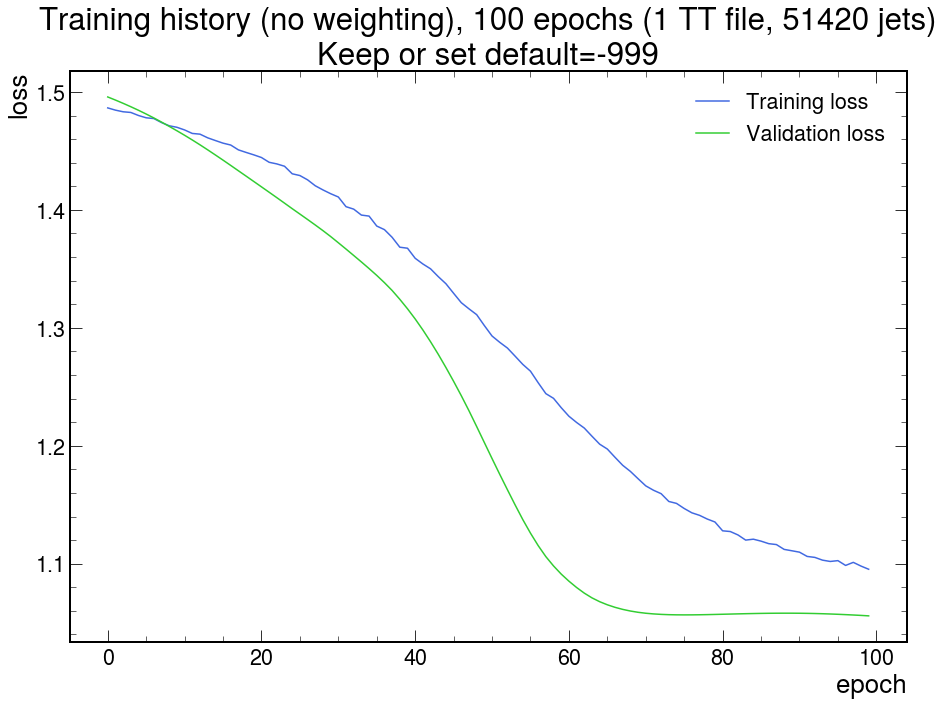

In [10]:
prev_epochs_0 = 100



NUM_DATASETS = 1


weighting_method_0 = '_as_is'

plt.figure(1,figsize=[15,10.5])
plt.plot(loss_history,color='royalblue')
plt.plot(val_loss_history,color='limegreen')
plt.title(f"Training history (no weighting), {prev_epochs_0} epochs ({NUM_DATASETS} TT file, {total_n_train} jets)\nKeep or set default=-999")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [11]:
#evaluate network on inputs
model.to(device)
test_inputs.cuda()
test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')

jetFlavour = test_targets+1

<class 'torch.Tensor'>
predictions done


In [12]:
np.unique(test_targets.numpy())

array([0, 1, 2, 3])

In [13]:
mostprob = torch.argmax(predsTensor, 1)

In [16]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[ 404,    0,   31, 3528],
       [   2,    0,    0,   37],
       [  65,    0,    3, 1195],
       [ 155,    0,   10, 8854]])

In [20]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (WeightedRandomSampler) and DeepCSV outputs\n After 100 epochs, evaluated on 14284 jets')

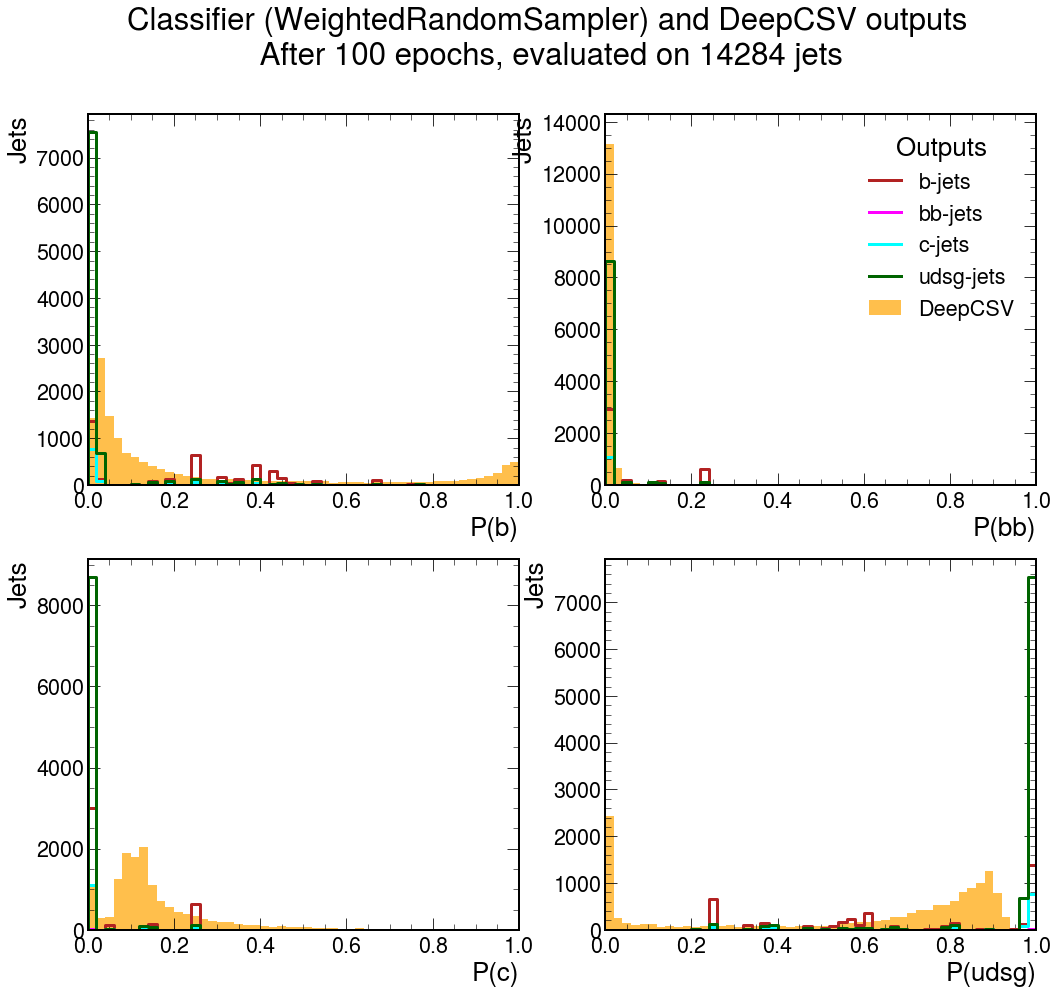

In [22]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (WeightedRandomSampler) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.8076202425971875
auc for bb-tagging: 0.7518643518643519
auc for c-tagging: 0.5086542094161431
auc for udsg-tagging: 0.7757279530277275


896

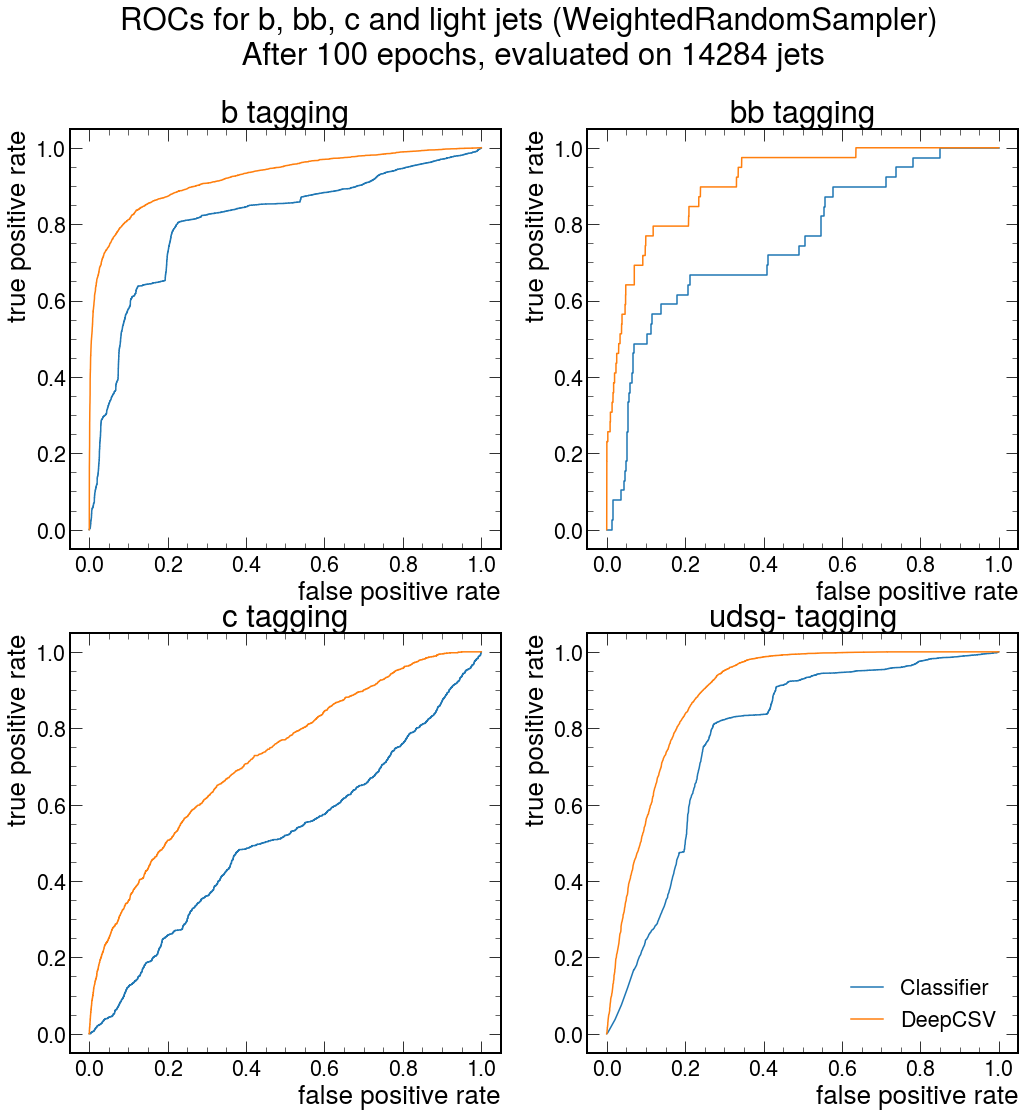

In [23]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (WeightedRandomSampler)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()

Ok, so in principle everything seems to be consistent, but the performance is far from good, even though it worked well for the first run with cleaned QCD files (in January / February). The cleaning is currently not strict enough to get rid of all nonsense values, and simply keeps a lot of them as defaults.

# Cleaning: delete defaults

## Cleaning

In [39]:
def cleandataset(f):
# the feature-names are the attributes or columns of interest, in this case: information about Jets
    feature_names = [k for k in f['Events'].keys() if  (('Jet_eta' == k) or ('Jet_pt' == k) or ('Jet_DeepCSV' in k))]
    # tagger output to compare with later and variables used to get the truth output
    feature_names.extend(('Jet_btagDeepB_b','Jet_btagDeepB_bb', 'Jet_btagDeepC','Jet_btagDeepL'))
    feature_names.extend(('Jet_nBHadrons', 'Jet_hadronFlavour'))
    
    
    # go through a specified number of events, and get the information (awkward-arrays) for the keys specified above
    for data in f['Events'].iterate(feature_names, step_size=f['Events'].num_entries, library='ak'):
        break
        
    
    # creating an array to store all the columns with their entries per jet, flatten per-event -> per-jet
    datacolumns = np.zeros((len(feature_names)+1, len(ak.flatten(data['Jet_pt'], axis=1))))
   

    for featureindex in range(len(feature_names)):
        a = ak.flatten(data[feature_names[featureindex]], axis=1) # flatten along first inside to get jets
        
        datacolumns[featureindex] = ak.to_numpy(a)


    nbhad = ak.to_numpy(ak.flatten(data['Jet_nBHadrons'], axis=1))
    hadflav = ak.to_numpy(ak.flatten(data['Jet_hadronFlavour'], axis=1))

    target_class = np.full_like(hadflav, 3)                                                      # udsg
    target_class = np.where(hadflav == 4, 2, target_class)                                       # c
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad > 1), 1, target_class)            # bb
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad <= 1), 0, target_class)           # b, lepb

   

    datacolumns[len(feature_names)] = ak.to_numpy(target_class) 

    datavectors = datacolumns.transpose()

    '''
    for j in range(len(datavectors[0])):
        datavectors[datavectors[:, j] == np.nan]  = -999
        datavectors[datavectors[:, j] <= -np.inf] = -999
        datavectors[datavectors[:, j] >= np.inf]  = -999
    '''
    for j in range(len(datavectors[0])):
        datavectors = datavectors[datavectors[:, j] != np.nan]
        datavectors = datavectors[datavectors[:, j] > -np.inf]
        datavectors = datavectors[datavectors[:, j] < np.inf]
    
    datavecak = ak.from_numpy(datavectors)
    
    #print(len(datavecak),"entries before cleaning step 1")
    
    datavecak = datavecak[datavecak[:, 67] >= 0.]
    datavecak = datavecak[datavecak[:, 67] <= 1.]
    datavecak = datavecak[datavecak[:, 68] >= 0.]
    datavecak = datavecak[datavecak[:, 68] <= 1.]
    datavecak = datavecak[datavecak[:, 69] >= 0.]
    datavecak = datavecak[datavecak[:, 69] <= 1.]
    datavecak = datavecak[datavecak[:, 70] >= 0.]
    datavecak = datavecak[datavecak[:, 70] <= 1.]

    

    # check jetNSelectedTracks, jetNSecondaryVertices > 0
    datavecak = datavecak[(datavecak[:, 63] > 0) | (datavecak[:, 64] > 0)]  # keep those where at least any of the two variables is > 0, they don't need to be > 0 simultaneously
    #print(len(datavecak),"entries after cleaning step 1")

    alldata = ak.to_numpy(datavecak)
    
    
    ############## DELETE DEFAULTS ###############
    
    for p in range(len(alldata[0])):
        alldata = alldata[alldata[:,p] != - 999]
        
        
    
    for track0_vars in [6,12,22,29,35,42,50]:
        alldata[:,track0_vars][alldata[:,64] <= 0] = -999
    for track0_1_vars in [7,13,23,30,36,43,51]:
        alldata[:,track0_1_vars][alldata[:,64] <= 1] = -999
    for track01_2_vars in [8,14,24,31,37,44,52]:
        alldata[:,track01_2_vars][alldata[:,64] <= 2] = -999
    for track012_3_vars in [9,15,25,32,38,45,53]:
        alldata[:,track012_3_vars][alldata[:,64] <= 3] = -999
    for track0123_4_vars in [10,16,26,33,39,46,54]:
        alldata[:,track0123_4_vars][alldata[:,64] <= 4] = -999
    for track01234_5_vars in [11,17,27,34,40,47,55]:
        alldata[:,track01234_5_vars][alldata[:,64] <= 5] = -999
    alldata[:,18][alldata[:,65] <= 0] = -999
    alldata[:,19][alldata[:,65] <= 1] = -999
    alldata[:,20][alldata[:,65] <= 2] = -999
    alldata[:,21][alldata[:,65] <= 3] = -999
    
    
    
    
    datacls = [i for i in range(0,67)]
    datacls.append(73)
    dataset = alldata[:, datacls]
    
    DeepCSV_dataset = alldata[:, 67:71]
    
    return dataset, DeepCSV_dataset

In [40]:
dataset, DeepCSV_dataset = cleandataset(uproot.open('/home/um106329/aisafety/new_march_21/rootfiles/nano_mc2017_1-1156.root'))

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


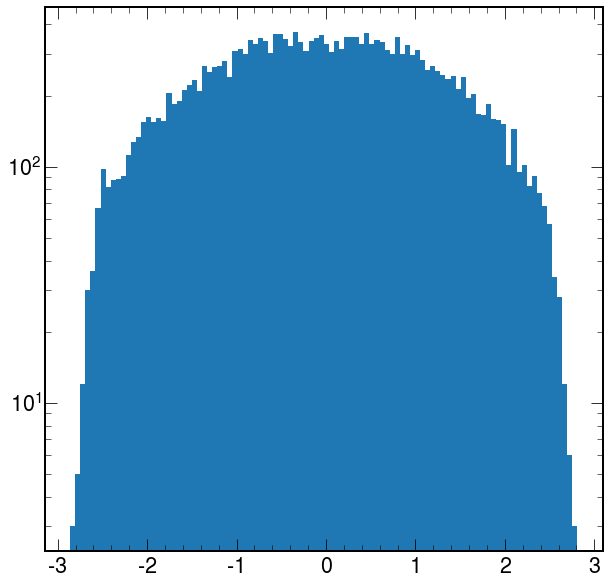

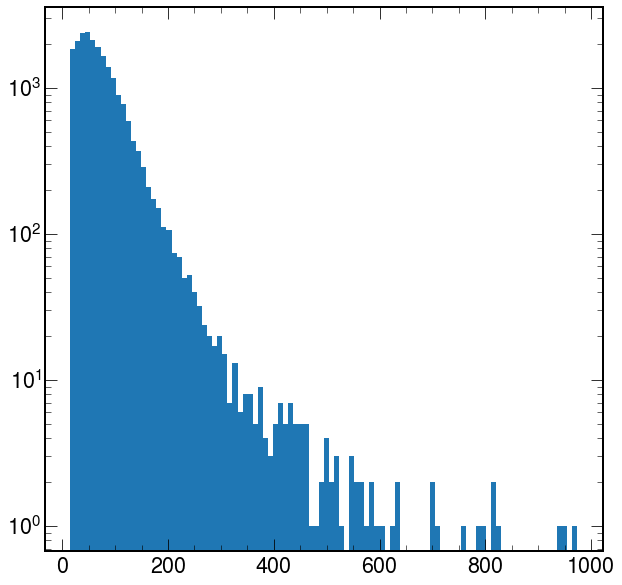

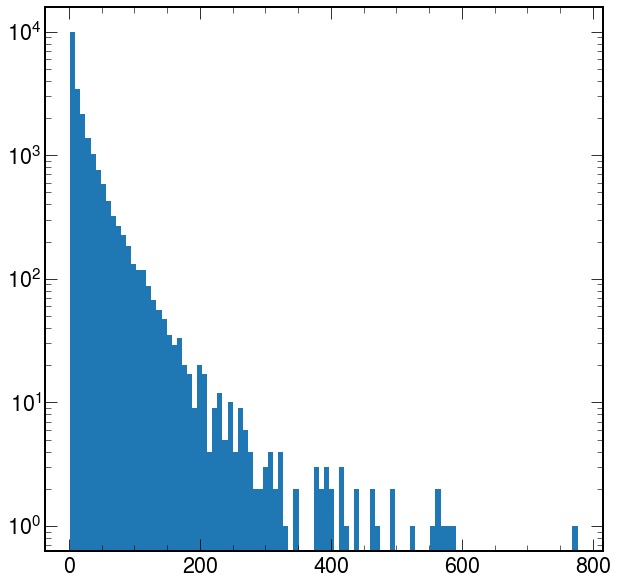

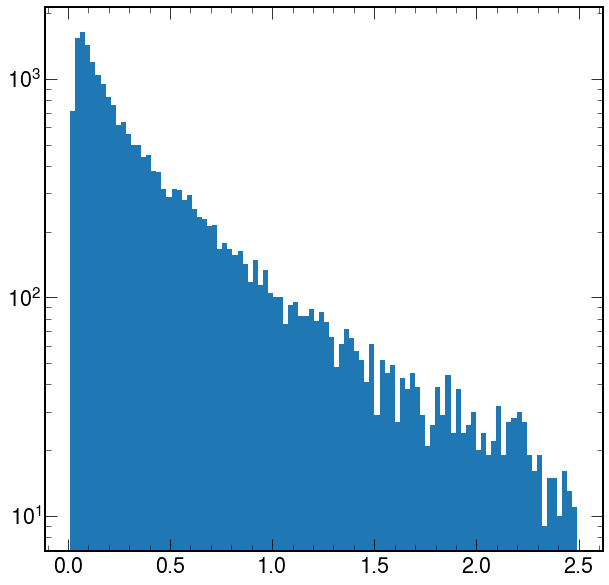

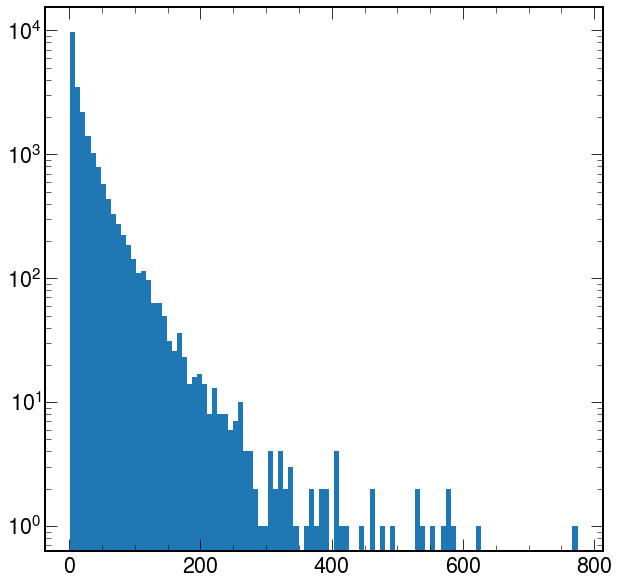

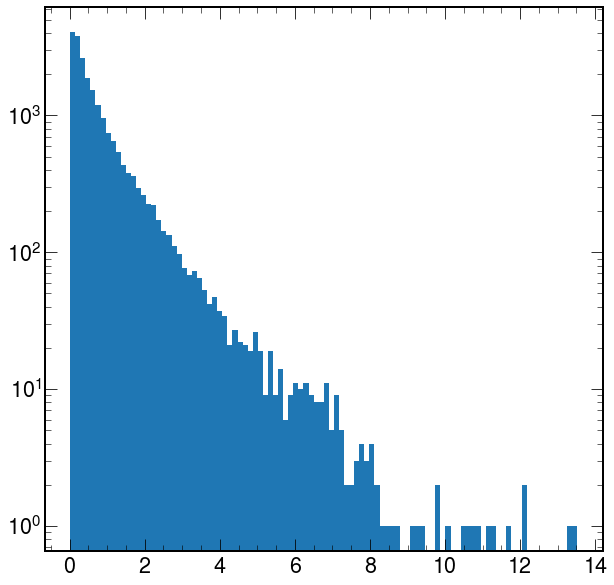

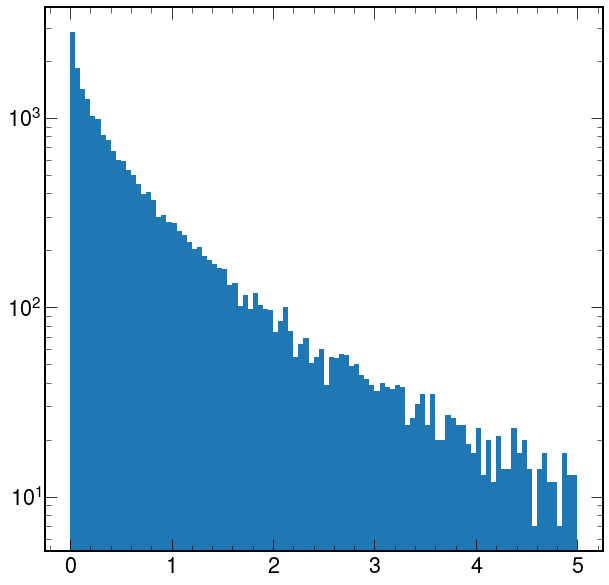

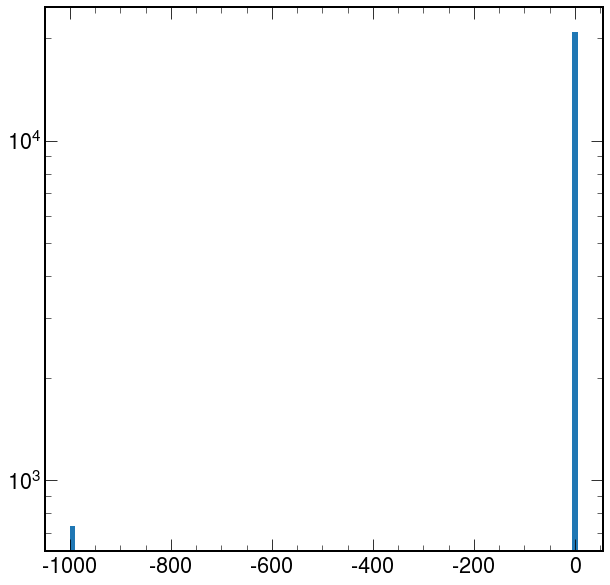

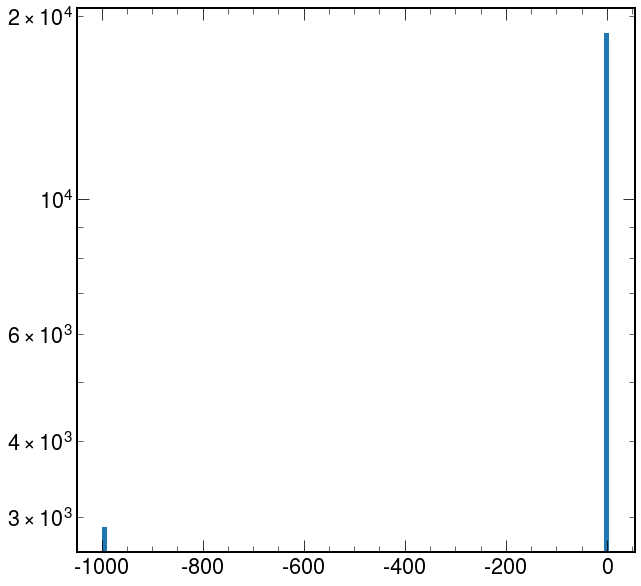

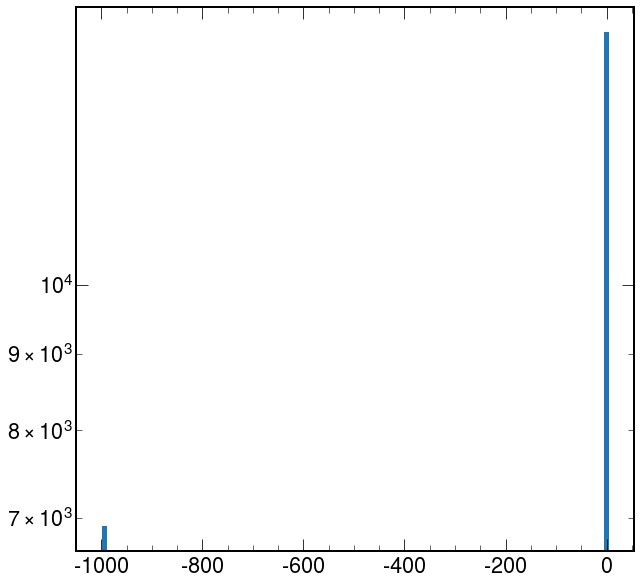

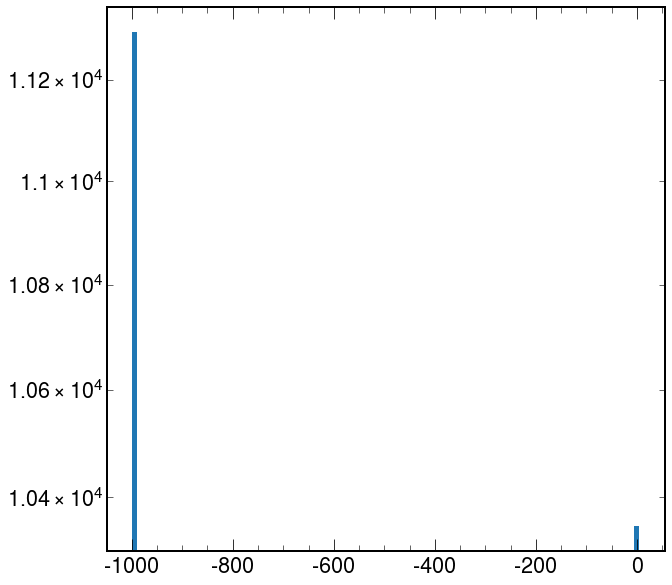

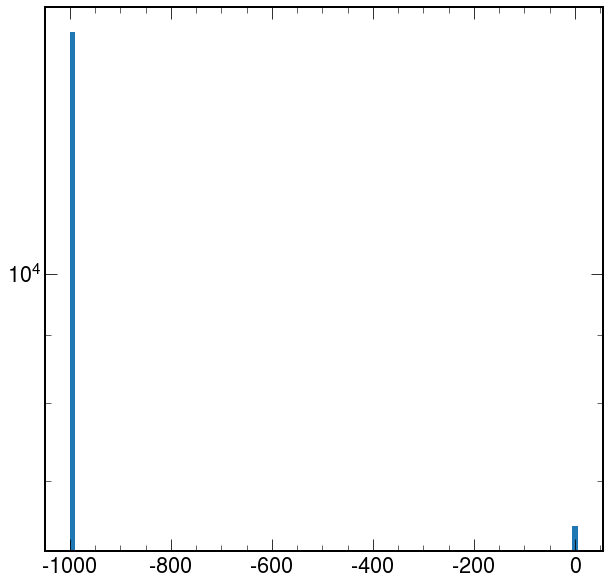

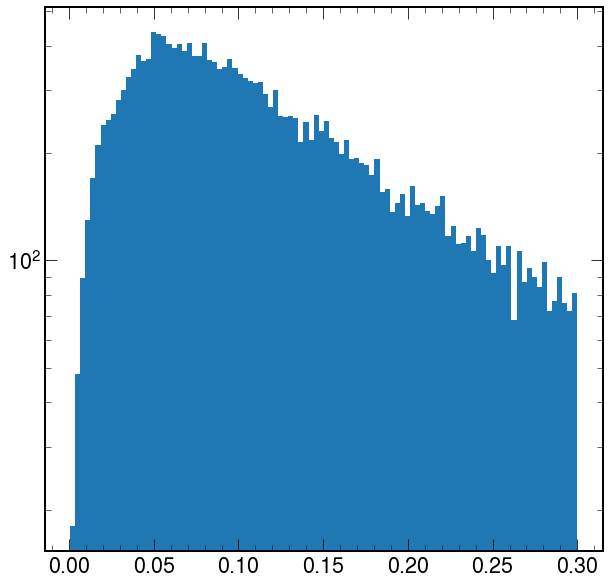

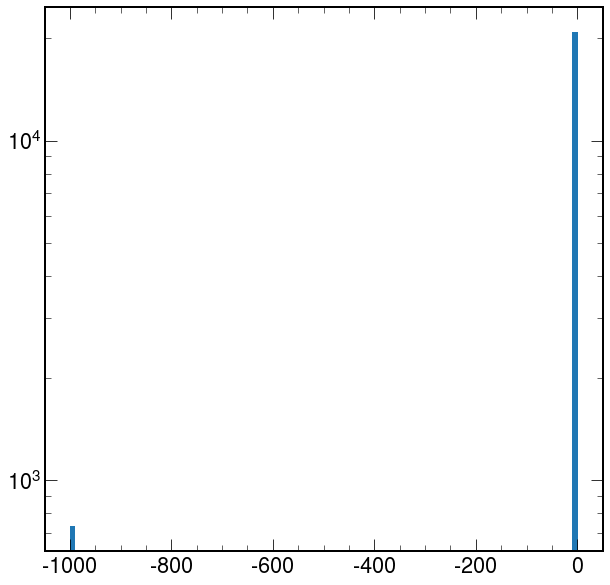

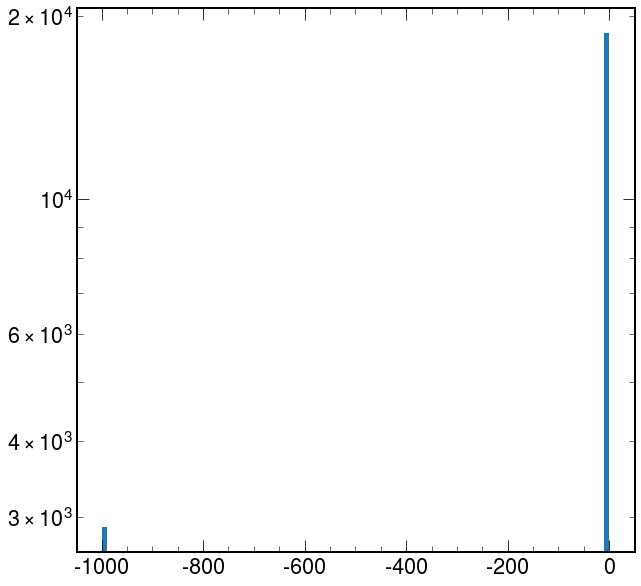

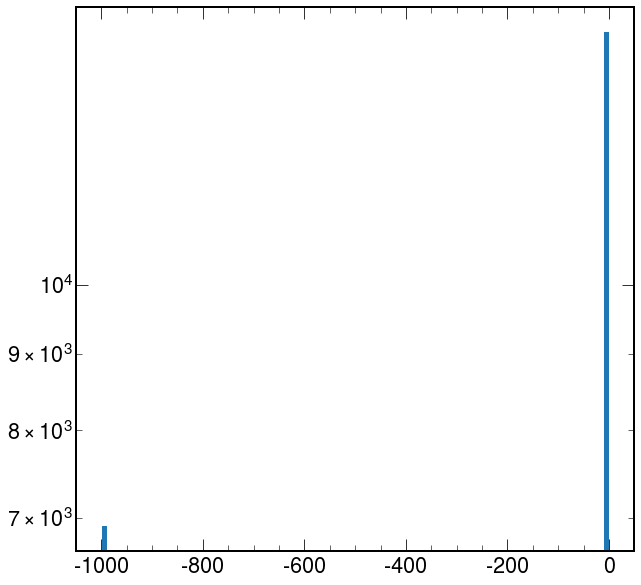

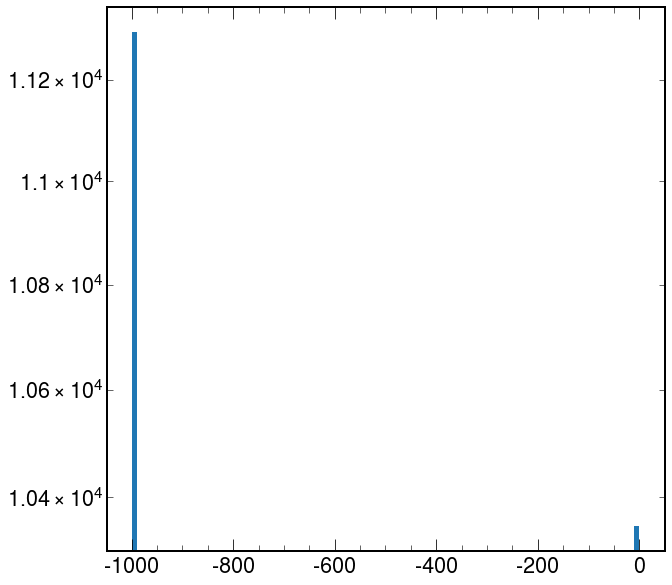

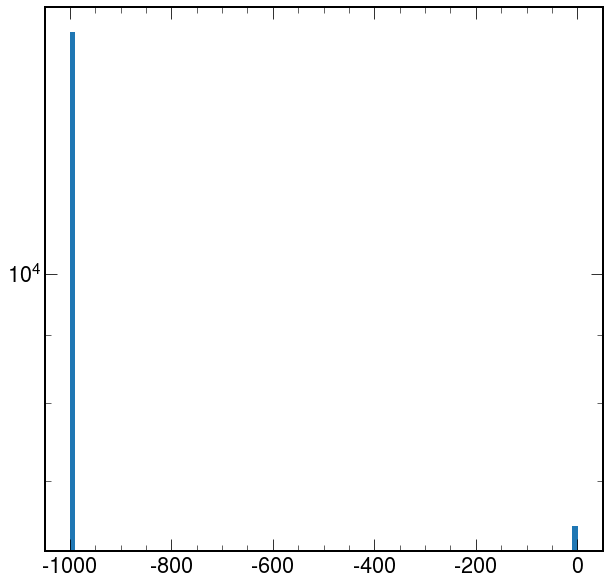

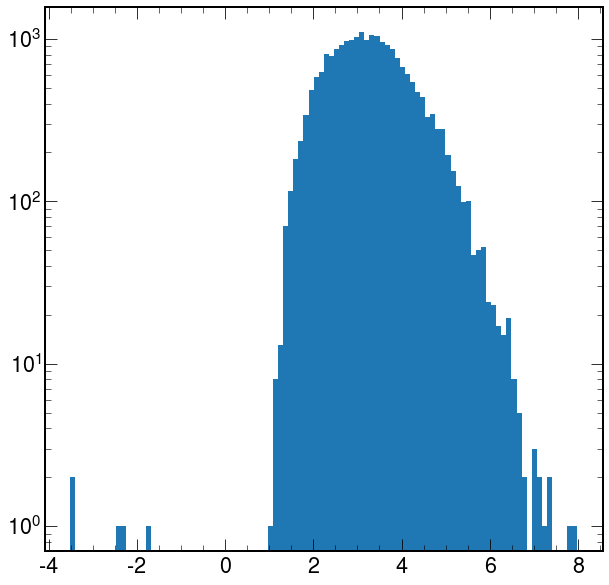

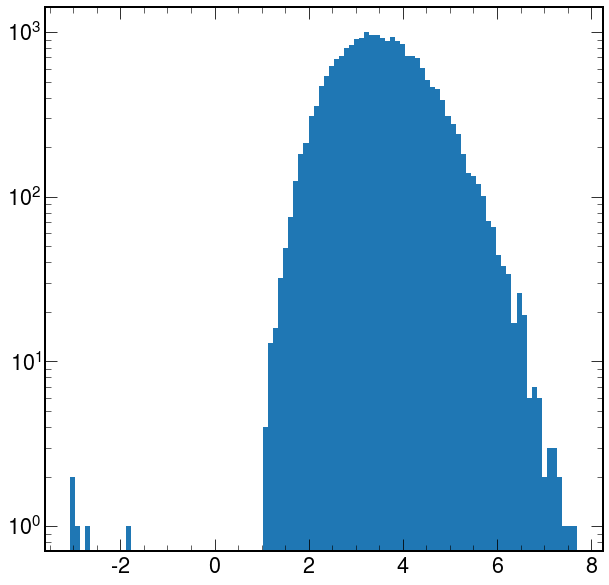

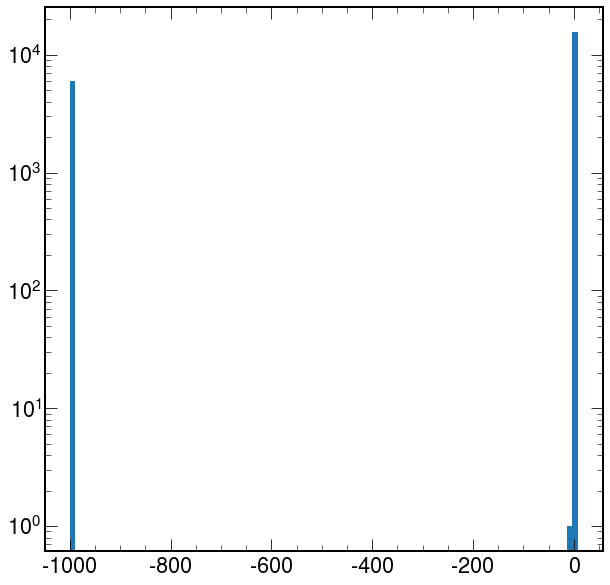

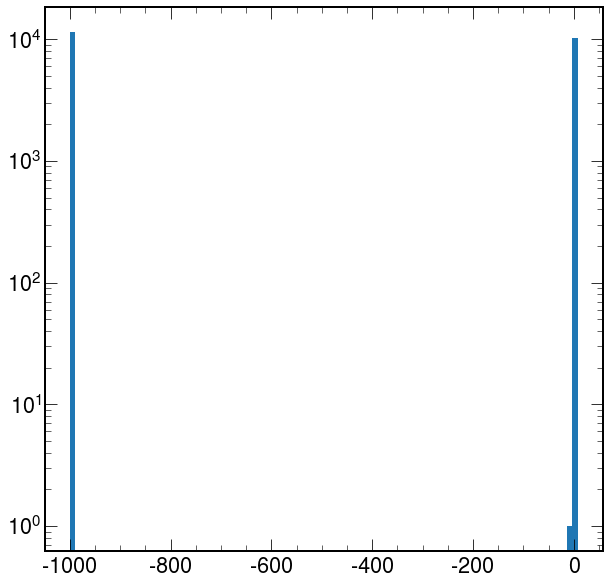

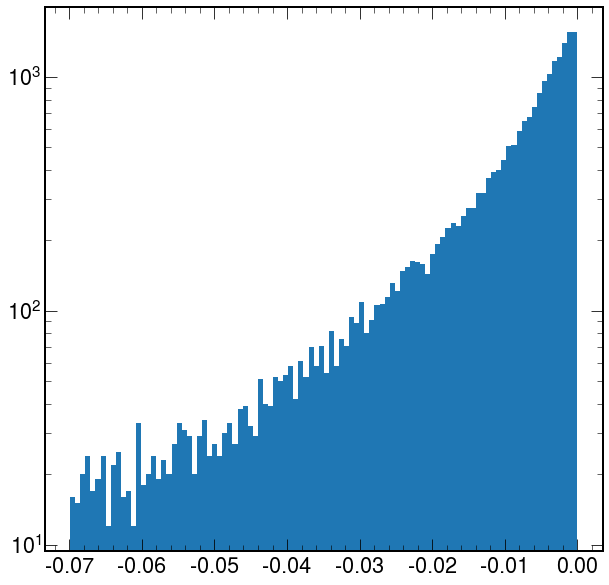

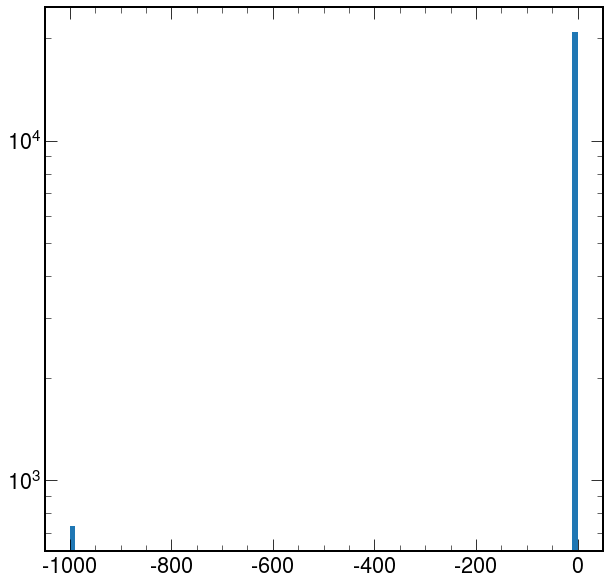

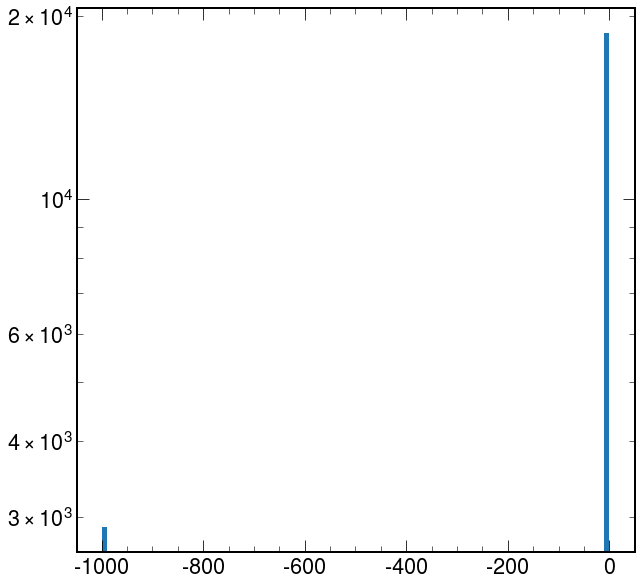

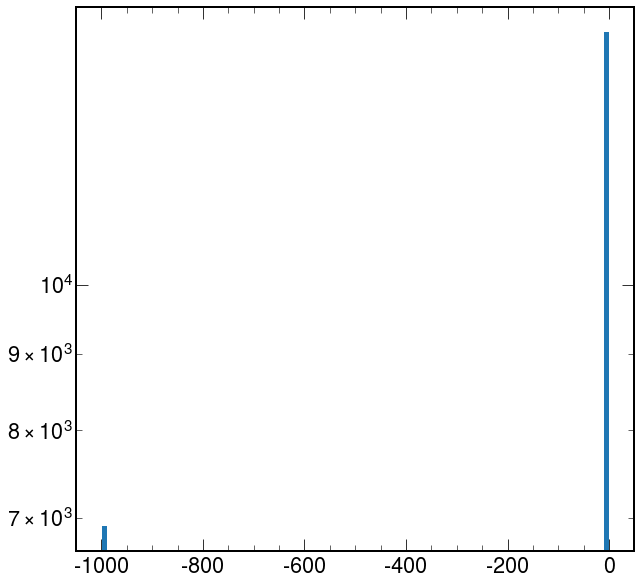

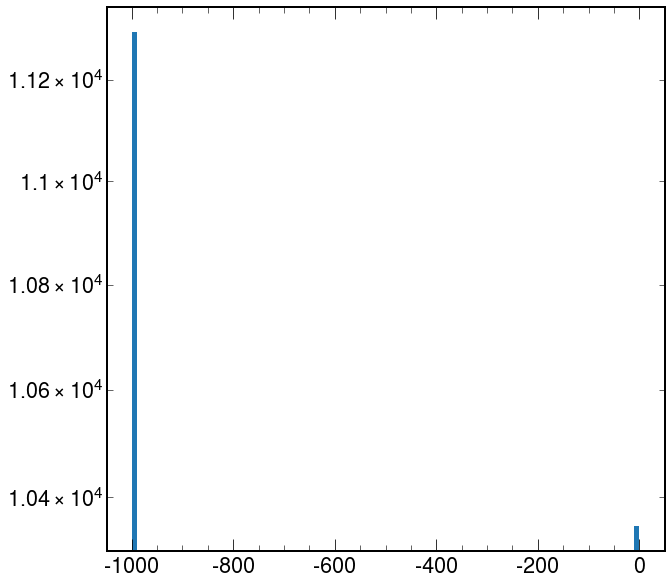

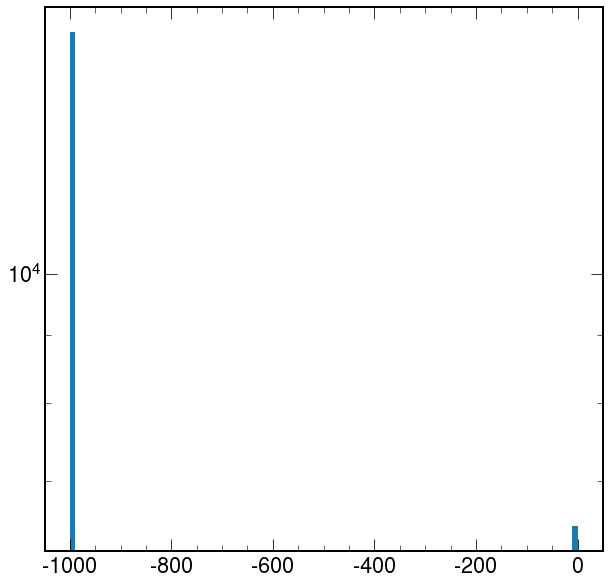

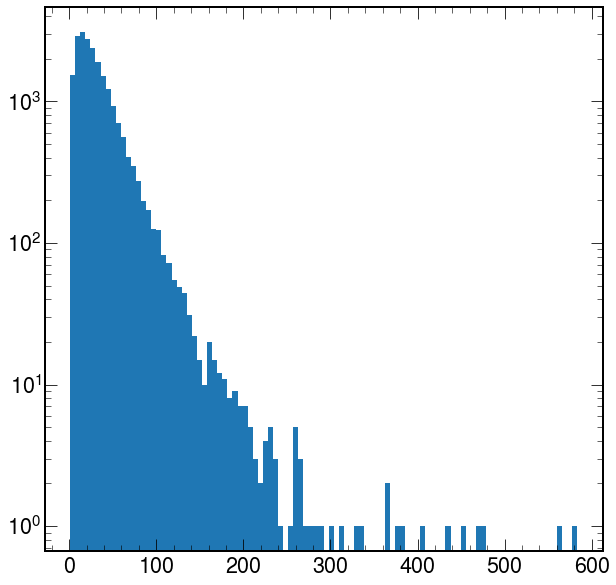

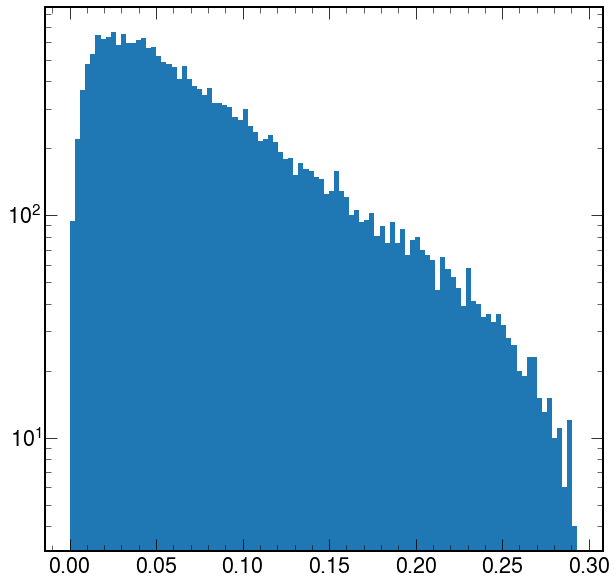

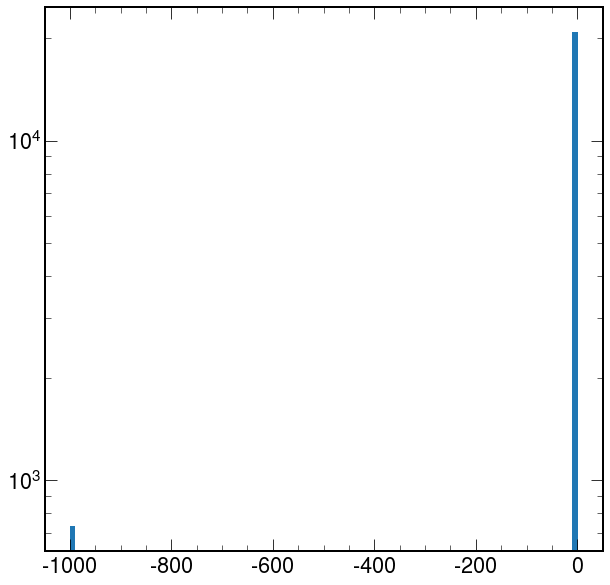

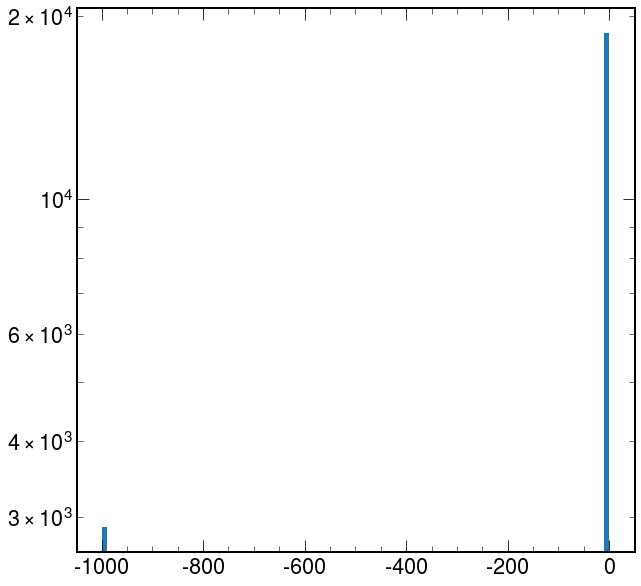

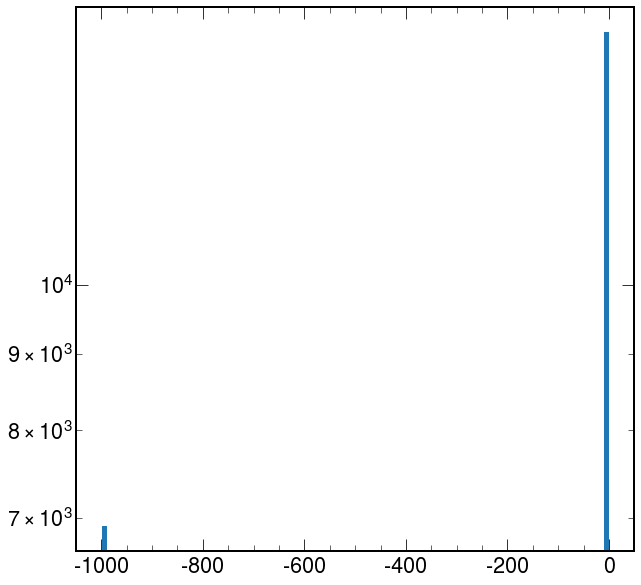

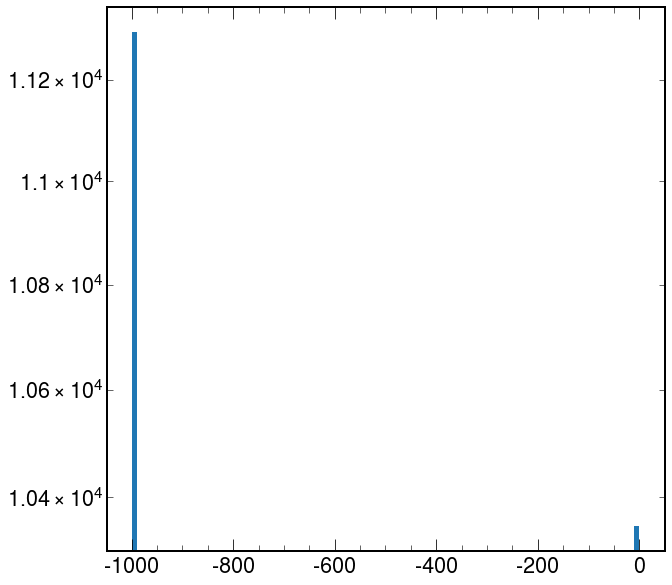

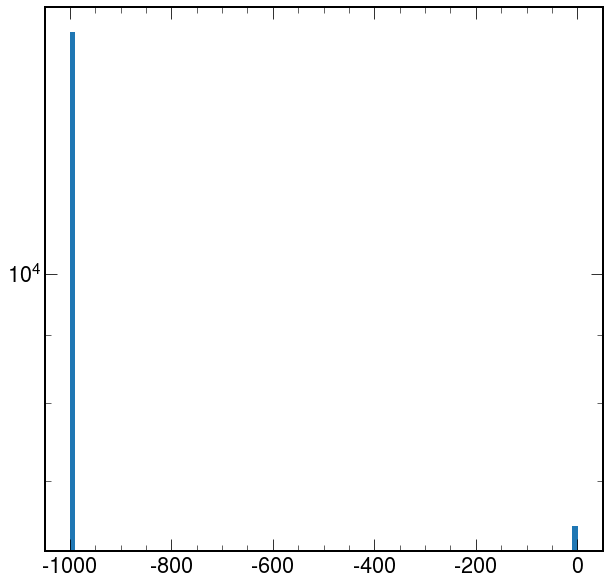

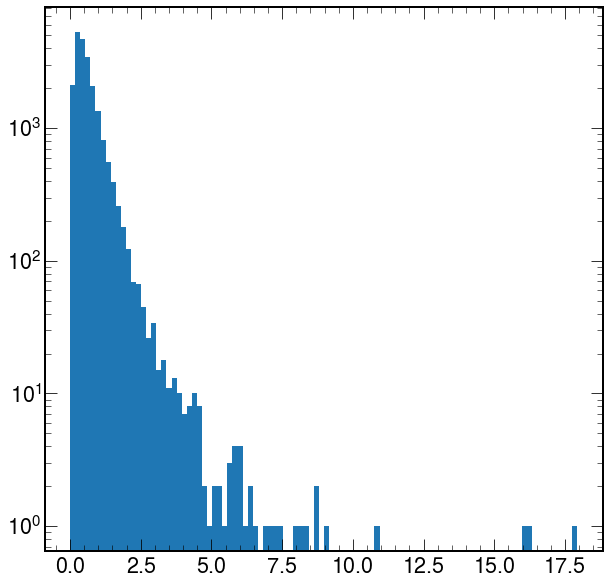

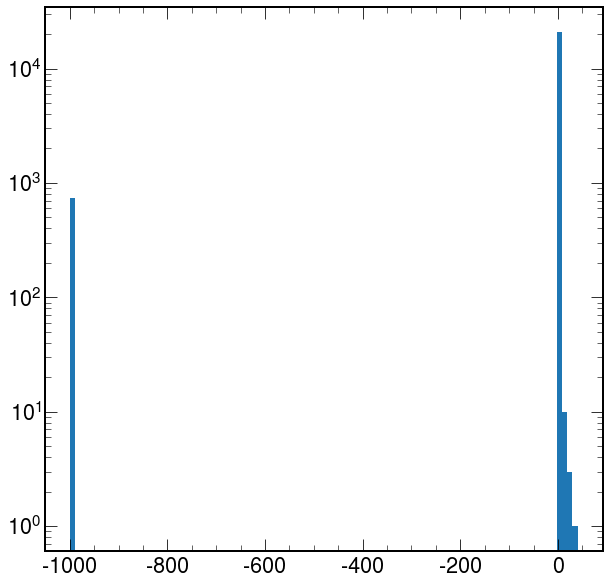

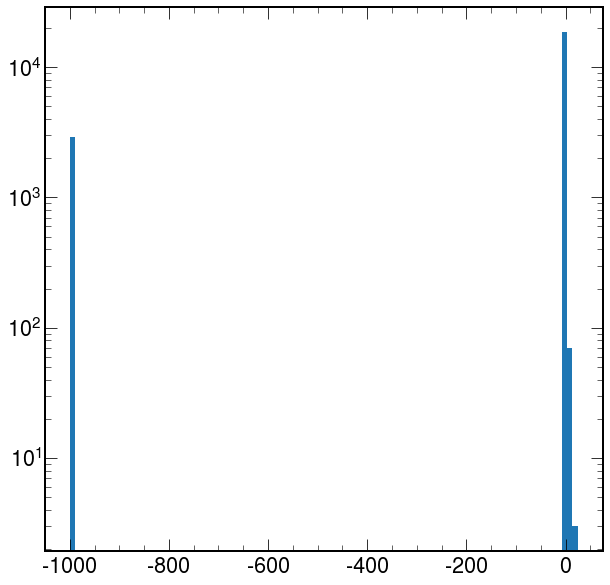

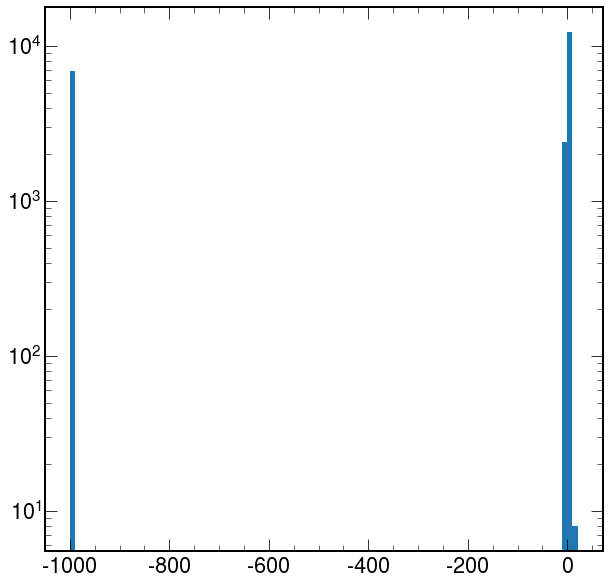

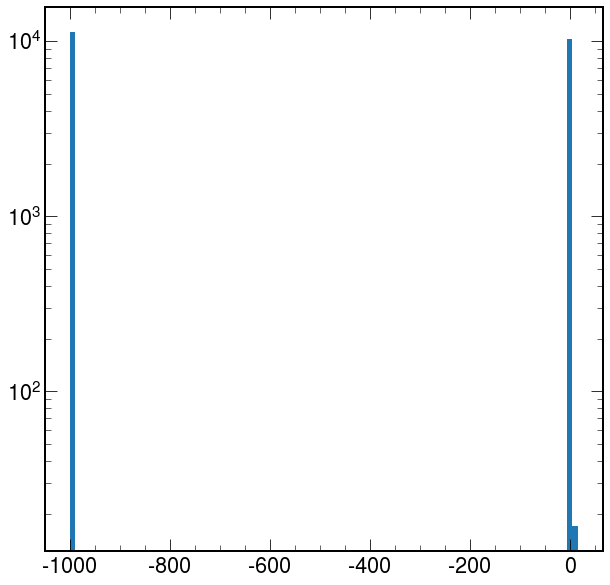

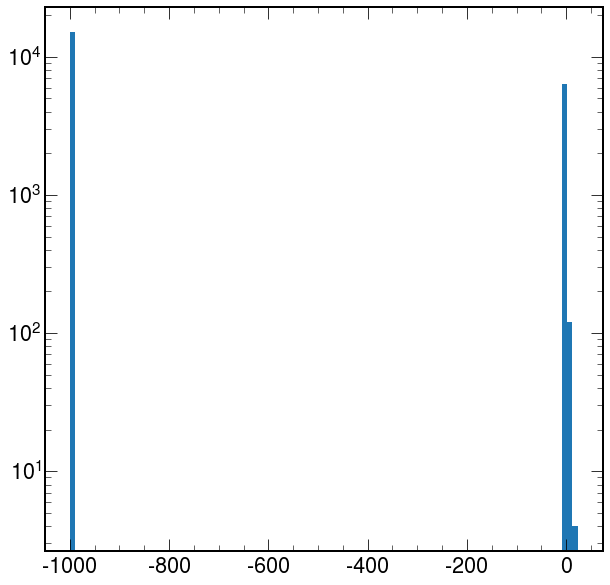

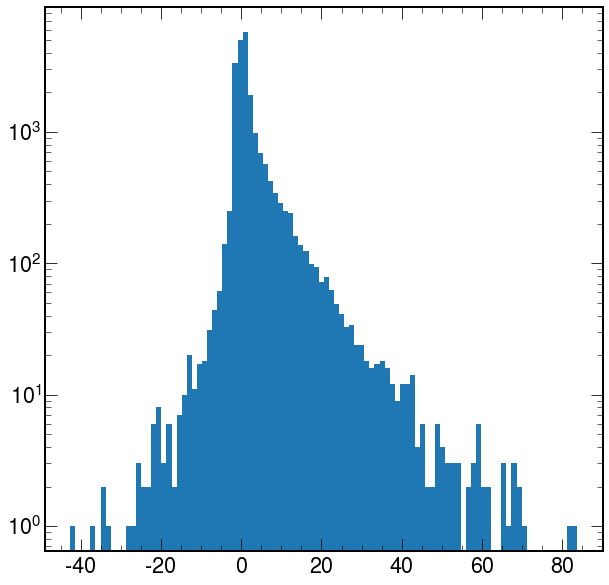

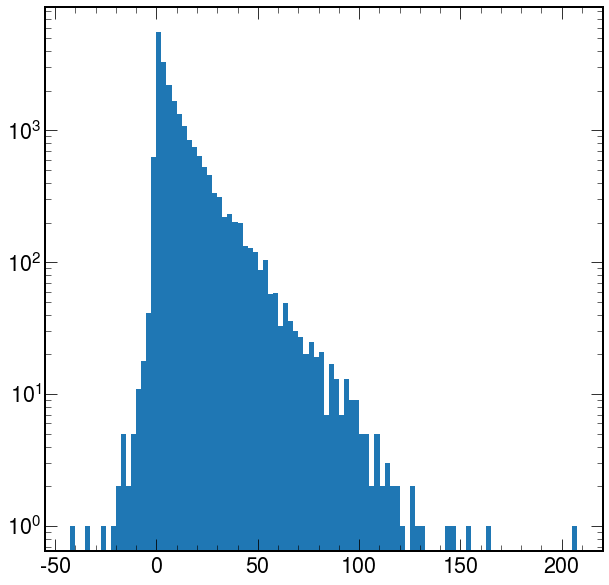

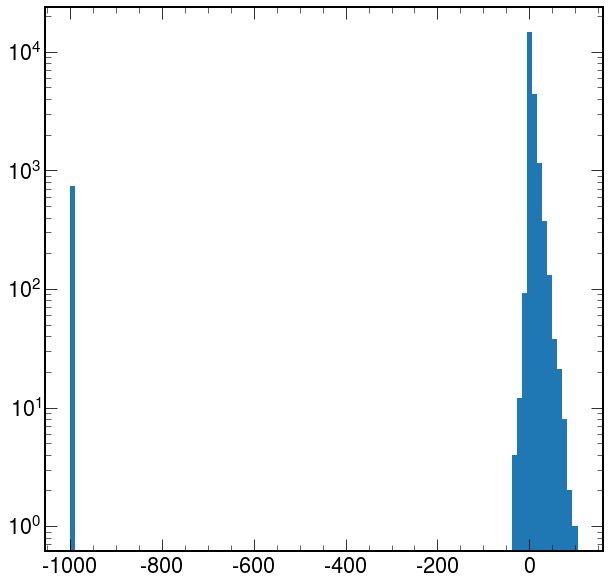

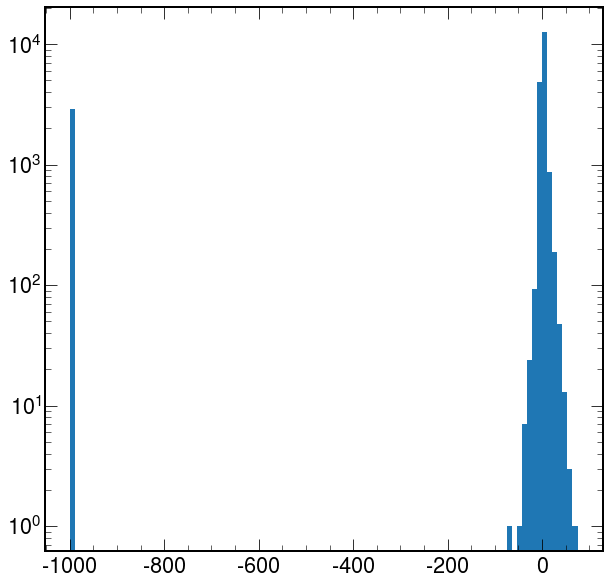

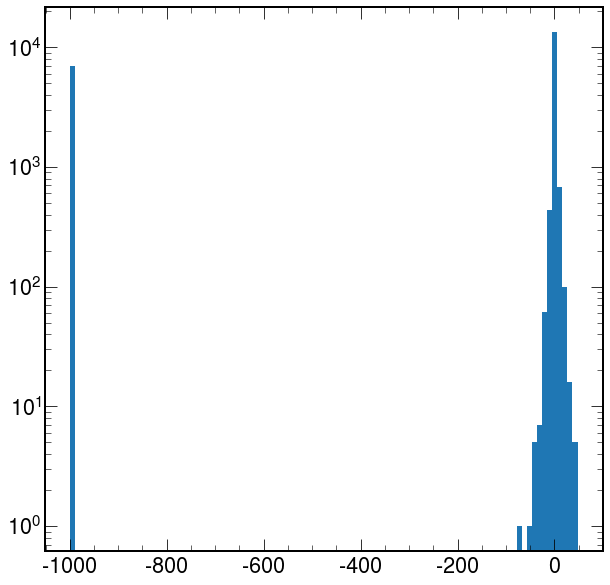

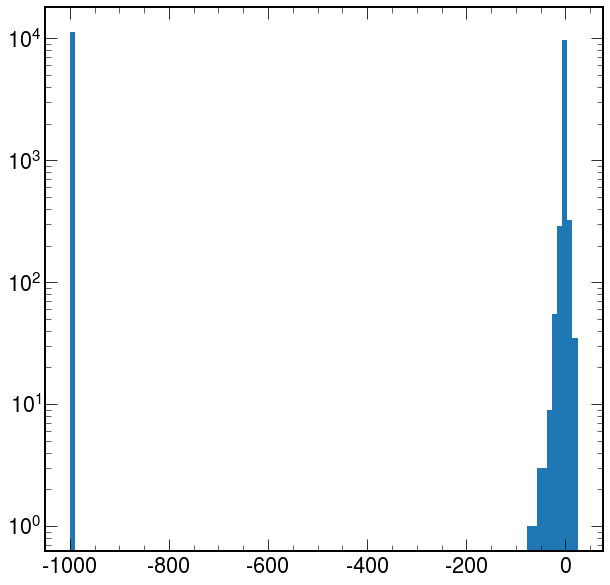

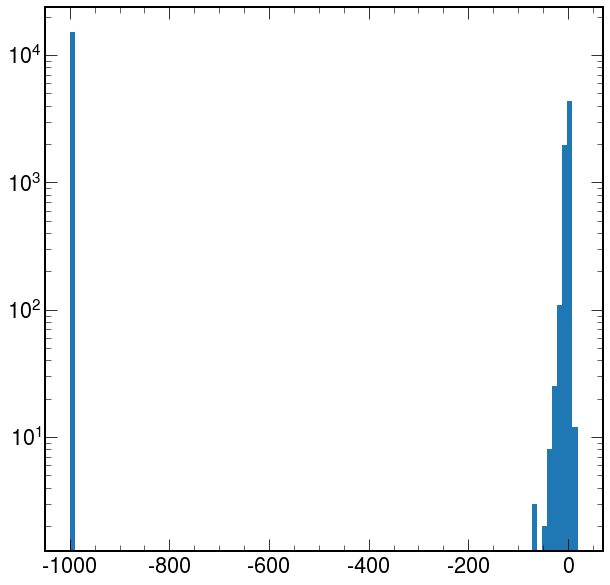

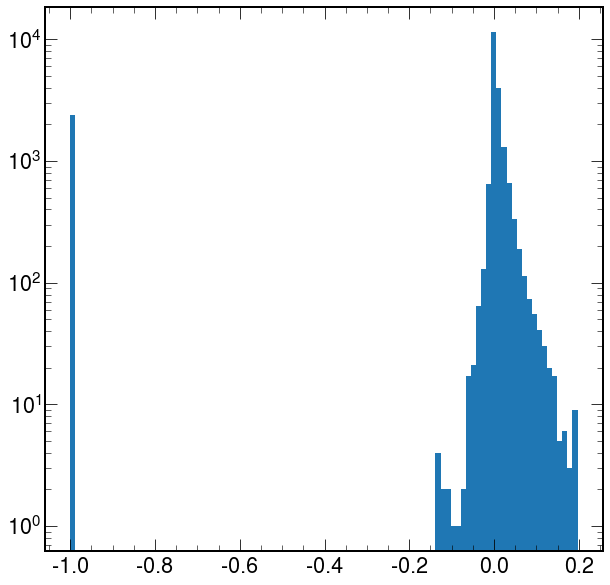

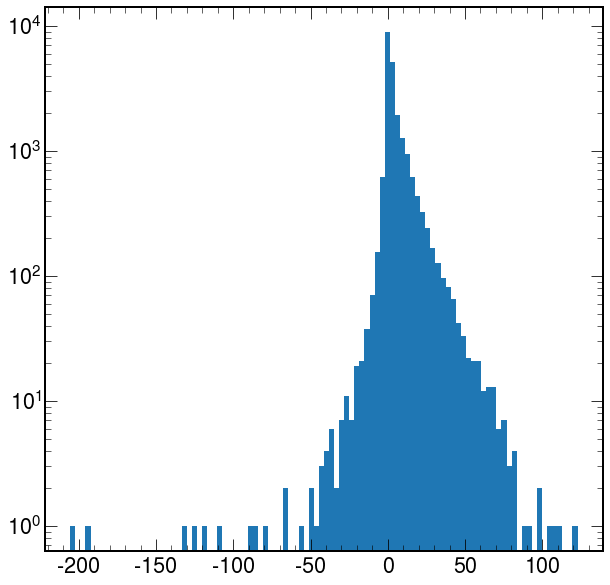

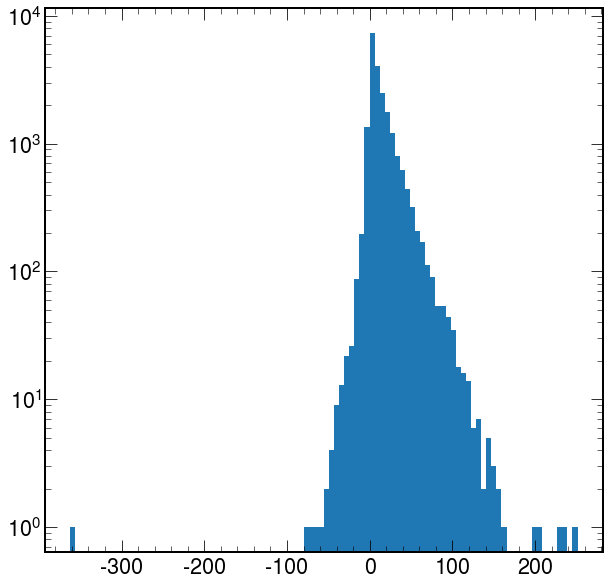

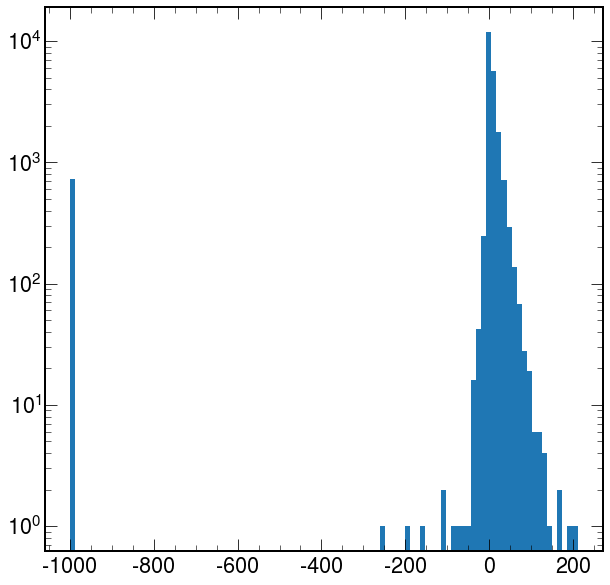

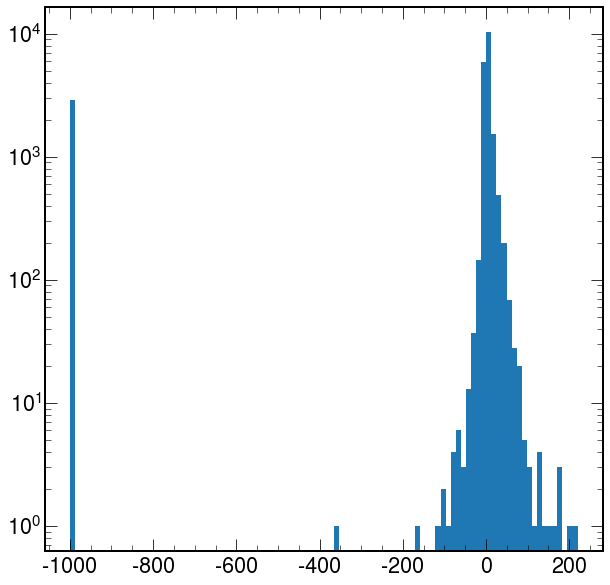

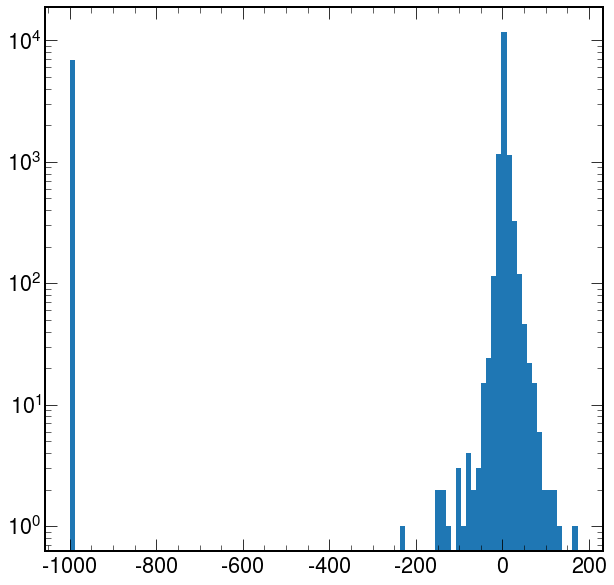

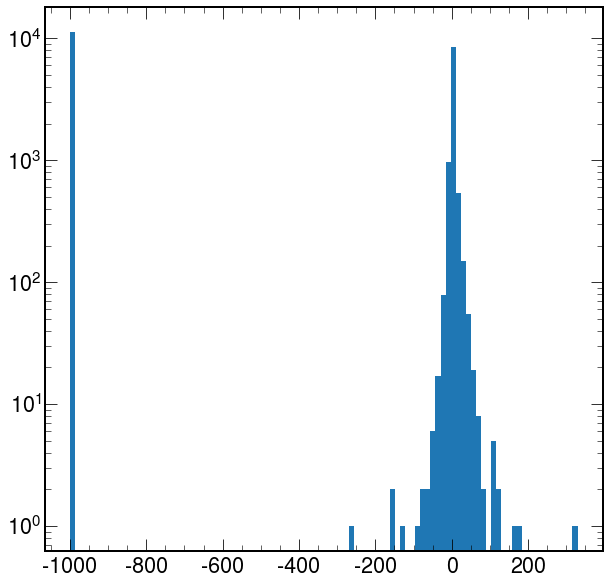

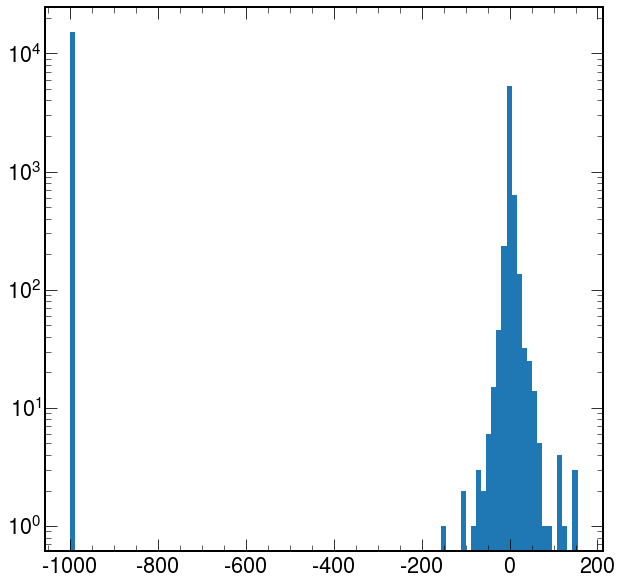

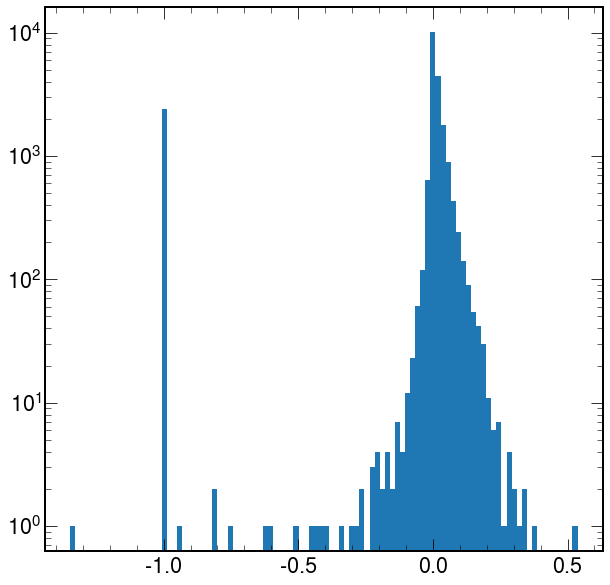

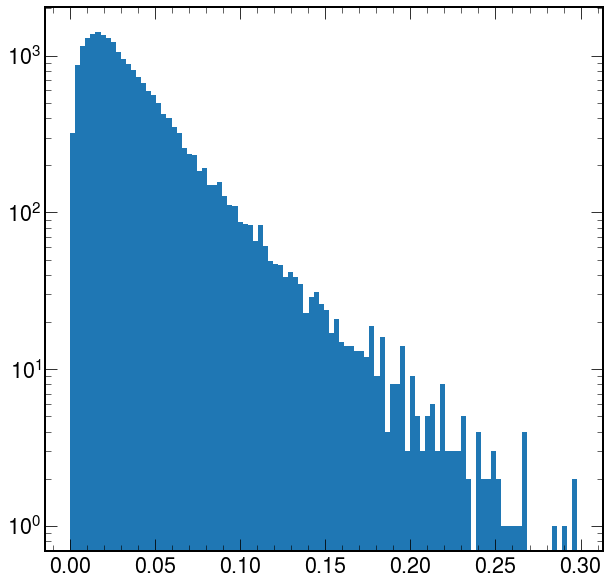

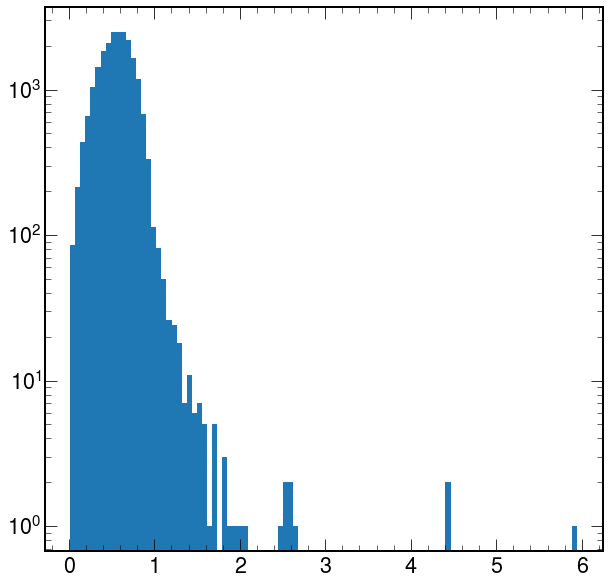

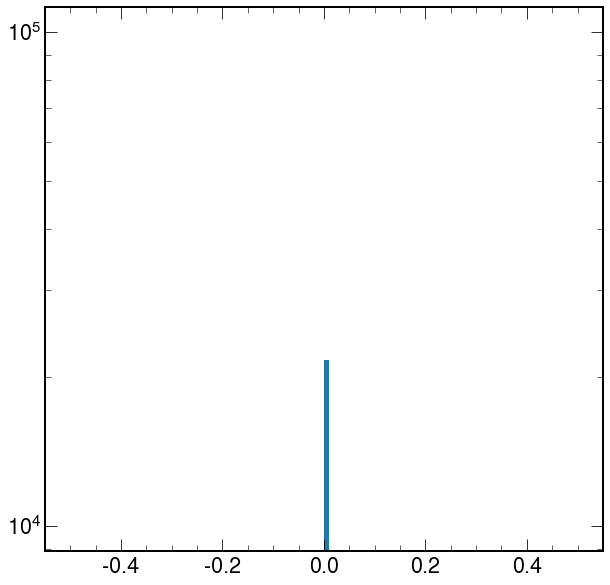

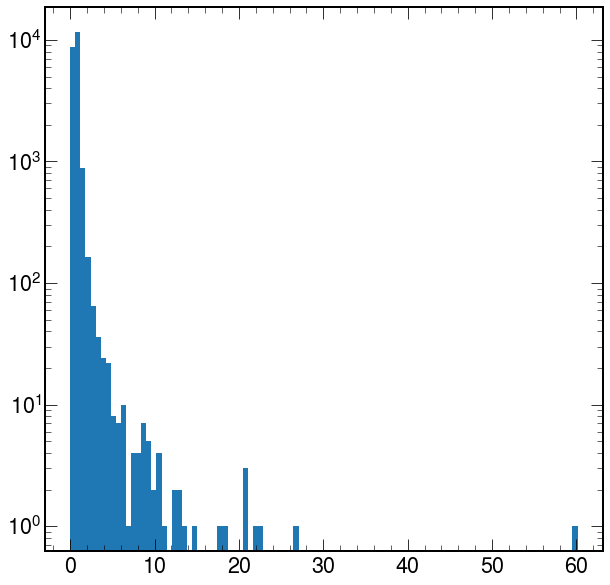

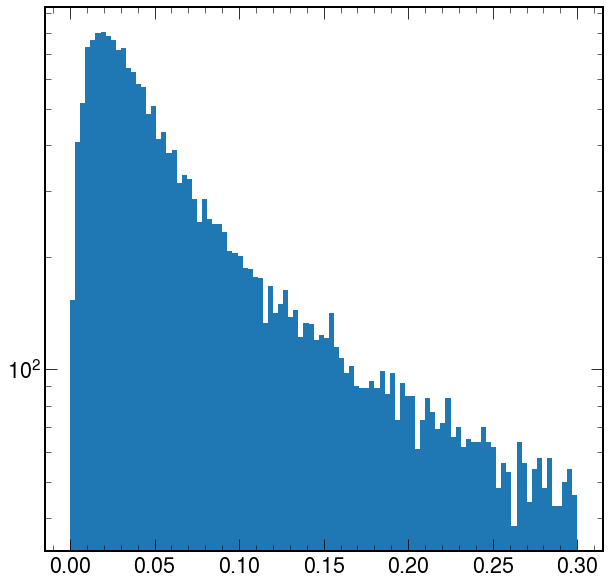

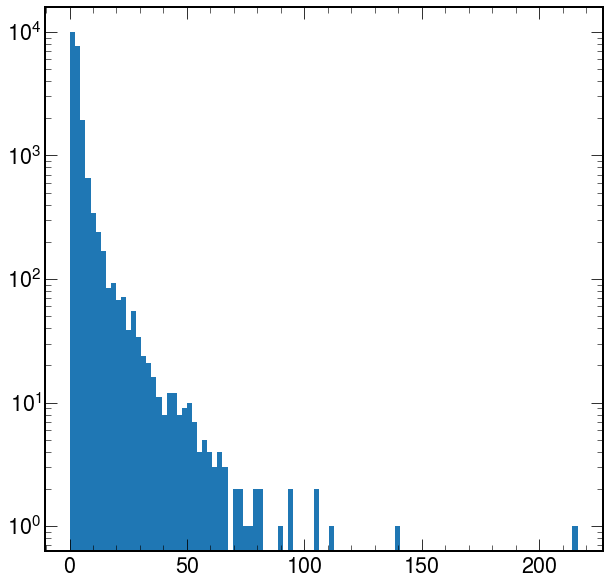

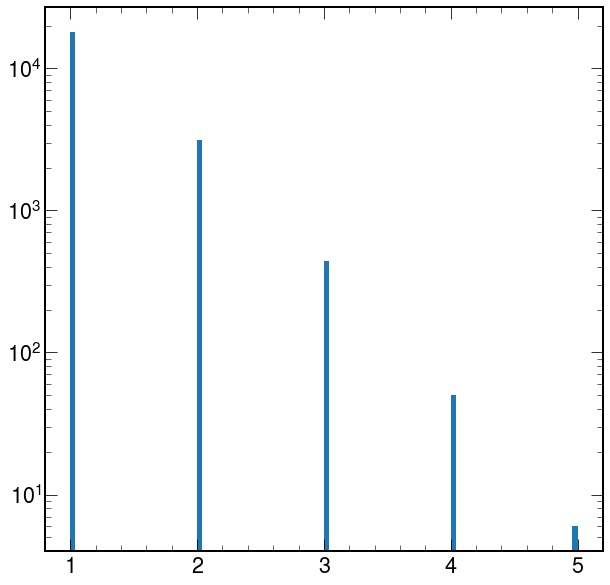

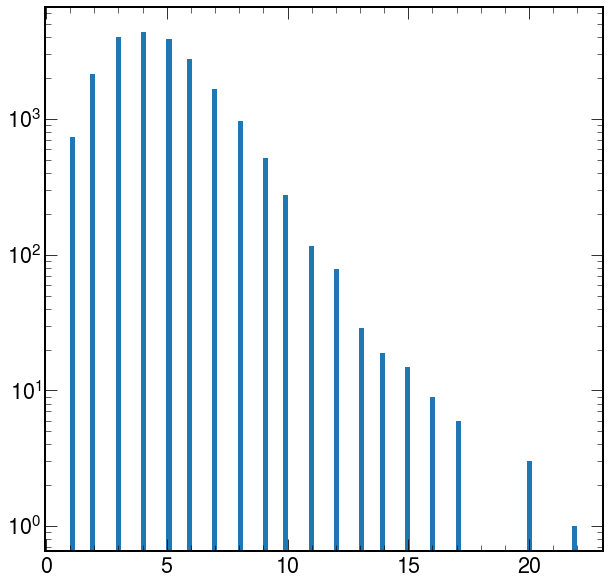

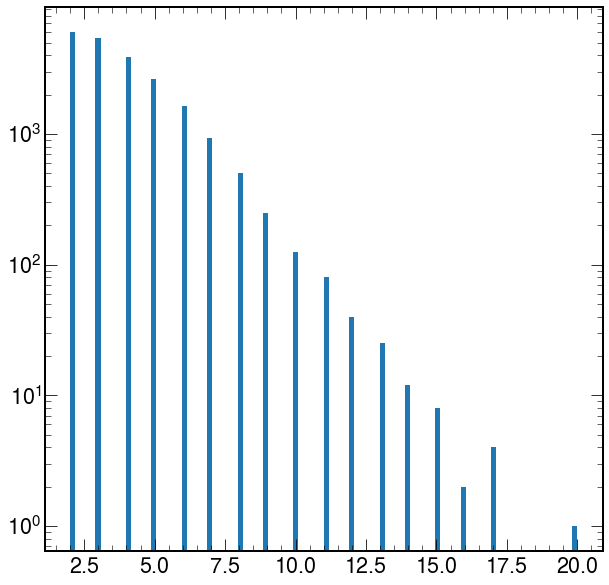

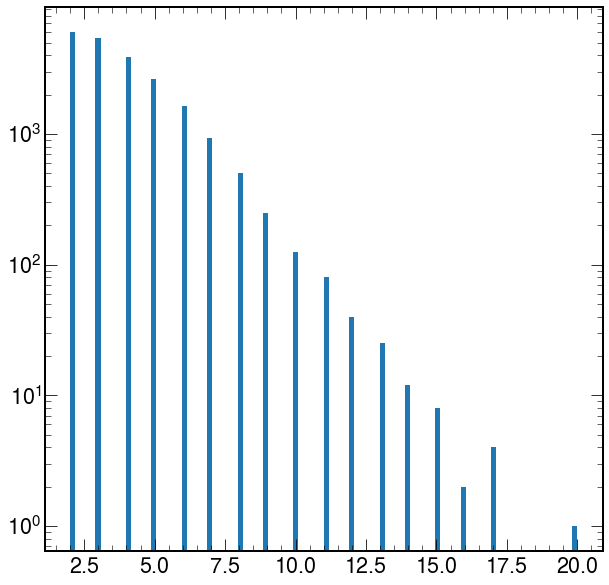

In [41]:
for a in range(67):
    plt.hist(dataset[:,a], bins=100, log=True)
    plt.show()

## Preprocess (scale)

In [42]:
trainingset,testset,_,DeepCSV_testset = train_test_split(dataset, DeepCSV_dataset, test_size=0.2, random_state=1)
trainset, valset = train_test_split(trainingset,test_size=0.1, random_state=1)


test_inputs = torch.Tensor(testset[:,0:67])                                                
test_targets = (torch.Tensor([testset[i][-1] for i in range(len(testset))])).long()        
val_inputs = torch.Tensor(valset[:,0:67])
val_targets = (torch.Tensor([valset[i][-1] for i in range(len(valset))]).long())
train_inputs = torch.Tensor(trainset[:,0:67])
train_targets = (torch.Tensor([trainset[i][-1] for i in range(len(trainset))])).long()



norm_train_inputs,norm_val_inputs,norm_test_inputs = train_inputs.clone().detach(),val_inputs.clone().detach(),test_inputs.clone().detach()
scalers = []

for i in range(0,67): # do not apply scaling to default values, which were set to -999
    scaler = StandardScaler().fit(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1))
    '''
    norm_train_inputs[:,i][train_inputs[:,i]!=-999]   = torch.Tensor(scaler.transform(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i][val_inputs[:,i]!=-999]       = torch.Tensor(scaler.transform(val_inputs[:,i][val_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i][test_inputs[:,i]!=-999]     = torch.Tensor(scaler.transform(test_inputs[:,i][test_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    '''
    norm_train_inputs[:,i]   = torch.Tensor(scaler.transform(train_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i]     = torch.Tensor(scaler.transform(val_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i]    = torch.Tensor(scaler.transform(test_inputs[:,i].reshape(-1,1)).reshape(1,-1))

    scalers.append(scaler)


train_inputs = norm_train_inputs.clone().detach().to(torch.float16)
val_inputs = norm_val_inputs.clone().detach().to(torch.float16)
test_inputs = norm_test_inputs.clone().detach().to(torch.float16)


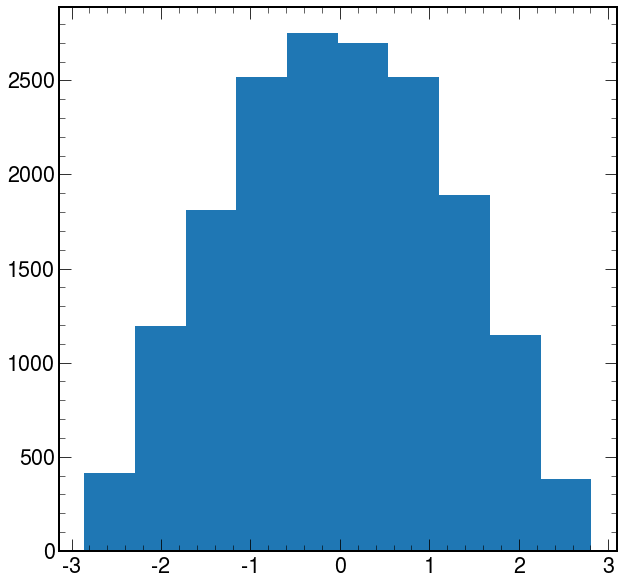

In [43]:
for a in range(1):
    plt.hist(trainingset[:,a])
    plt.show()

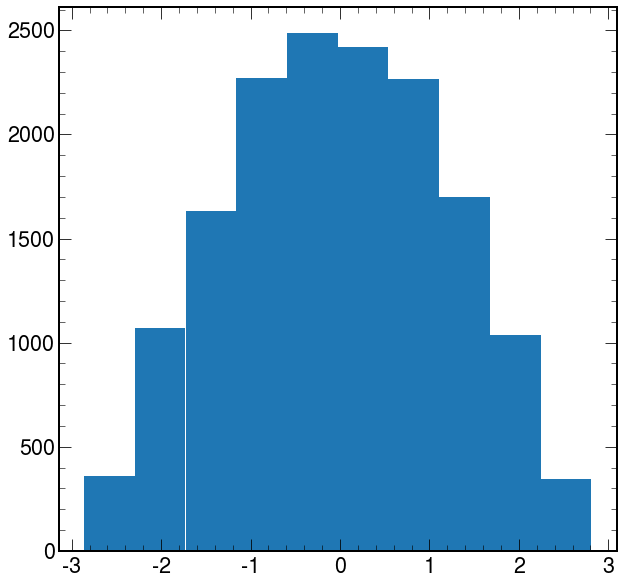

In [44]:
for a in range(1):
    plt.hist(scalers[a].inverse_transform(train_inputs[:,a].cpu()))
    plt.show()

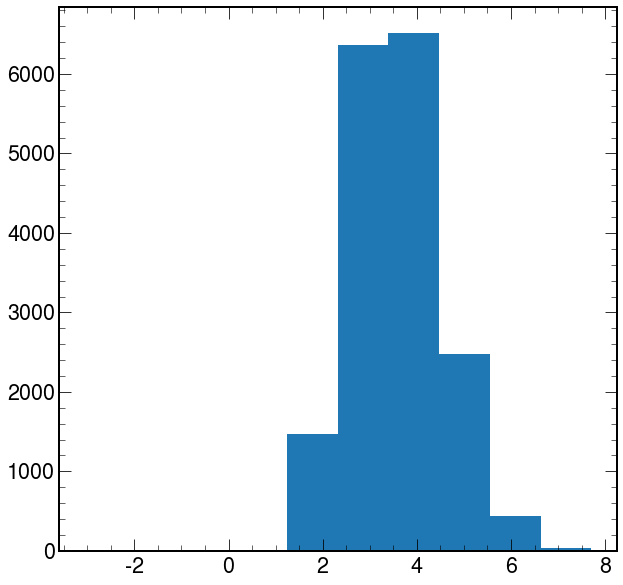

In [45]:
for a in range(1):
    plt.hist(trainingset[:,19])
    plt.show()

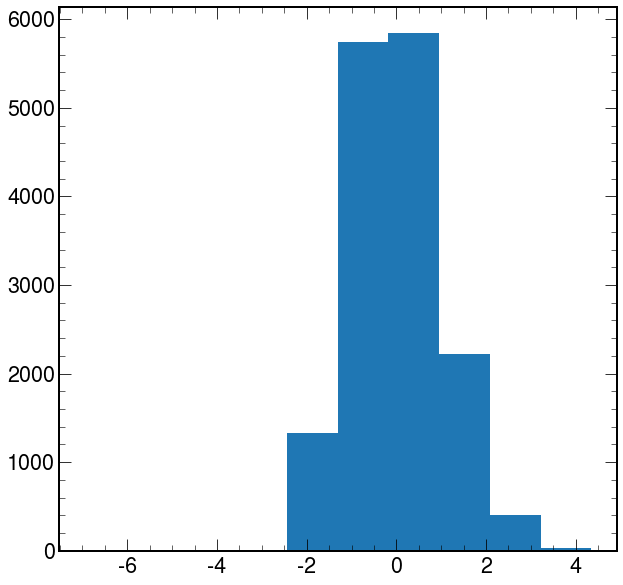

In [46]:
for a in range(1):
    plt.hist(train_inputs.numpy()[:,19])
    plt.show()

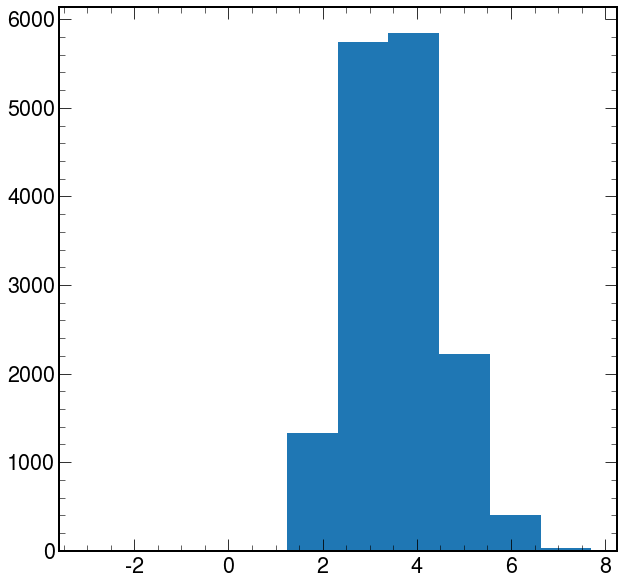

In [47]:
for a in range(19,20):
    plt.hist(scalers[a].inverse_transform(train_inputs[:,a].cpu()))
    plt.show()

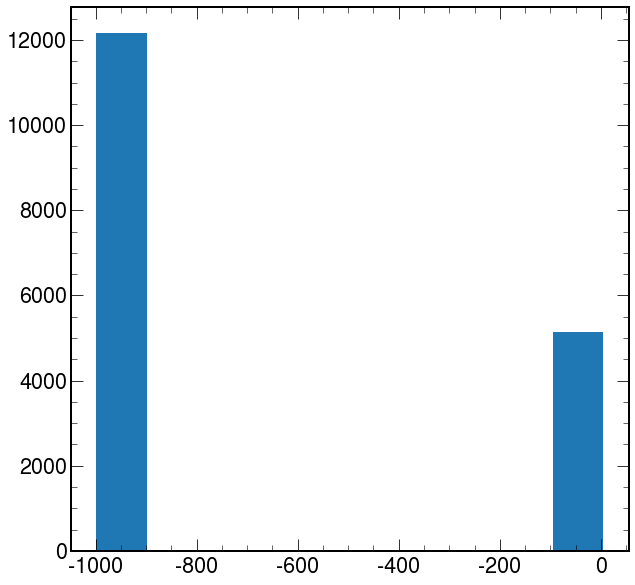

In [49]:
for a in range(1):
    plt.hist(trainingset[:,11])
    plt.show()

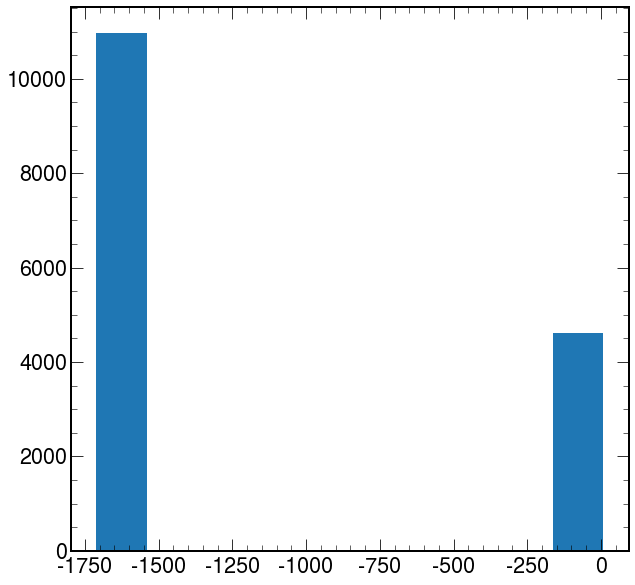

In [50]:
for a in range(1):
    plt.hist(train_inputs.numpy()[:,11])
    plt.show()

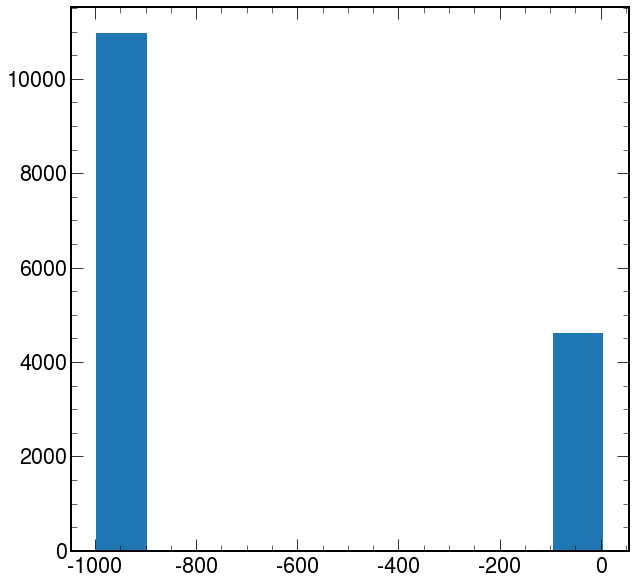

In [51]:
for a in range(11,12):
    plt.hist(scalers[a].inverse_transform(train_inputs[:,a].cpu()))
    plt.show()

## Train

In [22]:
start = time.time()




'''
parser = argparse.ArgumentParser(description="Setup for training")
parser.add_argument("files", type=int, help="Number of files for training")
parser.add_argument("prevep", type=int, help="Number of previously trained epochs")
parser.add_argument("addep", type=int, help="Number of additional epochs for this training")
parser.add_argument("wm", help="Weighting method")
args = parser.parse_args()
'''
NUM_DATASETS = 1
prev_epochs = 0
epochs = 100
weighting_method = '_as_is'




'''
    Weighting method:
        '_as_is'  :  apply no weighting factors at all
        ''        :  with factor 1 - relative frequency per flavour category
        '_new'    :  n_samples / (n_classes * n_class_count) per flavour category in loss function
        '_wrs'    :  using WeightedRandomSampler with n_samples / (n_classes * n_class_count)
'''
#weighting_method = '_as_is'    # this is now controlled by the parser above
print(f'weighting method: {weighting_method}')    

# Parameters for the training and validation    
bsize = 20000     # this might seem large, but for comparison: bsize of 250000 for 86M training inputs
lrate = 0.00001     # initial learning rate, only for first epoch
#prev_epochs = 0   # this is now controlled by the parser above

# Manually update the file path to the latest training job message
print(f'starting to train the model after {prev_epochs} epochs that were already done')
print(f'learning rate for this script: {lrate}')
print(f'batch size for this script: {bsize}')
    
#NUM_DATASETS = 229    # this is now controlled by the parser above
#NUM_DATASETS = 42
#NUM_DATASETS = 10    # just for testing

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"Setup: TT to Semileptonic samples, weighting method {weighting_method}, so far {prev_epochs} epochs done. Use lr={lrate} and bsize={bsize}.\n")


train_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
train_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_targets_%d.pt' % k for k in range(0,NUM_DATASETS)] 
val_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
val_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]    
'''


'''
# Old way to load validation samples
pre = time.time()


prepro_val_inputs = torch.cat(tuple(torch.load(vi).to(device) for vi in val_input_file_paths)).float()
print('prepro val inputs done')
prepro_val_targets = torch.cat(tuple(torch.load(vi).to(device) for vi in val_target_file_paths))
print('prepro val targets done')

post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
'''


##### LOAD TRAINING SAMPLES #####

pre = time.time()

#allin = ConcatDataset([TensorDataset(torch.load(train_input_file_paths[f]), torch.load(train_target_file_paths[f])) for f in range(NUM_DATASETS)])
allin = TensorDataset(train_inputs, train_targets)



post = time.time()
print(f"Time to load train: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")



##### LOAD VAL SAMPLES #####

pre = time.time()

#allval = ConcatDataset([TensorDataset(torch.load(val_input_file_paths[f]), torch.load(val_target_file_paths[f])) for f in range(NUM_DATASETS)])
allval = TensorDataset(val_inputs, val_targets)


post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")





pre = time.time()

if weighting_method == '_wrs':
    #weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    #samples_weights = weights[torch.concat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)])]
    #ts = torch.cat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy()
    ts = train_targets.numpy()
    class_weights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=ts)
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allin),
        replacement=True)
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, sampler=sampler, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allval),
        replacement=True)
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, sampler=sampler, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
else:
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, shuffle=True, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, shuffle=False, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")


total_len_train = len(trainloader)
total_n_train = len(trainloader.dataset)
print(total_n_train,'\ttraining samples')



total_len_val = len(valloader)
total_n_val = len(valloader.dataset)
print(total_n_val,'\tvalidation samples')


# The new method for validation inputs is needed because the total file size for validation is too big to fit on a single gpu (16GB) that is already occupied by the model / loss 
# computation graph etc..






model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

'''
if prev_epochs > 0:
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_10_epochs_v4_GPU_weighted_as_is.pt')
    model.load_state_dict(checkpoint["model_state_dict"])
'''
print(model)

'''
# In principle, one can use multiple gpu devices with DataParallel. However, in this particular case, the cons are that the data transfer takes longer, and loss / weights will be averaged
# when both results are merged. The model might be too simple to profit from this method. First tests took longer than with just one device, and the loss did not go down as fast.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
'''
model.to(device)

# Choose the parameter for weighting in the loss function, according to the choice above
if weighting_method == '':
    # as calculated in dataset_info.ipynb
    allweights = [0.7158108642980718, 0.9962305696752469, 0.9099623138559123, 0.37799625217076893]   # not for this one
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
elif weighting_method == '_new':
    allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=train_targets.numpy())
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)


if prev_epochs > 0:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    '''
    # update the learning rate to the new one
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev run')
        g['lr'] = lrate
        print('lr: ', g['lr'], 'after update')
    '''

def new_learning_rate(ep):
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev epoch')
        #g['lr'] = lrate/(1+ep/5)
        g['lr'] = 0.00001
        #print('lr: ', g['lr'], 'after update')
        
#The training algorithm

tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100

# epochs to be trained with the current script (on top of the prev_epochs)
#epochs = 1    # this is now controlled by the parser above
times = []

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"{np.floor((tic-start)/60)} min {np.ceil((tic-start)%60)} s"+' Everything prepared for main training loop.\n')
'''



for e in range(epochs):
    times.append(time.time())
    if prev_epochs+e >= 1:
        new_learning_rate(prev_epochs+e)
    running_loss = 0
    model.train()
    for b, (i,j) in enumerate(trainloader):
        if e == 0 and b == 1:
            tb1 = time.time()
            print('first batch done')
            print(f"Time for first batch: {np.floor((tb1-times[0])/60)} min {((tb1-times[0])%60)} s")
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tb1-start)/60)} min {np.ceil((tb1-start)%60)} s"+' First batch done!\n')
            '''
        i = i.to(device, non_blocking=True)
        j = j.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(i.float())
        loss = criterion(output, j)
        del i
        del j
        gc.collect()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
        del output
        gc.collect()
    else:
        del loss
        gc.collect()
        if e == 0:
            tep1 = time.time()
            print('first training epoch done, now starting first evaluation')
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tep1-start)/60)} min {np.ceil((tep1-start)%60)} s"+' First training epoch done! Start first evaluation.\n')
            '''
        with torch.no_grad():
            model.eval()
            if e > 0:
                del vloss
                del val_output
                gc.collect()
            running_val_loss = 0
            for i,j in valloader:
                i = i.to(device, non_blocking=True)
                j = j.to(device, non_blocking=True)
                val_output = model(i.float())
                vloss = criterion(val_output, j)
                del i
                del j
                gc.collect()
                vloss = vloss.item()
                running_val_loss += vloss
            '''
            # Old method to calc validation loss
            val_output = model(prepro_val_inputs)
            val_loss = criterion(val_output, prepro_val_targets)
            '''
            val_loss_history.append(running_val_loss/total_len_val)
            
            

            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if running_val_loss < min_loss:
                min_loss = running_val_loss
                stale_epochs = 0
            else:
                stale_epochs += 1
            # e+1 to count from "1" instead of "0"
            print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}",end='\n')
        loss_history.append(running_loss/total_len_train)
        #if (e+1)%np.floor(epochs/10)==0:
        #    print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {val_loss/total_len_val}")
            
        #torch.save({"epoch": prev_epochs+e, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "loss": running_loss/total_len_train, "val_loss": running_val_loss/total_len_val}, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+(e + 1)}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
toc = time.time()
#print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"used {NUM_DATASETS} files, {prev_epochs+epochs} epochs, dropout 0.1 4x, learning rate {lrate}")


#torch.save(model, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT_justModel.pt')


times.append(toc)
for p in range(epochs):
    print(f"Time for epoch {prev_epochs+p}: {np.floor((times[p+1]-times[p])/60)} min {((times[p+1]-times[p])%60)} s")
end = time.time()
print(f"Total time for whole script: {np.floor((end-start)/60)} min {np.ceil((end-start)%60)} s")



weighting method: _as_is
starting to train the model after 0 epochs that were already done
learning rate for this script: 1e-05
batch size for this script: 20000
Time to load train: 0.0 min 1.0 s
Time to load val: 0.0 min 1.0 s
Time to create trainloader: 0.0 min 1.0 s
Time to create valloader: 0.0 min 1.0 s
47379 	training samples
5265 	validation samples
Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)
first batch done
Time fo

## Plot loss

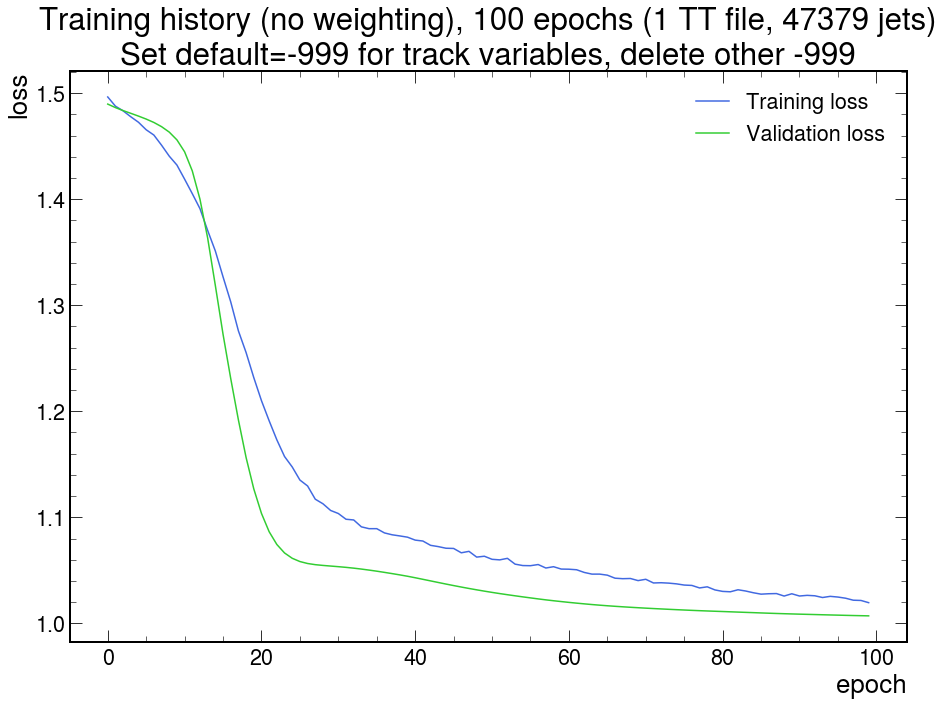

In [31]:
prev_epochs_0 = 100



NUM_DATASETS = 1


weighting_method_0 = '_as_is'

plt.figure(1,figsize=[15,10.5])
plt.plot(loss_history,color='royalblue')
plt.plot(val_loss_history,color='limegreen')
plt.title(f"Training history (no weighting), {prev_epochs_0} epochs ({NUM_DATASETS} TT file, {total_n_train} jets)\nSet default=-999 for track variables, delete other -999")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [24]:
#evaluate network on inputs
model.to(device)
test_inputs.cuda()
test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')

jetFlavour = test_targets+1

<class 'torch.Tensor'>
predictions done


In [25]:
np.unique(test_targets.numpy())

array([0, 1, 2, 3])

In [26]:
mostprob = torch.argmax(predsTensor, 1)

In [27]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[2568,    0,    0, 1207],
       [  32,    0,    0,    5],
       [ 403,    0,    0,  824],
       [ 686,    0,    0, 7437]])

In [28]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (no weighting) and DeepCSV outputs\n After 100 epochs, evaluated on 13162 jets')

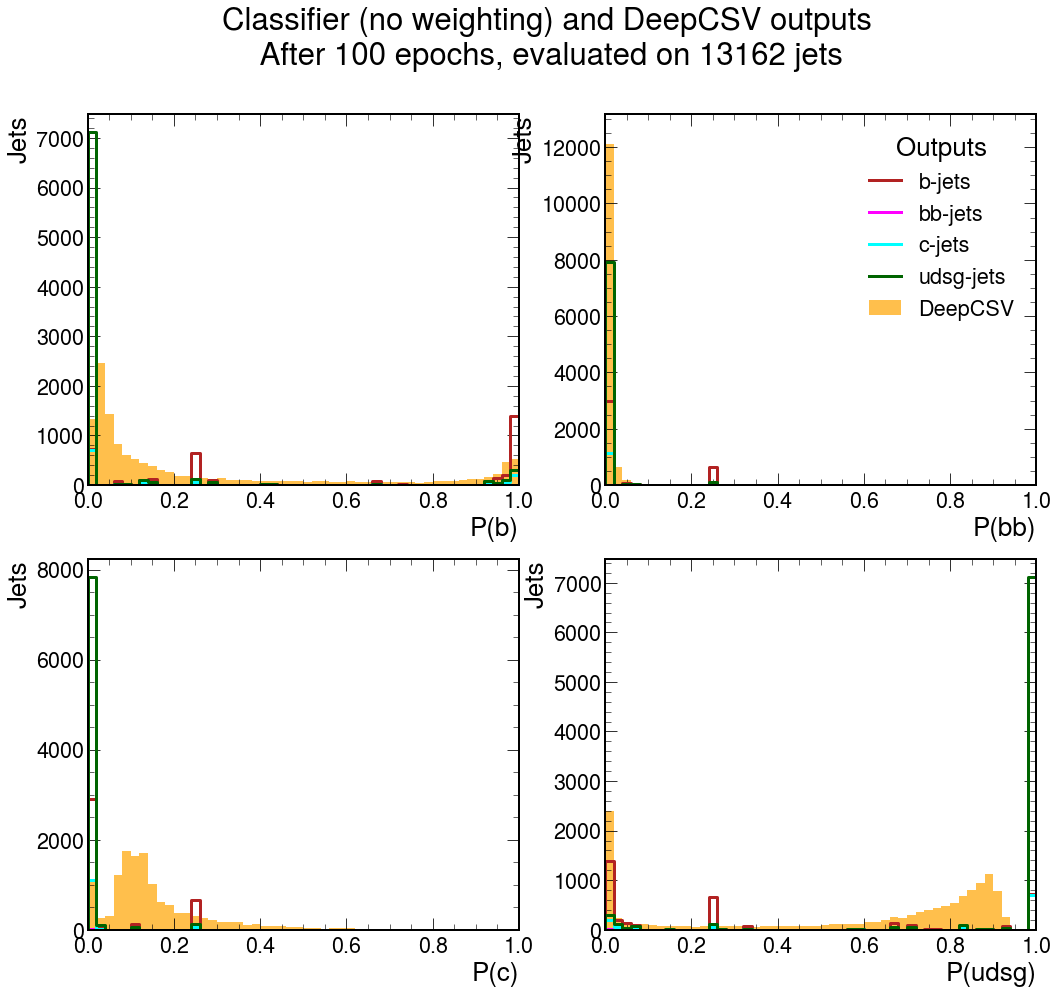

In [29]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (no weighting) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.8447169644929545
auc for bb-tagging: 0.868299613899614
auc for c-tagging: 0.5489899615855922
auc for udsg-tagging: 0.8271233486279628


22047

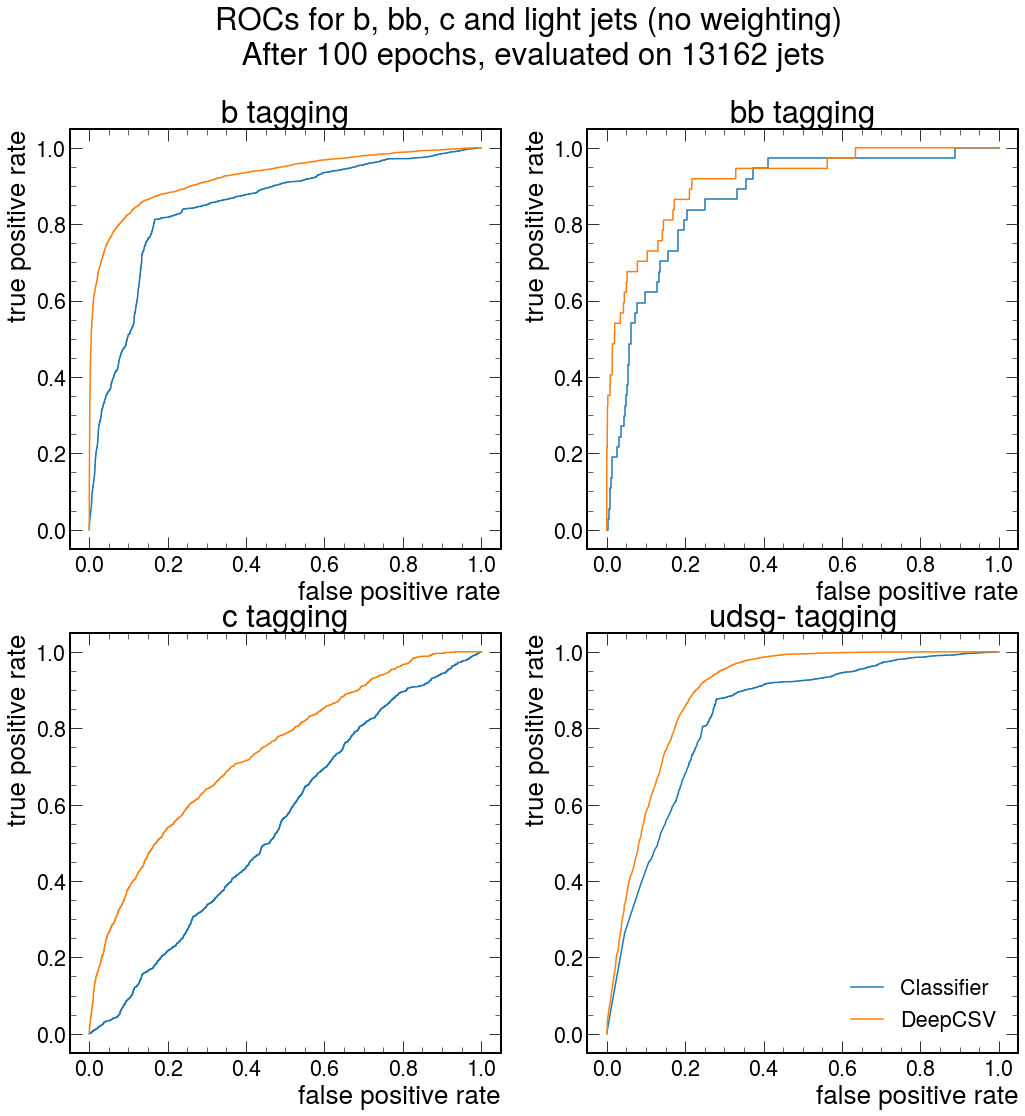

In [30]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (no weighting)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()

# Applying new ideas gained from old QCD inputs

In [9]:
def cleandataset_12pp(f):
# the feature-names are the attributes or columns of interest, in this case: information about Jets
    feature_names = [k for k in f['Events'].keys() if  (('Jet_eta' == k) or ('Jet_pt' == k) or ('Jet_DeepCSV' in k))]
    # tagger output to compare with later and variables used to get the truth output
    feature_names.extend(('Jet_btagDeepB_b','Jet_btagDeepB_bb', 'Jet_btagDeepC','Jet_btagDeepL'))
    feature_names.extend(('Jet_nBHadrons', 'Jet_hadronFlavour'))
    
    
    # go through a specified number of events, and get the information (awkward-arrays) for the keys specified above
    for data in f['Events'].iterate(feature_names, step_size=f['Events'].num_entries, library='ak'):
        break
        
    
    # creating an array to store all the columns with their entries per jet, flatten per-event -> per-jet
    datacolumns = np.zeros((len(feature_names)+1, len(ak.flatten(data['Jet_pt'], axis=1))))
   

    for featureindex in range(len(feature_names)):
        a = ak.flatten(data[feature_names[featureindex]], axis=1) # flatten along first inside to get jets
        
        datacolumns[featureindex] = ak.to_numpy(a)


    nbhad = ak.to_numpy(ak.flatten(data['Jet_nBHadrons'], axis=1))
    hadflav = ak.to_numpy(ak.flatten(data['Jet_hadronFlavour'], axis=1))

    target_class = np.full_like(hadflav, 3)                                                      # udsg
    target_class = np.where(hadflav == 4, 2, target_class)                                       # c
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad > 1), 1, target_class)            # bb
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad <= 1), 0, target_class)           # b, lepb

   

    datacolumns[len(feature_names)] = ak.to_numpy(target_class) 

    datavectors = datacolumns.transpose()
    
    
    datavectors = datavectors[datavectors[:, 3] != -999]
    
    
    for j in range(len(datavectors[0])):
        datavectors = datavectors[datavectors[:, j] != np.nan]
        datavectors = datavectors[datavectors[:, j] > -np.inf]
        datavectors = datavectors[datavectors[:, j] < np.inf]
    
    datavecak = ak.from_numpy(datavectors)
    
    #print(len(datavecak),"entries before cleaning step 1")
    
    datavecak = datavecak[datavecak[:, 67] >= 0.]
    datavecak = datavecak[datavecak[:, 67] <= 1.]
    datavecak = datavecak[datavecak[:, 68] >= 0.]
    datavecak = datavecak[datavecak[:, 68] <= 1.]
    datavecak = datavecak[datavecak[:, 69] >= 0.]
    datavecak = datavecak[datavecak[:, 69] <= 1.]
    datavecak = datavecak[datavecak[:, 70] >= 0.]
    datavecak = datavecak[datavecak[:, 70] <= 1.]

    

    # check jetNSelectedTracks, jetNSecondaryVertices > 0
    datavecak = datavecak[(datavecak[:, 63] > 0) | (datavecak[:, 64] > 0)]  # keep those where at least any of the two variables is > 0, they don't need to be > 0 simultaneously
    #print(len(datavecak),"entries after cleaning step 1")

    alldata = ak.to_numpy(datavecak)
    
        
    
    for track0_vars in [6,12,22,29,35,42,50]:
        alldata[:,track0_vars][alldata[:,64] <= 0] = -999
    for track0_1_vars in [7,13,23,30,36,43,51]:
        alldata[:,track0_1_vars][alldata[:,64] <= 1] = -999
    for track01_2_vars in [8,14,24,31,37,44,52]:
        alldata[:,track01_2_vars][alldata[:,64] <= 2] = -999
    for track012_3_vars in [9,15,25,32,38,45,53]:
        alldata[:,track012_3_vars][alldata[:,64] <= 3] = -999
    for track0123_4_vars in [10,16,26,33,39,46,54]:
        alldata[:,track0123_4_vars][alldata[:,64] <= 4] = -999
    for track01234_5_vars in [11,17,27,34,40,47,55]:
        alldata[:,track01234_5_vars][alldata[:,64] <= 5] = -999
    alldata[:,18][alldata[:,65] <= 0] = -999
    alldata[:,19][alldata[:,65] <= 1] = -999
    alldata[:,20][alldata[:,65] <= 2] = -999
    alldata[:,21][alldata[:,65] <= 3] = -999
    
    ############## DELETE DEFAULTS ###############
    
    for p in range(len(alldata[0])):
        alldata = alldata[alldata[:,p] != - 999]
    
    
    datacls = [i for i in range(0,67)]
    datacls.append(73)
    dataset = alldata[:, datacls]
    
    DeepCSV_dataset = alldata[:, 67:71]
    
    return dataset, DeepCSV_dataset

In [10]:
dataset, DeepCSV_dataset = cleandataset_12pp(uproot.open('/home/um106329/aisafety/new_march_21/rootfiles/nano_mc2017_1-1156.root'))

Text(0.5, 1.0, "True quark flavour, TT to Semileptonic Step 1 + 2''")

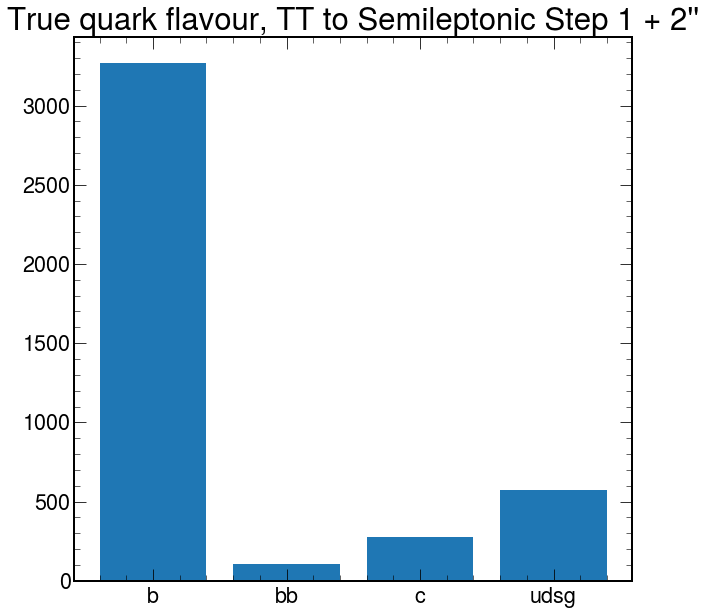

In [25]:
b = len(dataset[:,-1][dataset[:,-1] == 0])
bb = len(dataset[:,-1][dataset[:,-1] == 1])
c = len(dataset[:,-1][dataset[:,-1] == 2])
l = len(dataset[:,-1][dataset[:,-1] == 3])
plt.bar(labels, [b, bb, c, l])
plt.xticks(labels, categories)
plt.title('True quark flavour, TT to Semileptonic Step 1 + 2\'\'')

## Preprocess (scale)

In [11]:
trainingset,testset,_,DeepCSV_testset = train_test_split(dataset, DeepCSV_dataset, test_size=0.2, random_state=1)
trainset, valset = train_test_split(trainingset,test_size=0.1, random_state=1)


test_inputs = torch.Tensor(testset[:,0:67])                                                
test_targets = (torch.Tensor([testset[i][-1] for i in range(len(testset))])).long()        
val_inputs = torch.Tensor(valset[:,0:67])
val_targets = (torch.Tensor([valset[i][-1] for i in range(len(valset))]).long())
train_inputs = torch.Tensor(trainset[:,0:67])
train_targets = (torch.Tensor([trainset[i][-1] for i in range(len(trainset))])).long()



norm_train_inputs,norm_val_inputs,norm_test_inputs = train_inputs.clone().detach(),val_inputs.clone().detach(),test_inputs.clone().detach()
scalers = []

for i in range(0,67): # do not apply scaling to default values, which were set to -999
    scaler = StandardScaler().fit(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1))
    '''
    norm_train_inputs[:,i][train_inputs[:,i]!=-999]   = torch.Tensor(scaler.transform(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i][val_inputs[:,i]!=-999]       = torch.Tensor(scaler.transform(val_inputs[:,i][val_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i][test_inputs[:,i]!=-999]     = torch.Tensor(scaler.transform(test_inputs[:,i][test_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    '''
    norm_train_inputs[:,i]   = torch.Tensor(scaler.transform(train_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i]     = torch.Tensor(scaler.transform(val_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i]    = torch.Tensor(scaler.transform(test_inputs[:,i].reshape(-1,1)).reshape(1,-1))

    scalers.append(scaler)


train_inputs = norm_train_inputs.clone().detach().to(torch.float16)
val_inputs = norm_val_inputs.clone().detach().to(torch.float16)
test_inputs = norm_test_inputs.clone().detach().to(torch.float16)


## Train

In [12]:
start = time.time()




'''
parser = argparse.ArgumentParser(description="Setup for training")
parser.add_argument("files", type=int, help="Number of files for training")
parser.add_argument("prevep", type=int, help="Number of previously trained epochs")
parser.add_argument("addep", type=int, help="Number of additional epochs for this training")
parser.add_argument("wm", help="Weighting method")
args = parser.parse_args()
'''
NUM_DATASETS = 1
prev_epochs = 0
epochs = 100
weighting_method = '_new'




'''
    Weighting method:
        '_as_is'  :  apply no weighting factors at all
        ''        :  with factor 1 - relative frequency per flavour category
        '_new'    :  n_samples / (n_classes * n_class_count) per flavour category in loss function
        '_wrs'    :  using WeightedRandomSampler with n_samples / (n_classes * n_class_count)
'''
#weighting_method = '_as_is'    # this is now controlled by the parser above
print(f'weighting method: {weighting_method}')    

# Parameters for the training and validation    
bsize = 200     # this might seem large, but for comparison: bsize of 250000 for 86M training inputs
lrate = 0.0001     # initial learning rate, only for first epoch
#prev_epochs = 0   # this is now controlled by the parser above

# Manually update the file path to the latest training job message
print(f'starting to train the model after {prev_epochs} epochs that were already done')
print(f'learning rate for this script: {lrate}')
print(f'batch size for this script: {bsize}')
    
#NUM_DATASETS = 229    # this is now controlled by the parser above
#NUM_DATASETS = 42
#NUM_DATASETS = 10    # just for testing

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"Setup: TT to Semileptonic samples, weighting method {weighting_method}, so far {prev_epochs} epochs done. Use lr={lrate} and bsize={bsize}.\n")


train_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
train_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_targets_%d.pt' % k for k in range(0,NUM_DATASETS)] 
val_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
val_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]    
'''


'''
# Old way to load validation samples
pre = time.time()


prepro_val_inputs = torch.cat(tuple(torch.load(vi).to(device) for vi in val_input_file_paths)).float()
print('prepro val inputs done')
prepro_val_targets = torch.cat(tuple(torch.load(vi).to(device) for vi in val_target_file_paths))
print('prepro val targets done')

post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
'''


##### LOAD TRAINING SAMPLES #####

pre = time.time()

#allin = ConcatDataset([TensorDataset(torch.load(train_input_file_paths[f]), torch.load(train_target_file_paths[f])) for f in range(NUM_DATASETS)])
allin = TensorDataset(train_inputs, train_targets)



post = time.time()
print(f"Time to load train: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")



##### LOAD VAL SAMPLES #####

pre = time.time()

#allval = ConcatDataset([TensorDataset(torch.load(val_input_file_paths[f]), torch.load(val_target_file_paths[f])) for f in range(NUM_DATASETS)])
allval = TensorDataset(val_inputs, val_targets)


post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")





pre = time.time()

if weighting_method == '_wrs':
    #weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    #samples_weights = weights[torch.concat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)])]
    #ts = torch.cat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy()
    ts = train_targets.numpy()
    class_weights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=ts)
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allin),
        replacement=True)
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, sampler=sampler, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allval),
        replacement=True)
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, sampler=sampler, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
else:
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, shuffle=True, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, shuffle=False, num_workers=0, pin_memory=True)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")


total_len_train = len(trainloader)
total_n_train = len(trainloader.dataset)
print(total_n_train,'\ttraining samples')



total_len_val = len(valloader)
total_n_val = len(valloader.dataset)
print(total_n_val,'\tvalidation samples')


# The new method for validation inputs is needed because the total file size for validation is too big to fit on a single gpu (16GB) that is already occupied by the model / loss 
# computation graph etc..






model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

'''
if prev_epochs > 0:
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_10_epochs_v4_GPU_weighted_as_is.pt')
    model.load_state_dict(checkpoint["model_state_dict"])
'''
print(model)

'''
# In principle, one can use multiple gpu devices with DataParallel. However, in this particular case, the cons are that the data transfer takes longer, and loss / weights will be averaged
# when both results are merged. The model might be too simple to profit from this method. First tests took longer than with just one device, and the loss did not go down as fast.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
'''
model.to(device)

# Choose the parameter for weighting in the loss function, according to the choice above
if weighting_method == '':
    # as calculated in dataset_info.ipynb
    allweights = [0.7158108642980718, 0.9962305696752469, 0.9099623138559123, 0.37799625217076893]   # not for this one
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
elif weighting_method == '_new':
    allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=train_targets.numpy())
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)


if prev_epochs > 0:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    '''
    # update the learning rate to the new one
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev run')
        g['lr'] = lrate
        print('lr: ', g['lr'], 'after update')
    '''

def new_learning_rate(ep):
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev epoch')
        g['lr'] = lrate/(1+ep/5)
        #g['lr'] = 0.00001
        #print('lr: ', g['lr'], 'after update')
        
#The training algorithm

tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100

# epochs to be trained with the current script (on top of the prev_epochs)
#epochs = 1    # this is now controlled by the parser above
times = []

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"{np.floor((tic-start)/60)} min {np.ceil((tic-start)%60)} s"+' Everything prepared for main training loop.\n')
'''



for e in range(epochs):
    times.append(time.time())
    if prev_epochs+e >= 1:
        new_learning_rate(prev_epochs+e)
    running_loss = 0
    model.train()
    for b, (i,j) in enumerate(trainloader):
        if e == 0 and b == 1:
            tb1 = time.time()
            print('first batch done')
            print(f"Time for first batch: {np.floor((tb1-times[0])/60)} min {((tb1-times[0])%60)} s")
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tb1-start)/60)} min {np.ceil((tb1-start)%60)} s"+' First batch done!\n')
            '''
        i = i.to(device, non_blocking=True)
        j = j.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(i.float())
        loss = criterion(output, j)
        del i
        del j
        gc.collect()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
        del output
        gc.collect()
    else:
        del loss
        gc.collect()
        if e == 0:
            tep1 = time.time()
            print('first training epoch done, now starting first evaluation')
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tep1-start)/60)} min {np.ceil((tep1-start)%60)} s"+' First training epoch done! Start first evaluation.\n')
            '''
        with torch.no_grad():
            model.eval()
            if e > 0:
                del vloss
                del val_output
                gc.collect()
            running_val_loss = 0
            for i,j in valloader:
                i = i.to(device, non_blocking=True)
                j = j.to(device, non_blocking=True)
                val_output = model(i.float())
                vloss = criterion(val_output, j)
                del i
                del j
                gc.collect()
                vloss = vloss.item()
                running_val_loss += vloss
            '''
            # Old method to calc validation loss
            val_output = model(prepro_val_inputs)
            val_loss = criterion(val_output, prepro_val_targets)
            '''
            val_loss_history.append(running_val_loss/total_len_val)
            
            

            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if running_val_loss < min_loss:
                min_loss = running_val_loss
                stale_epochs = 0
            else:
                stale_epochs += 1
            # e+1 to count from "1" instead of "0"
            print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}",end='\n')
        loss_history.append(running_loss/total_len_train)
        #if (e+1)%np.floor(epochs/10)==0:
        #    print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {val_loss/total_len_val}")
            
        #torch.save({"epoch": prev_epochs+e, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "loss": running_loss/total_len_train, "val_loss": running_val_loss/total_len_val}, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+(e + 1)}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
toc = time.time()
#print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"used {NUM_DATASETS} files, {prev_epochs+epochs} epochs, dropout 0.1 4x, learning rate {lrate}")


#torch.save(model, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT_justModel.pt')


times.append(toc)
for p in range(epochs):
    print(f"Time for epoch {prev_epochs+p}: {np.floor((times[p+1]-times[p])/60)} min {((times[p+1]-times[p])%60)} s")
end = time.time()
print(f"Total time for whole script: {np.floor((end-start)/60)} min {np.ceil((end-start)%60)} s")



weighting method: _new
starting to train the model after 0 epochs that were already done
learning rate for this script: 0.0001
batch size for this script: 200
Time to load train: 0.0 min 1.0 s
Time to load val: 0.0 min 1.0 s
Time to create trainloader: 0.0 min 1.0 s
Time to create valloader: 0.0 min 1.0 s
3042 	training samples
338 	validation samples
Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)
first batch done
Time for fir

## Plot loss

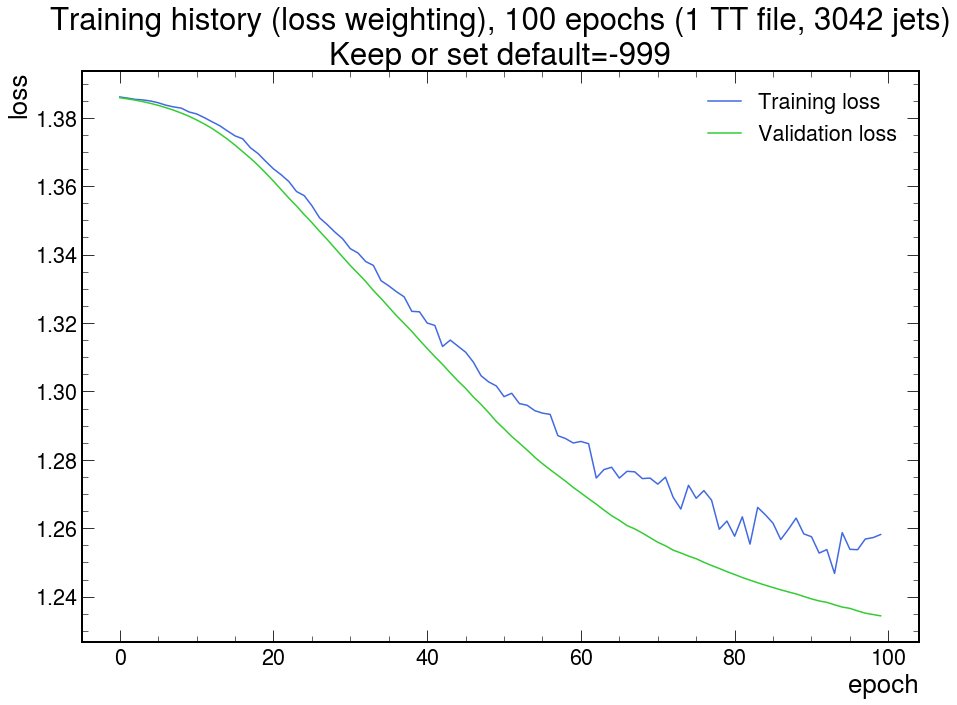

In [13]:
prev_epochs_0 = 100



NUM_DATASETS = 1


weighting_method_0 = '_new'

plt.figure(1,figsize=[15,10.5])
plt.plot(loss_history,color='royalblue')
plt.plot(val_loss_history,color='limegreen')
plt.title(f"Training history (loss weighting), {prev_epochs_0} epochs ({NUM_DATASETS} TT file, {total_n_train} jets)\nKeep or set default=-999")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [14]:
#evaluate network on inputs
model.to(device)
test_inputs.cuda()
test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')

jetFlavour = test_targets+1

<class 'torch.Tensor'>
predictions done


In [15]:
np.unique(test_targets.numpy())

array([0, 1, 2, 3])

In [16]:
mostprob = torch.argmax(predsTensor, 1)

In [17]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[242, 188,   0, 235],
       [  4,  11,   0,   5],
       [  2,   7,   0,  35],
       [  2,  11,   0, 104]])

In [18]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (loss weighting) and DeepCSV outputs\n After 100 epochs, evaluated on 846 jets')

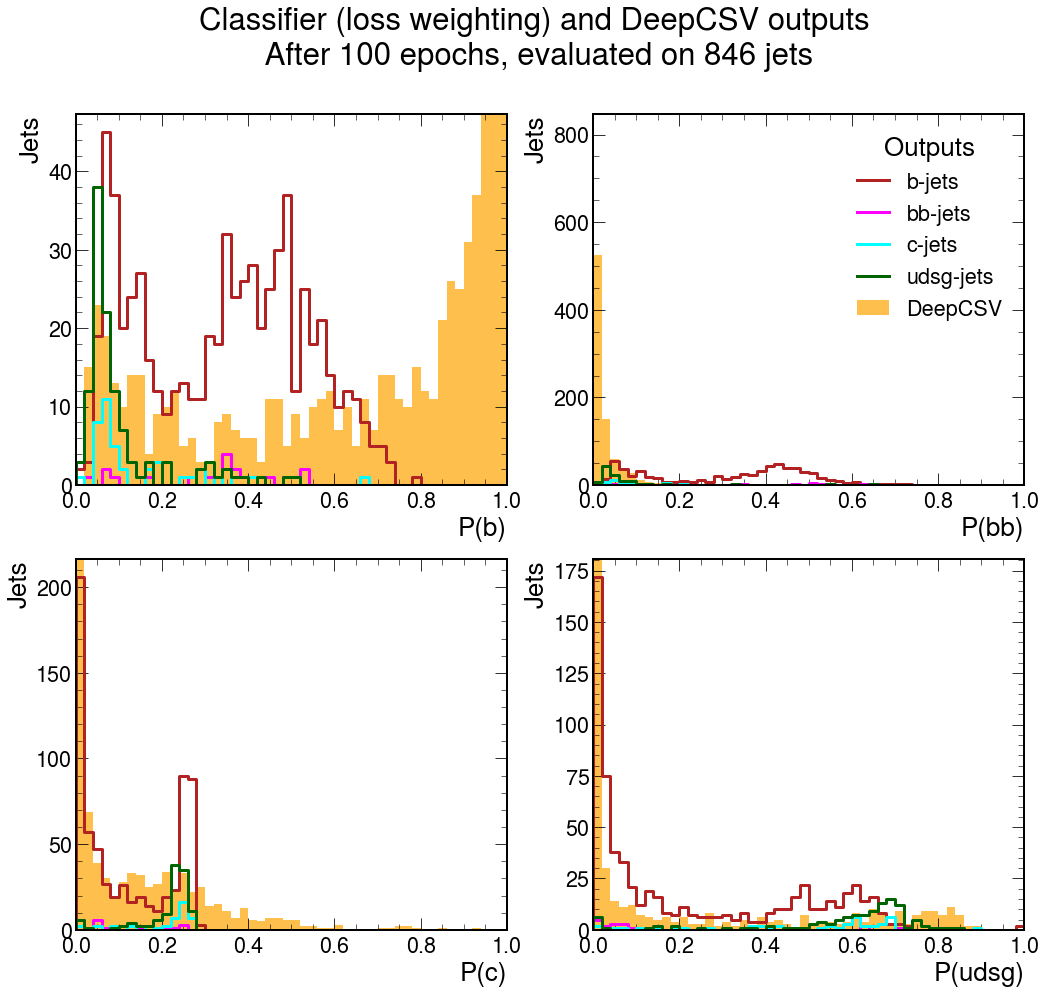

In [19]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (loss weighting) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.8222988410252149
auc for bb-tagging: 0.6967917675544795
auc for c-tagging: 0.680457946043981
auc for udsg-tagging: 0.8531766967980959


2905

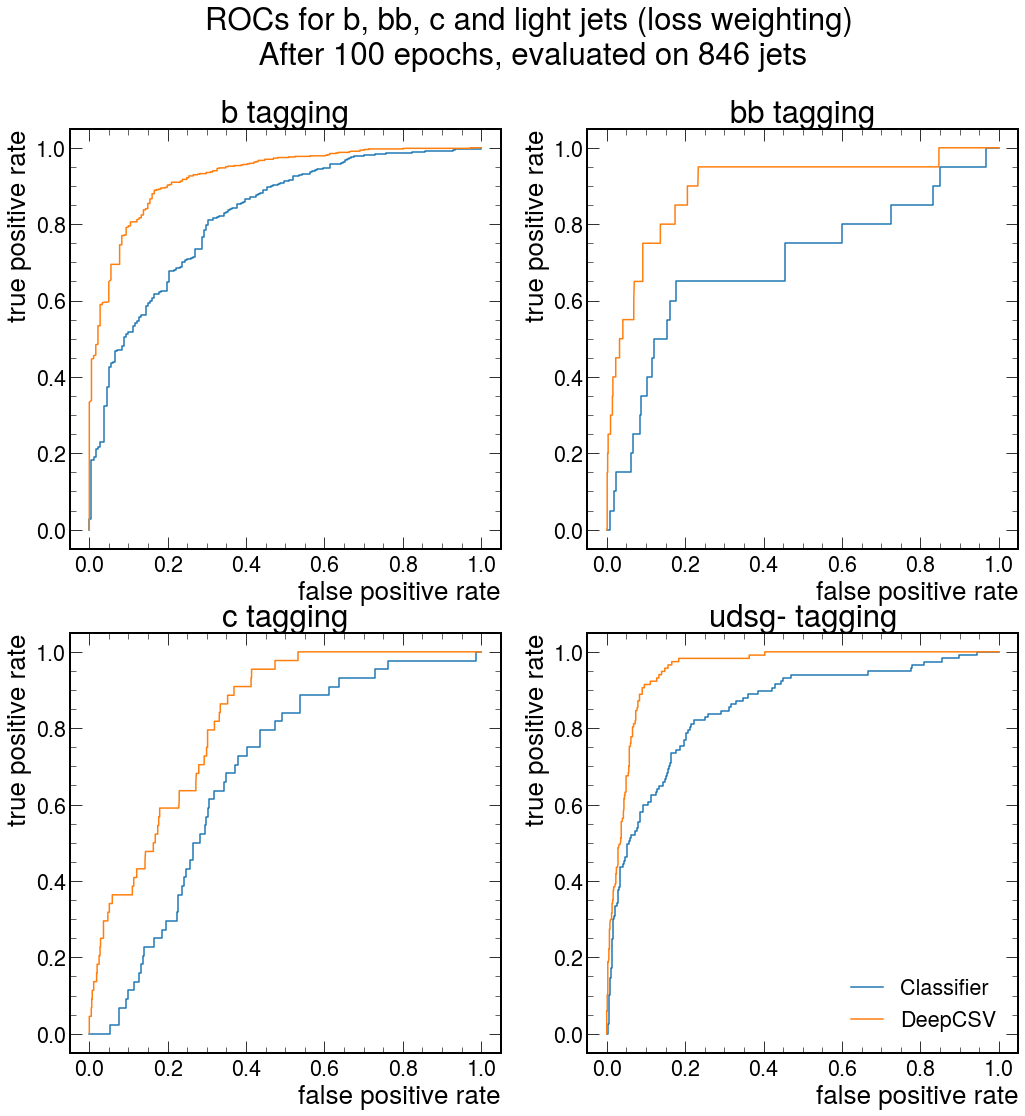

In [20]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (loss weighting)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()

In [9]:
NUM_DATASETS = 3
test_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/test_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]


test_inputs = torch.cat(tuple(torch.load(ti) for ti in test_input_file_paths)).float()
print('test inputs done')
len_test = len(test_inputs)
print('number of test inputs', len_test)

test_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/test_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]
DeepCSV_testset_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/DeepCSV_testset_%d.pt' % k for k in range(0,NUM_DATASETS)]

test_targets = torch.cat(tuple(torch.load(ti) for ti in test_target_file_paths)).float()
print('test targets done')
DeepCSV_testset = np.concatenate([torch.load(ti) for ti in DeepCSV_testset_file_paths])
print('DeepCSV test done')

jetFlavour = test_targets+1


test inputs done
number of test inputs 2214897
test targets done
DeepCSV test done


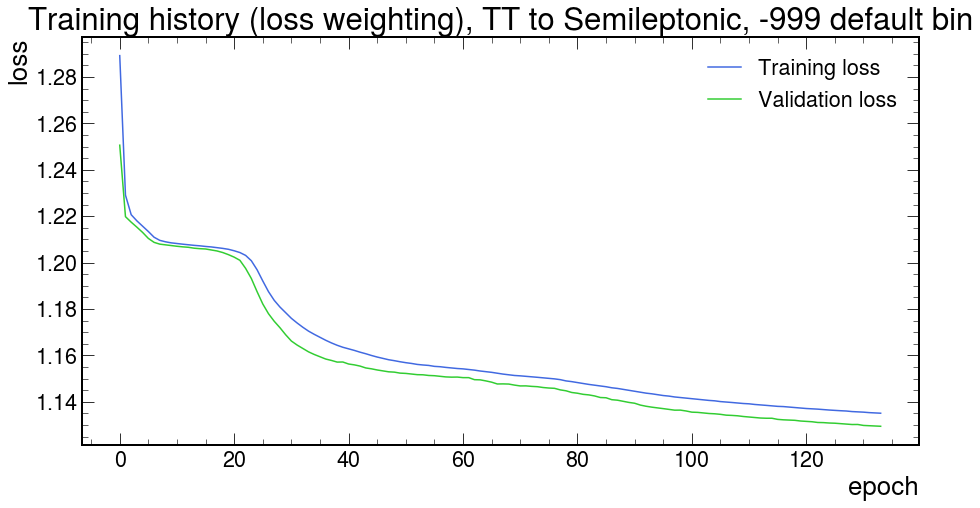

In [10]:
prev_epochs_0 = 134

all_tr_losses_0 = []
all_val_losses_0 = []


for i in range(1, prev_epochs_0+1):
    checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/model_all_TT_{i}_epochs_v10_GPU_weighted_new_49_datasets.pt', map_location=torch.device(device))
    loss = checkpoint['loss']
    all_tr_losses_0.append(loss)
    val_loss = checkpoint['val_loss']
    all_val_losses_0.append(val_loss)
    
    
plt.figure(1,figsize=[15,7.5])
plt.plot(all_tr_losses_0,color='royalblue')
plt.plot(all_val_losses_0,color='limegreen')
plt.title(f"Training history (loss weighting), TT to Semileptonic, -999 default bin")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [11]:
allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=test_targets.numpy())
class_weights = torch.FloatTensor(allweights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [12]:
model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/model_all_TT_134_epochs_v10_GPU_weighted_new_49_datasets.pt', map_location=torch.device(device))
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [22]:
model2 = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/model_all_TT_125_epochs_v10_GPU_weighted_new_49_datasets.pt', map_location=torch.device(device))
model2.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [11]:
del predictions
del predsTensor
gc.collect()

NameError: name 'predictions' is not defined

In [15]:
#evaluate network on inputs
model.to(device)
#test_inputs.cuda()
#test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')


<class 'torch.Tensor'>
predictions done


In [16]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [17]:
mostprob = torch.argmax(predsTensor, 1)

In [18]:
cfm = metrics.confusion_matrix(test_targets.view(-1).cpu(), mostprob.view(-1).cpu())
#cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[ 345994,  108477,  107814,   67009],
       [   1601,    5692,     648,     395],
       [  26135,   12638,   79031,   81194],
       [  27973,   30566,  253766, 1065964]])

In [19]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (loss weighting) and DeepCSV outputs\n After 134 epochs, evaluated on 2214897 jets')

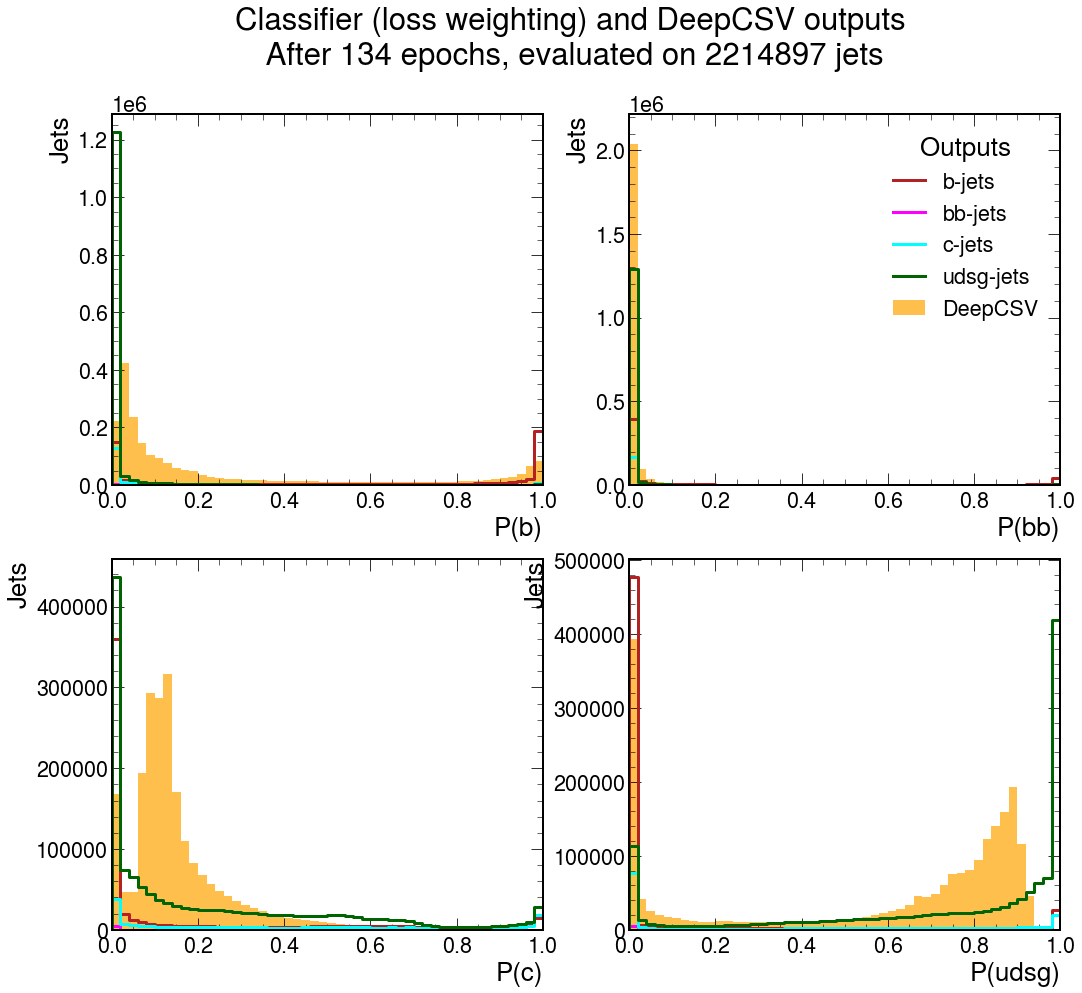

In [20]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (loss weighting) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.8714857108209261
auc for bb-tagging: 0.8992630476445946
auc for c-tagging: 0.6808377892891145
auc for udsg-tagging: 0.8778449468526974


936

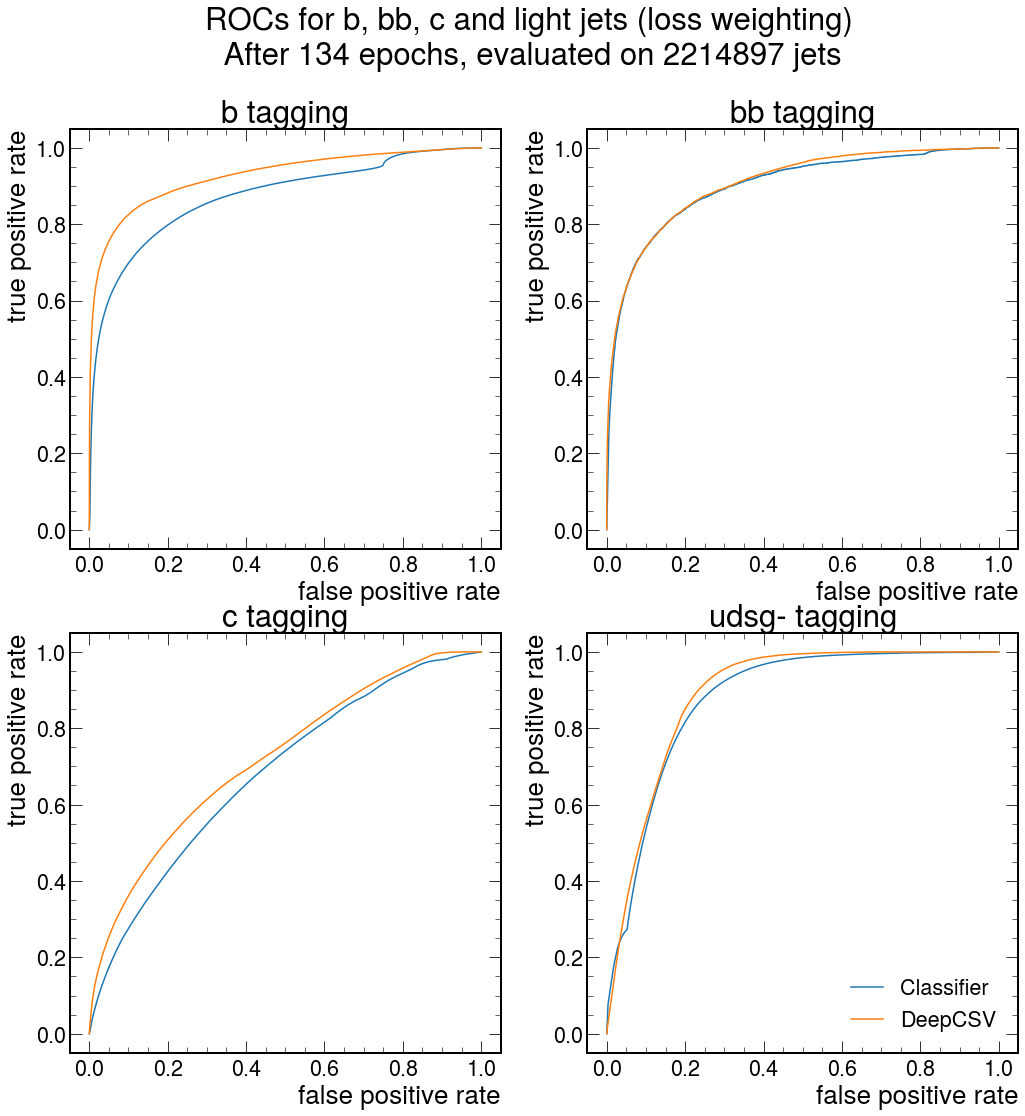

In [21]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (loss weighting)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()

In [22]:
BvsUDSG_inputs = torch.cat((test_inputs[jetFlavour==1],test_inputs[jetFlavour==4]))
#del gc.garbage[:]
#del test_inputs
BvsUDSG_targets = torch.cat((test_targets[jetFlavour==1],test_targets[jetFlavour==4]))
#del test_targets

BvsUDSG_predictions = np.concatenate((predictions[jetFlavour==1],predictions[jetFlavour==4]))
#del predictions_new
BvsUDSG_DeepCSV = np.concatenate((DeepCSV_testset[jetFlavour==1],DeepCSV_testset[jetFlavour==4]))
#del DeepCSV_testset
gc.collect()

32

auc for B vs UDSG loss weighting: 0.8875028510358155
auc for B vs UDSG DeepCSV: 0.9377495882437985


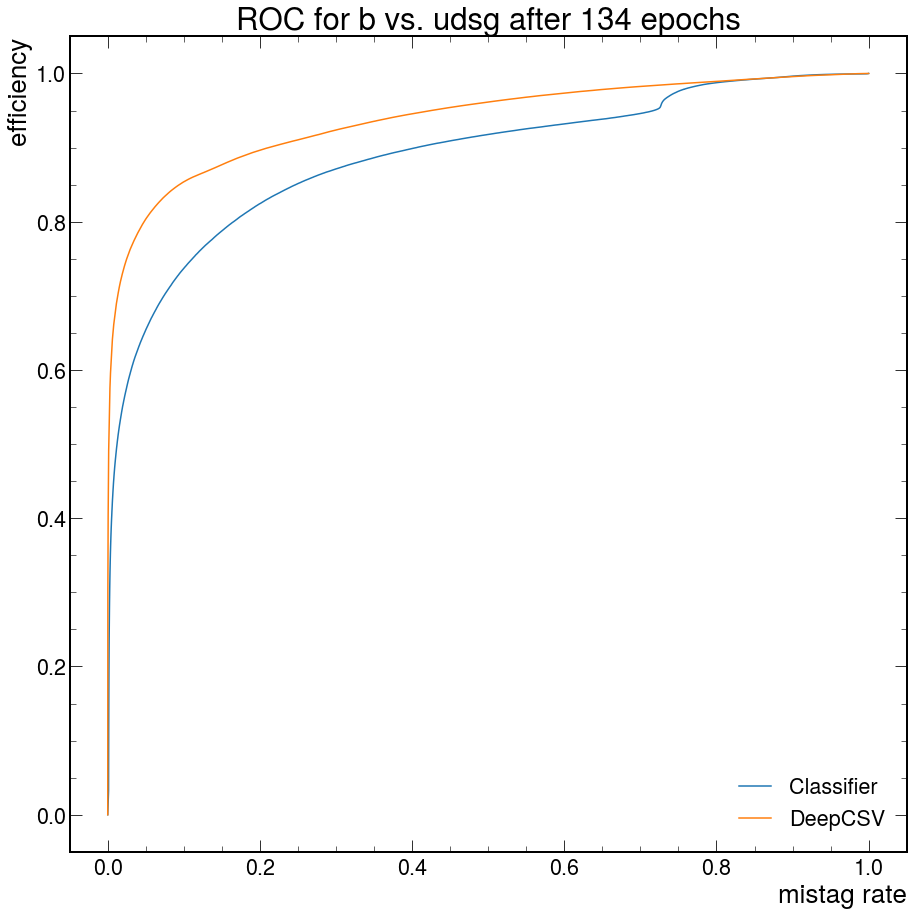

In [24]:
at_epoch = 134
fig = plt.figure(figsize=[15,15],num=40)
fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],BvsUDSG_predictions[:,0])
plt.plot(fpr,tpr)
print(f"auc for B vs UDSG loss weighting: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],BvsUDSG_DeepCSV[:,0])
plt.plot(fpr,tpr)
print(f"auc for B vs UDSG DeepCSV: {metrics.auc(fpr,tpr)}")
plt.xlabel('mistag rate')
plt.ylabel('efficiency')
plt.title(f'ROC for b vs. udsg after {at_epoch} epochs')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.legend(['Classifier', 'DeepCSV'],loc='lower right')



In [27]:
display_names = ['Jet $\eta$',
                'Jet $p_T$',
                'Flight Distance 2D Sig','Flight Distance 2D Val','Flight Distance 3D Sig', 'Flight Distance 3D Val',
                'Track Decay Len Val [0]','Track Decay Len Val [1]','Track Decay Len Val [2]','Track Decay Len Val [3]','Track Decay Len Val [4]','Track Decay Len Val [5]',
                'Track $\Delta R$ [0]','Track $\Delta R$ [1]','Track $\Delta R$ [2]','Track $\Delta R$ [3]','Track $\Delta R$ [4]','Track $\Delta R$ [5]',
                'Track $\eta_{rel}$ [0]','Track $\eta_{rel}$ [1]','Track $\eta_{rel}$ [2]','Track $\eta_{rel}$ [3]',
                'Track Jet Dist Val [0]','Track Jet Dist Val [1]','Track Jet Dist Val [2]','Track Jet Dist Val [3]','Track Jet Dist Val [4]','Track Jet Dist Val [5]',
                'Track Jet $p_T$',
                'Track $p_T$ Ratio [0]','Track $p_T$ Ratio [1]','Track $p_T$ Ratio [2]','Track $p_T$ Ratio [3]','Track $p_T$ Ratio [4]','Track $p_T$ Ratio [5]',
                'Track $p_{T,rel}$ [0]','Track $p_{T,rel}$ [1]','Track $p_{T,rel}$ [2]','Track $p_{T,rel}$ [3]','Track $p_{T,rel}$ [4]','Track $p_{T,rel}$ [5]',
                'Track SIP 2D Sig Above Charm',
                'Track SIP 2D Sig [0]','Track SIP 2D Sig [1]','Track SIP 2D Sig [2]','Track SIP 2D Sig [3]','Track SIP 2D Sig [4]','Track SIP 2D Sig [5]',
                'Track SIP 2D Val Above Charm',
                'Track SIP 3D Sig Above Charm',
                'Track SIP 3D Sig [0]','Track SIP 3D Sig [1]','Track SIP 3D Sig [2]','Track SIP 3D Sig [3]','Track SIP 3D Sig [4]','Track SIP 3D Sig [5]',
                'Track SIP 3D Val Above Charm',
                'Track Sum Jet $\Delta R$','Track Sum Jet $E_T$ Ratio',
                'Vertex Category','Vertex Energy Ratio','Vertex Jet $\Delta R$','Vertex Mass',
                'Jet N Secondary Vertices','Jet N Selected Tracks','Jet N Tracks $\eta_{rel}$','Vertex N Tracks']

In [18]:
test_inputsNP = test_inputs.cpu().numpy()
flav = jetFlavour.numpy().astype(int)
test_inputsNP = np.c_[test_inputsNP, flav]

In [22]:
list_variables = []
list_auc_bvl = []
list_auc_bvc = []

for deepcsv_input in range(67):
    
    bvl = test_inputsNP[test_inputsNP[:,-1] != 3]
    y_true_bvl = bvl[:,-1] != 4
    y_pred_bvl = bvl[:,deepcsv_input]
        
    bvc = test_inputsNP[test_inputsNP[:,-1] != 4]
    y_true_bvc = bvc[:,-1] != 3
    y_pred_bvc = bvc[:,deepcsv_input]
    
    
    auc_bvl = roc_auc_score(y_true_bvl, y_pred_bvl)
    auc_bvc = roc_auc_score(y_true_bvc, y_pred_bvc)
    
    print(f'Variable: {display_names[deepcsv_input]}, AUC bvl: {auc_bvl}, AUC bvc: {auc_bvc}')
    
    list_variables.append(display_names[deepcsv_input])
    list_auc_bvl.append(auc_bvl)
    list_auc_bvc.append(auc_bvc)
    
df = pd.DataFrame(list(zip(list_variables, list_auc_bvl, list_auc_bvc)), columns =['input_name', 'auc_bvl', 'auc_bvc'])

Variable: Jet $\eta$, AUC bvl: 0.5021581984129472, AUC bvc: 0.502618327881813
Variable: Jet $p_T$, AUC bvl: 0.6933051171594562, AUC bvc: 0.5882750529433391
Variable: Flight Distance 2D Sig, AUC bvl: 0.8572980013572586, AUC bvc: 0.7565226548231393
Variable: Flight Distance 2D Val, AUC bvl: 0.8471719718282751, AUC bvc: 0.7265327528138185
Variable: Flight Distance 3D Sig, AUC bvl: 0.8573793794229596, AUC bvc: 0.7567586868212033
Variable: Flight Distance 3D Val, AUC bvl: 0.8424976928678103, AUC bvc: 0.7225097459938895
Variable: Track Decay Len Val [0], AUC bvl: 0.7737423394707847, AUC bvc: 0.6981510163426727
Variable: Track Decay Len Val [1], AUC bvl: 0.7734906469389824, AUC bvc: 0.6814150328539551
Variable: Track Decay Len Val [2], AUC bvl: 0.7179904467628583, AUC bvc: 0.629527091609884
Variable: Track Decay Len Val [3], AUC bvl: 0.6650549798822603, AUC bvc: 0.5914872875116787
Variable: Track Decay Len Val [4], AUC bvl: 0.6152457897307446, AUC bvc: 0.5633970183215496
Variable: Track Decay

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


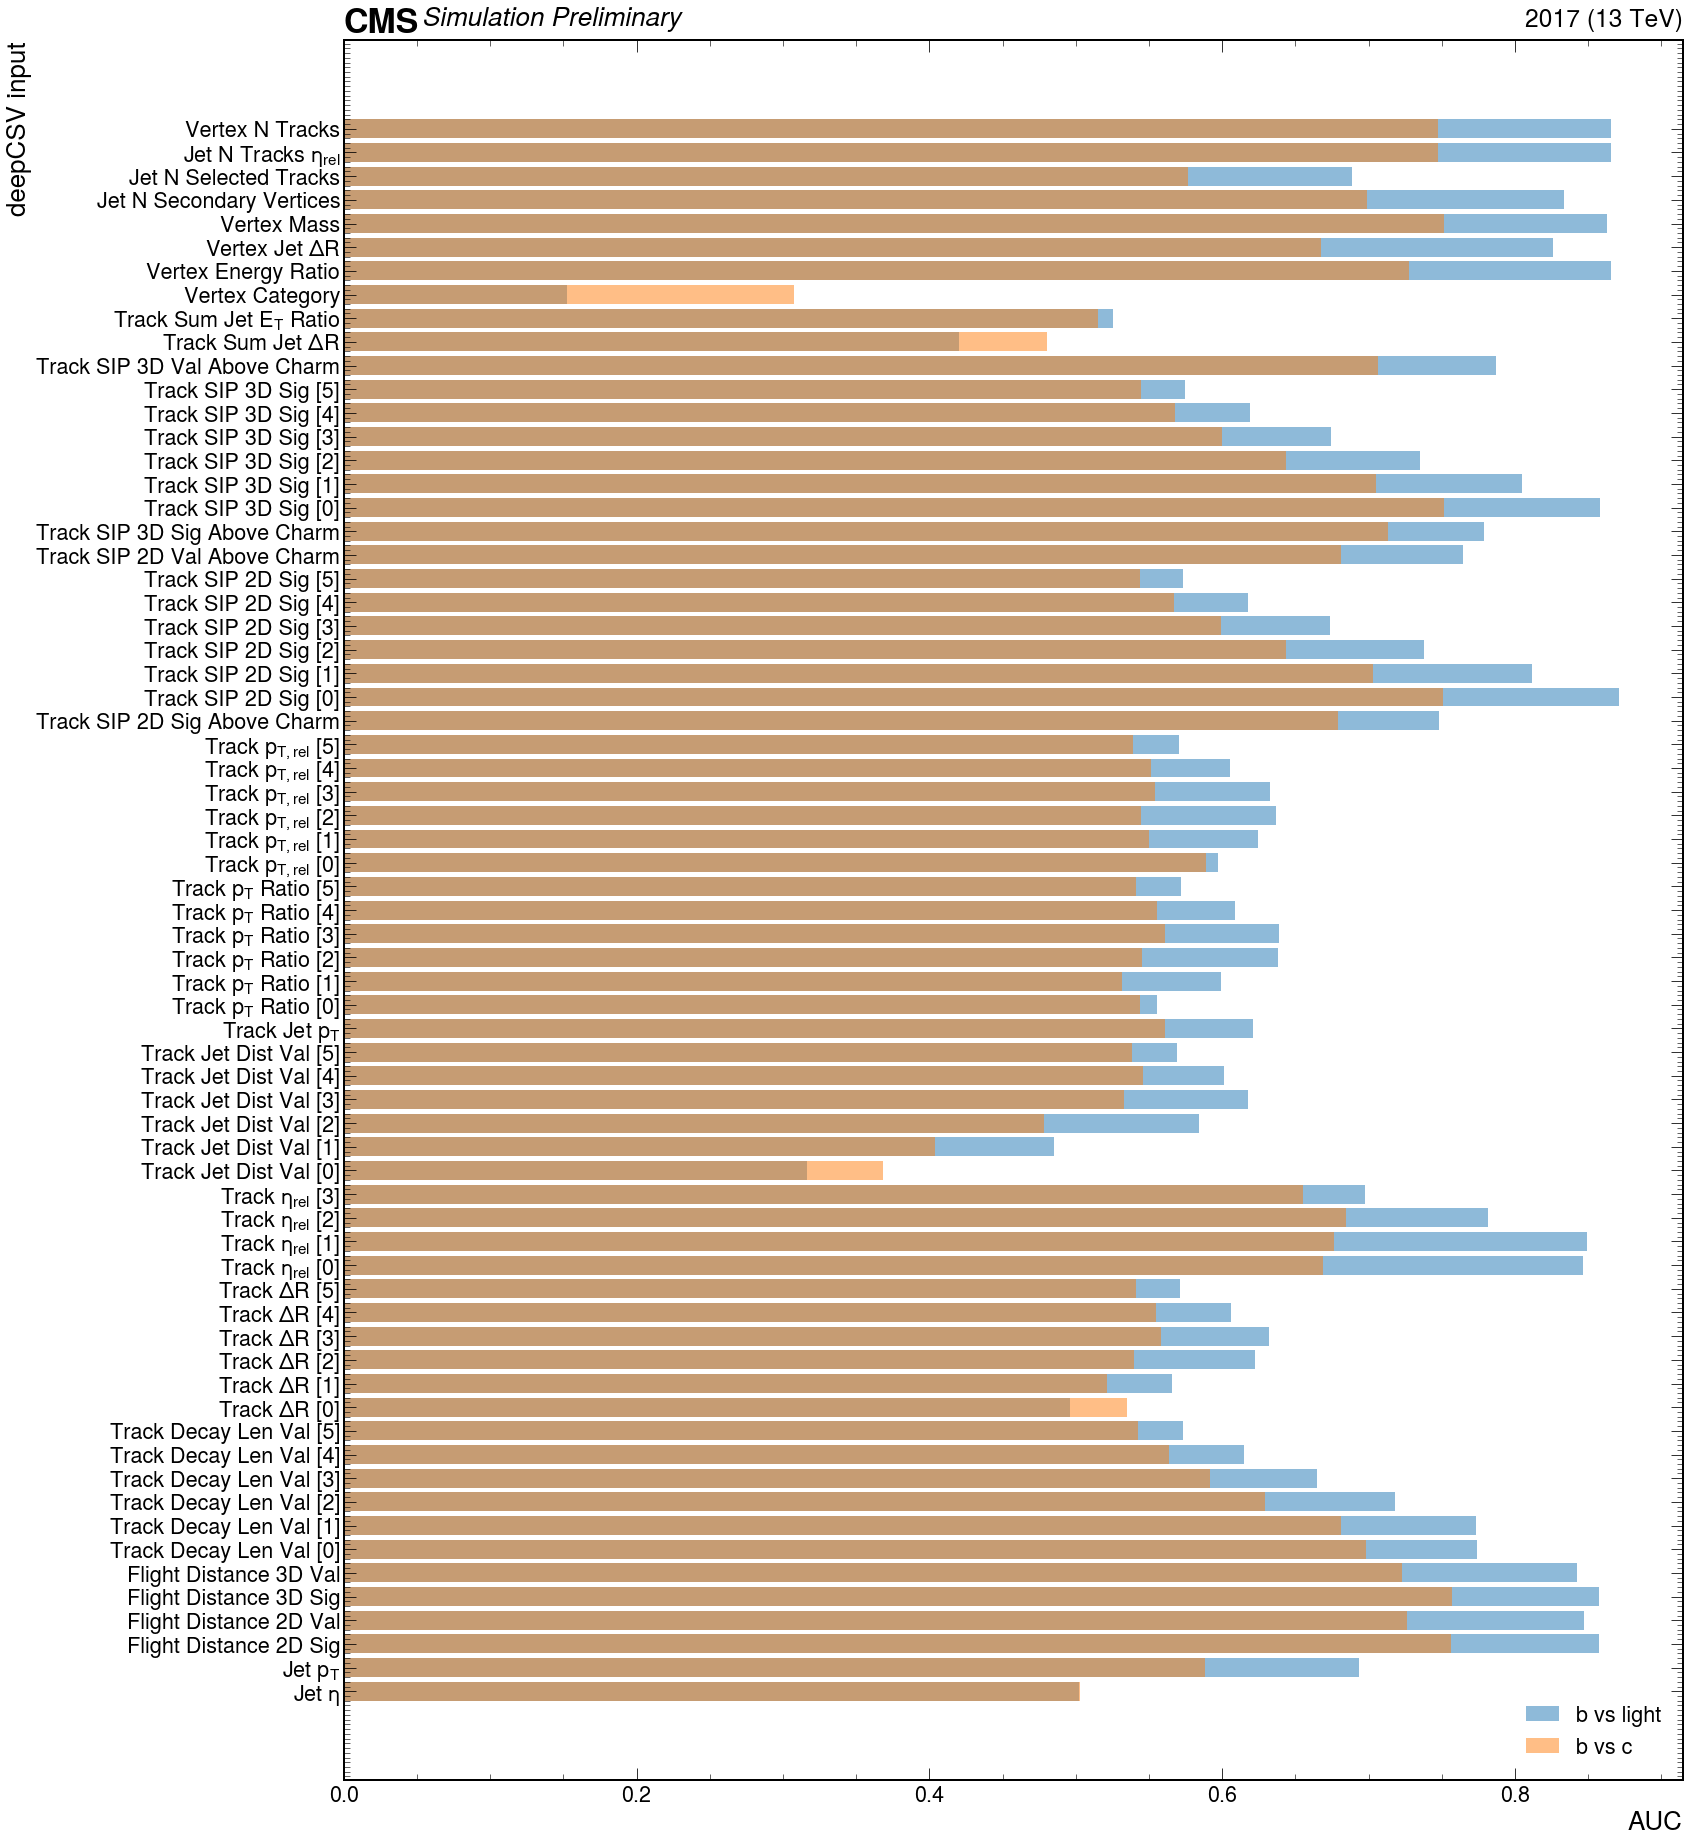

In [23]:
f, ax = plt.subplots(figsize=(24, 32))
hep.cms.label(loc=0)

ax.barh(df['input_name'], df['auc_bvl'], alpha=0.5, label='b vs light')
ax.barh(df['input_name'], df['auc_bvc'], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [24]:
sorted_df = df.sort_values('auc_bvl')

In [25]:
sorted_df

input_name   auc_bvl   auc_bvc
59            Vertex Category  0.152760  0.307511
22     Track Jet Dist Val [0]  0.316727  0.368612
57   Track Sum Jet $\Delta R$  0.420251  0.480071
23     Track Jet Dist Val [1]  0.485160  0.403597
12       Track $\Delta R$ [0]  0.496357  0.535348
..                        ...       ...       ...
62                Vertex Mass  0.862664  0.751394
65  Jet N Tracks $\eta_{rel}$  0.865444  0.747727
66            Vertex N Tracks  0.865444  0.747727
60        Vertex Energy Ratio  0.865611  0.727417
42       Track SIP 2D Sig [0]  0.871150  0.750566

[67 rows x 3 columns]

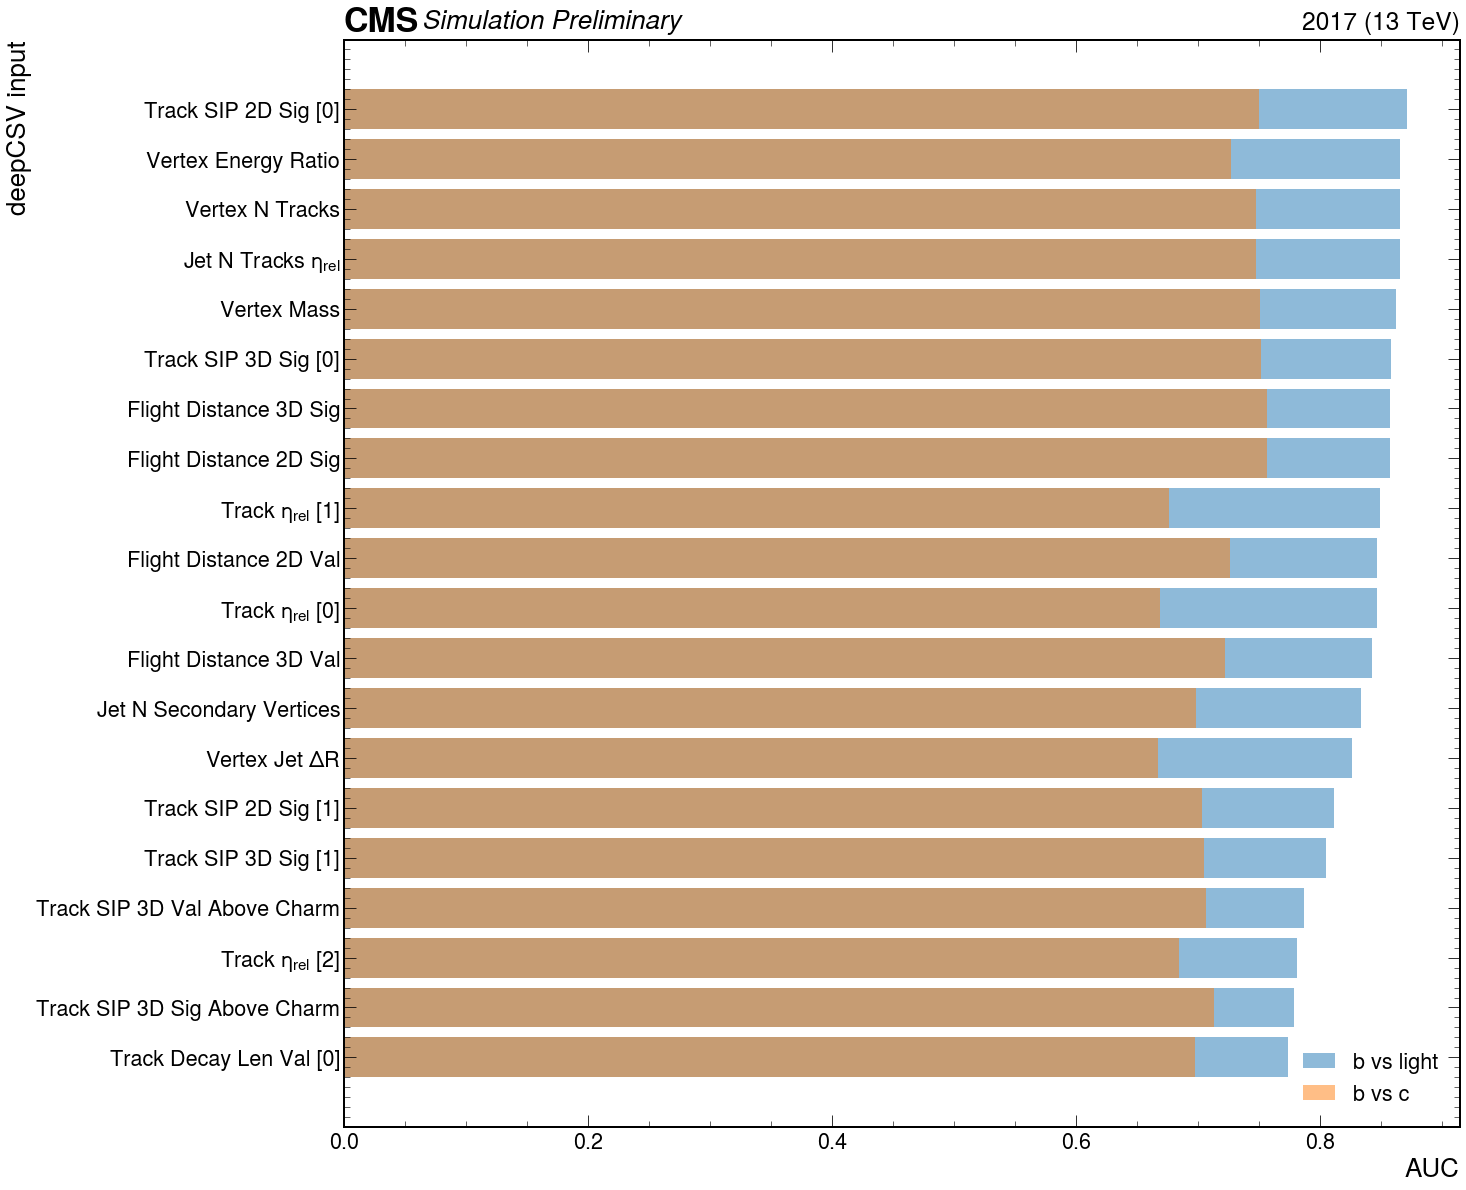

In [26]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [27]:
sorted_df = df.sort_values('auc_bvc')

In [28]:
sorted_df

input_name   auc_bvl   auc_bvc
59           Vertex Category  0.152760  0.307511
22    Track Jet Dist Val [0]  0.316727  0.368612
23    Track Jet Dist Val [1]  0.485160  0.403597
24    Track Jet Dist Val [2]  0.584136  0.478307
57  Track Sum Jet $\Delta R$  0.420251  0.480071
..                       ...       ...       ...
42      Track SIP 2D Sig [0]  0.871150  0.750566
62               Vertex Mass  0.862664  0.751394
50      Track SIP 3D Sig [0]  0.858374  0.751714
2     Flight Distance 2D Sig  0.857298  0.756523
4     Flight Distance 3D Sig  0.857379  0.756759

[67 rows x 3 columns]

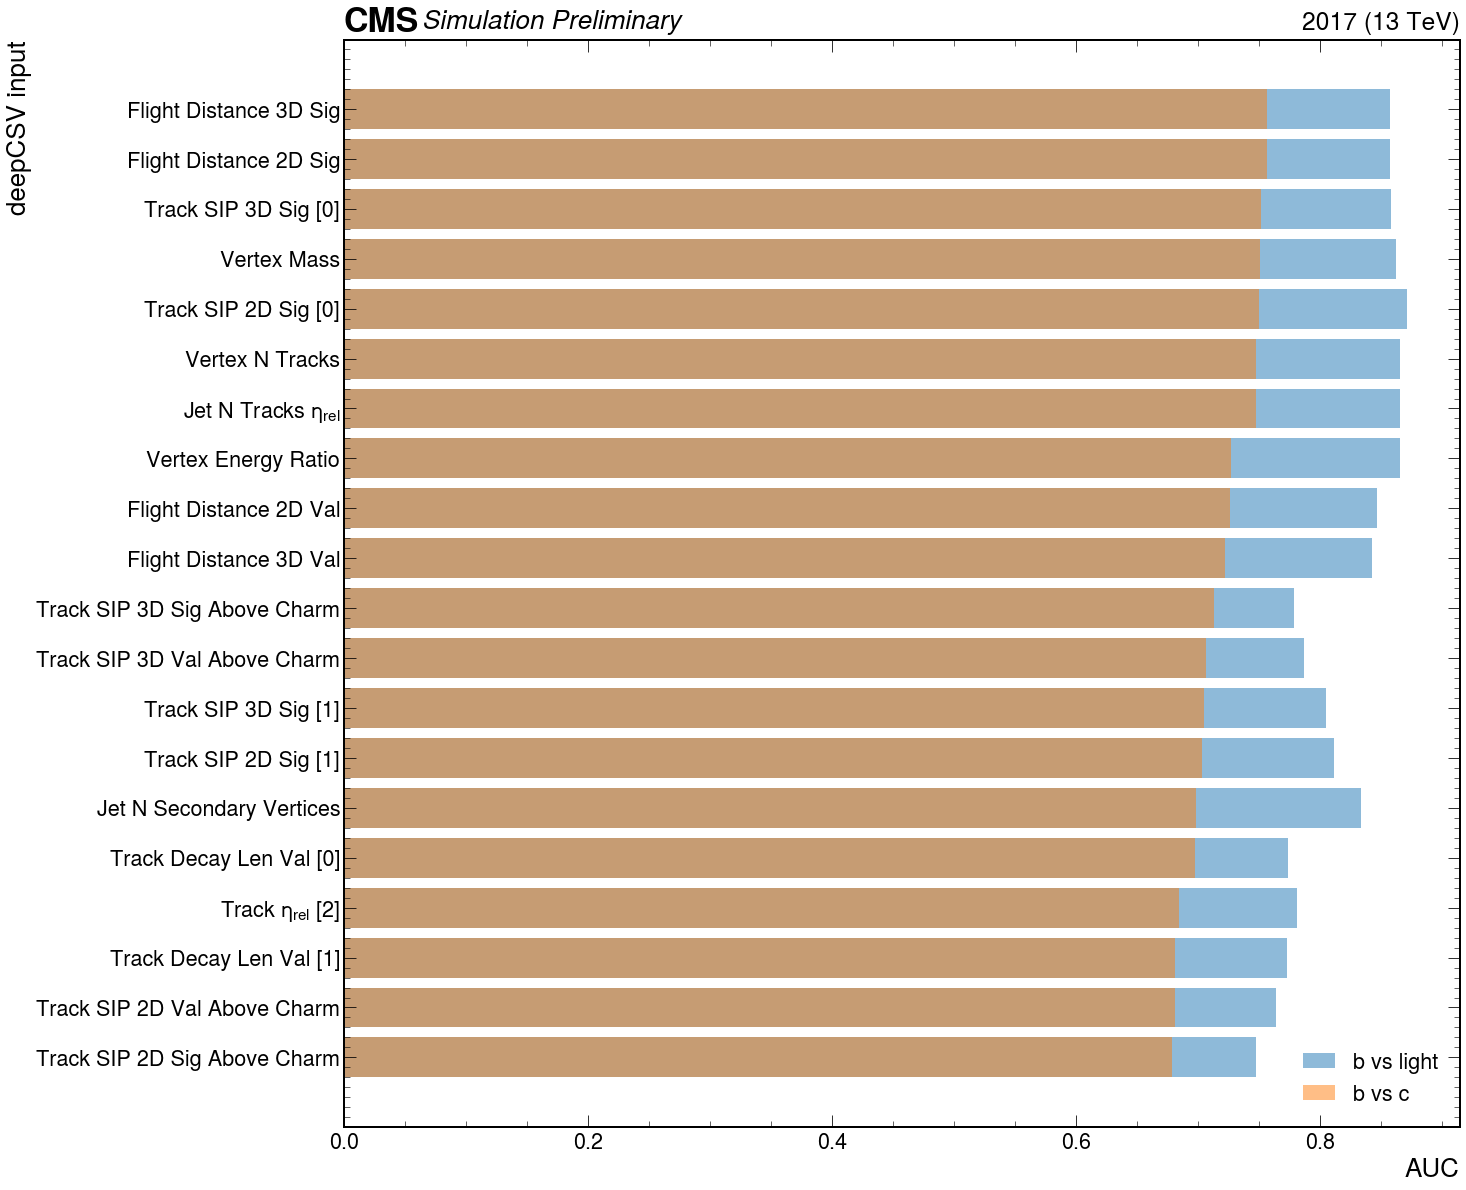

In [29]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [31]:
NUM_DATASETS = 1
scalers_file_paths = ['/hpcwork/um106329/new_march_21/scaledTTtoSemilep/scalers_%d.pt' % k for k in range(0,NUM_DATASETS)]
test_input_file_paths = ['/hpcwork/um106329/new_march_21/scaledTTtoSemilep/test_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
test_target_file_paths = ['/hpcwork/um106329/new_march_21/scaledTTtoSemilep/test_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]

In [32]:
def apply_noise(magn=[1],offset=[0],variable=0):
    xmagn = []
    for s in range(0, NUM_DATASETS):
        scalers = torch.load(scalers_file_paths[s])
        all_inputs =  torch.load(test_input_file_paths[s]).to(device).float()[:1000]
        #val_inputs =  torch.load(val_input_file_paths[s]).to(device).float()
        #train_inputs =  torch.load(train_input_file_paths[s]).to(device).float()
        #test_targets =  torch.load(test_target_file_paths[s]).to(device)
        #val_targets =  torch.load(val_target_file_paths[s]).to(device)
        #train_targets =  torch.load(train_target_file_paths[s]).to(device)            
        #all_inputs = torch.cat((test_inputs,val_inputs,train_inputs))
        
        for i, m in enumerate(magn):
            noise = torch.Tensor(np.random.normal(offset,m,(len(all_inputs),67))).to(device)
            all_inputs_noise = all_inputs + noise
            if s > 0:
                xadv = scalers[variable].inverse_transform(all_inputs_noise[:][:,variable].cpu())
                integervars = [59,63,64,65,66]
                if variable in integervars:
                    xadv = np.rint(scalers[variable].inverse_transform(all_inputs[:][:,variable].cpu()))
                
                '''
                if variable in [41, 48, 49, 56]:
                    defaults = abs(scalers[variable].inverse_transform(all_inputs[:,variable].cpu()) + 1.0) < 0.001   # "floating point error" --> allow some error margin
                    if np.sum(defaults) != 0:
                        xadv[defaults] = scalers[variable].inverse_transform(all_inputs[:,variable].cpu())[defaults]
                '''
                
                '''
                # as long as nothing was set to 0 manually, not really necessary
                vars_with_0_defaults = [6, 7, 8, 9, 10, 11]                 # trackDecayLenVal_0 to _5
                vars_with_0_defaults.extend([12, 13, 14, 15, 16, 17])       # trackDeltaR_0 to _5
                vars_with_0_defaults.extend([18, 19, 20, 21])               # trackEtaRel_0 to _3
                vars_with_0_defaults.extend([22, 23, 24, 25, 26, 27])       # trackJetDistVal_0 to _5
                vars_with_0_defaults.extend([29, 30, 31, 32, 33, 34])       # trackPtRatio_0 to _5
                vars_with_0_defaults.extend([35, 36, 37, 38, 39, 40])       # trackPtRel_0 to _5
                if variable in vars_with_0_defaults:
                    defaults = abs(scalers[i].inverse_transform(all_inputs[:,variable].cpu())) < 0.001   # "floating point error" --> allow some error margin
                    if np.sum(defaults) != 0:
                        xadv[defaults] = all_inputs[:,variable][defaults]
                '''        
                
                '''
                    # For cleaned files (QCD or TT to Semileptonic)
                '''
                
                if variable in range(67):
                    defaults = abs(scalers[i].inverse_transform(all_inputs[:,i].cpu()) + 999) < 300   # "floating point error" --> allow some error margin
                    if np.sum(defaults) != 0:
                        xadv[defaults] = scalers[variable].inverse_transform(all_inputs[:,variable].cpu())[defaults]
                '''        
                        
                if variable in range(67):
                    defaults = abs(all_inputs[:,variable].cpu() + 900) < 0
                    if np.sum(defaults) != 0:
                        xadv[defaults] = all_inputs[:,variable].cpu()[defaults]
                '''        
                xadv_new = np.concatenate((xmagn[i], xadv))
                xmagn[i] = xadv_new
            else:
                xadv = scalers[variable].inverse_transform(all_inputs_noise[:][:,variable].cpu())
                integervars = [59,63,64,65,66]
                if variable in integervars:
                    xadv = np.rint(scalers[variable].inverse_transform(all_inputs[:][:,variable].cpu()))
                '''
                if variable in [41, 48, 49, 56]:
                    defaults = abs(scalers[variable].inverse_transform(all_inputs[:,variable].cpu()) + 1.0) < 0.001   # "floating point error" --> allow some error margin
                    if np.sum(defaults) != 0:
                        xadv[defaults] = scalers[variable].inverse_transform(all_inputs[:,variable].cpu())[defaults]
                '''        
                
                '''
                # as long as nothing was set to 0 manually, not really necessary
                vars_with_0_defaults = [6, 7, 8, 9, 10, 11]                 # trackDecayLenVal_0 to _5
                vars_with_0_defaults.extend([12, 13, 14, 15, 16, 17])       # trackDeltaR_0 to _5
                vars_with_0_defaults.extend([18, 19, 20, 21])               # trackEtaRel_0 to _3
                vars_with_0_defaults.extend([22, 23, 24, 25, 26, 27])       # trackJetDistVal_0 to _5
                vars_with_0_defaults.extend([29, 30, 31, 32, 33, 34])       # trackPtRatio_0 to _5
                vars_with_0_defaults.extend([35, 36, 37, 38, 39, 40])       # trackPtRel_0 to _5
                if variable in vars_with_0_defaults:
                    defaults = abs(scalers[i].inverse_transform(all_inputs[:,variable].cpu())) < 0.001   # "floating point error" --> allow some error margin
                    if np.sum(defaults) != 0:
                        xadv[defaults] = all_inputs[:,variable][defaults]
                '''        
                
                '''
                    # For cleaned files (QCD or TT to Semileptonic)
                '''
                
                if variable in range(67):
                    defaults = abs(scalers[i].inverse_transform(all_inputs[:,i].cpu()) + 999) < 300   # "floating point error" --> allow some error margin
                    if np.sum(defaults) != 0:
                        xadv[defaults] = scalers[variable].inverse_transform(all_inputs[:,variable].cpu())[defaults]
                '''        
                if variable in range(67):
                    defaults = abs(all_inputs[:,variable].cpu() + 900) < 0
                    if np.sum(defaults) != 0:
                        xadv[defaults] = all_inputs[:,variable].cpu()[defaults]
                '''         
                        
                xmagn.append(xadv)
        
        del all_inputs
        del all_inputs_noise
        del noise
        del xadv
        gc.collect()
        
    return np.array(xmagn)

In [24]:
noise_inputs = np.vstack([apply_noise(magn=[0.05], offset=[0], variable=p) for p in range(67)])

In [28]:
noise_inputs = noise_inputs.transpose()

In [30]:
len(noise_inputs)

1000

In [31]:
noise_inputsNP = noise_inputs
flav = torch.cat(tuple(torch.load(ti) for ti in test_target_file_paths)).numpy().astype(int) + 1
noise_inputsNP = np.c_[noise_inputsNP, flav[:1000]]

In [34]:
list_variables = []
list_auc_bvl = []
list_auc_bvc = []

for deepcsv_input in range(67):
    
    bvl = noise_inputsNP[noise_inputsNP[:,-1] != 3]
    y_true_bvl = bvl[:,-1] != 4
    y_pred_bvl = bvl[:,deepcsv_input]
        
    bvc = noise_inputsNP[noise_inputsNP[:,-1] != 4]
    y_true_bvc = bvc[:,-1] != 3
    y_pred_bvc = bvc[:,deepcsv_input]
    
    
    auc_bvl = roc_auc_score(y_true_bvl, y_pred_bvl)
    auc_bvc = roc_auc_score(y_true_bvc, y_pred_bvc)
    
    print(f'Variable: {display_names[deepcsv_input]}, AUC bvl: {auc_bvl}, AUC bvc: {auc_bvc}')
    
    list_variables.append(display_names[deepcsv_input])
    list_auc_bvl.append(auc_bvl)
    list_auc_bvc.append(auc_bvc)
    
df = pd.DataFrame(list(zip(list_variables, list_auc_bvl, list_auc_bvc)), columns =['input_name', 'auc_bvl', 'auc_bvc'])

Variable: Jet $\eta$, AUC bvl: 0.4917248255234296, AUC bvc: 0.5326388888888889
Variable: Jet $p_T$, AUC bvl: 0.7091936312275294, AUC bvc: 0.5375816993464052
Variable: Flight Distance 2D Sig, AUC bvl: 0.8312365932505512, AUC bvc: 0.7350898692810457
Variable: Flight Distance 2D Val, AUC bvl: 0.825668449197861, AUC bvc: 0.6977941176470588
Variable: Flight Distance 3D Sig, AUC bvl: 0.8321369225656364, AUC bvc: 0.7357638888888888
Variable: Flight Distance 3D Val, AUC bvl: 0.8263270793679566, AUC bvc: 0.6879697712418301
Variable: Track Decay Len Val [0], AUC bvl: 0.7786519230188225, AUC bvc: 0.6604575163398694
Variable: Track Decay Len Val [1], AUC bvl: 0.7468020181878607, AUC bvc: 0.6460171568627451
Variable: Track Decay Len Val [2], AUC bvl: 0.6769660714825222, AUC bvc: 0.5759395424836601
Variable: Track Decay Len Val [3], AUC bvl: 0.6366053355086256, AUC bvc: 0.5223651960784315
Variable: Track Decay Len Val [4], AUC bvl: 0.6333514607692076, AUC bvc: 0.49560866013071897
Variable: Track Dec

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


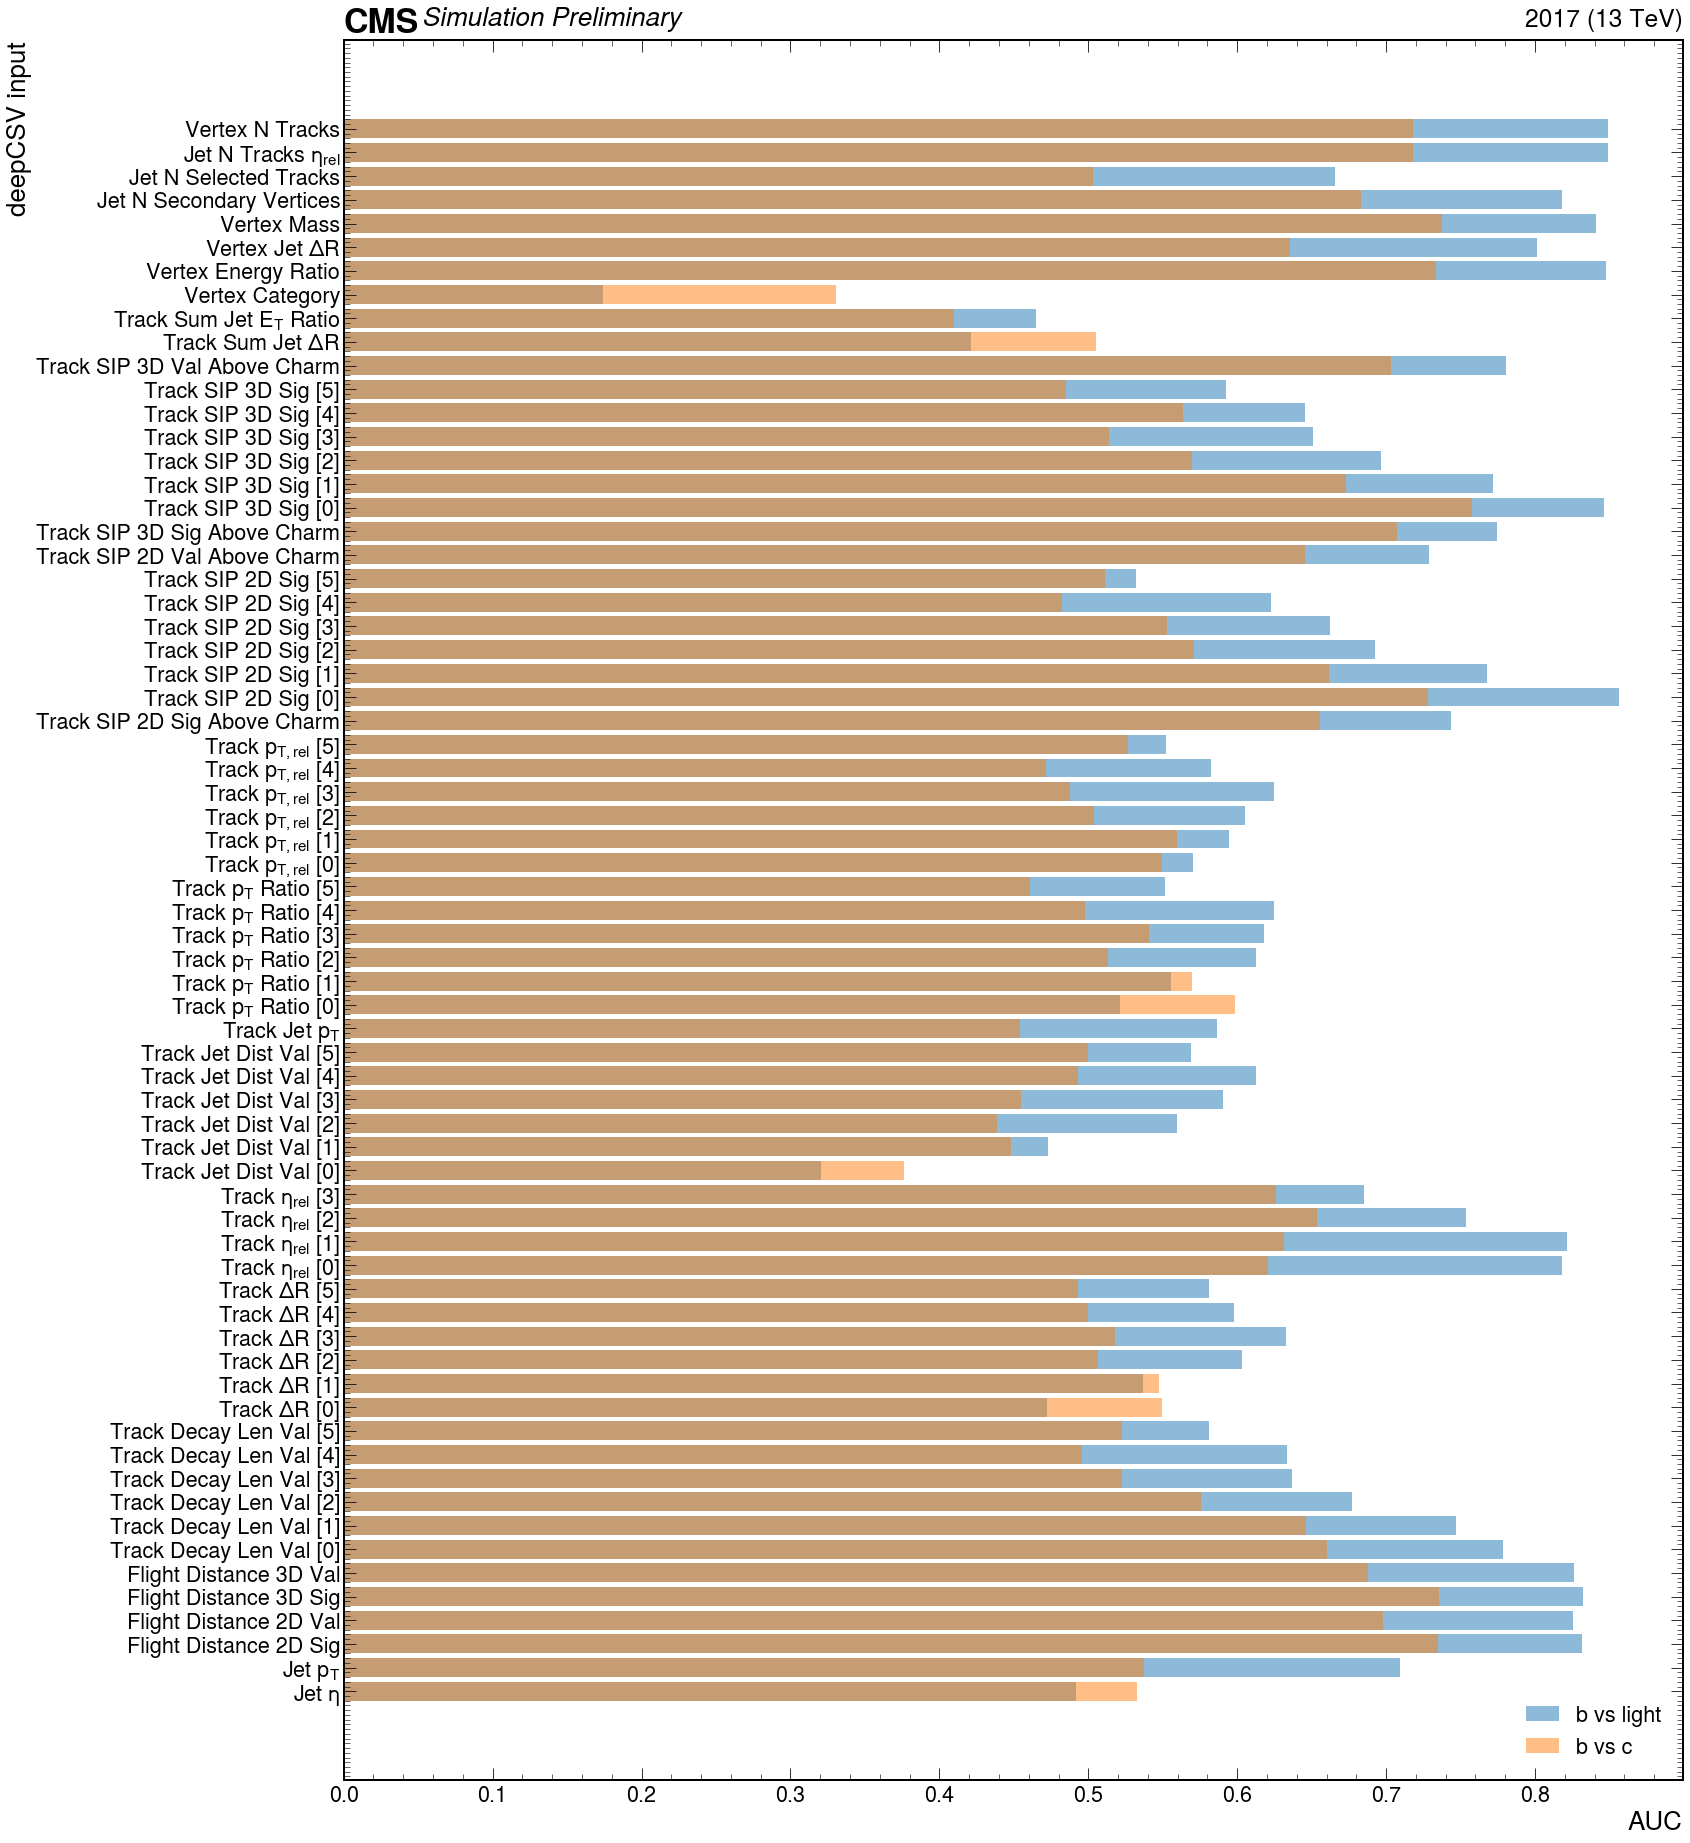

In [35]:
f, ax = plt.subplots(figsize=(24, 32))
hep.cms.label(loc=0)

ax.barh(df['input_name'], df['auc_bvl'], alpha=0.5, label='b vs light')
ax.barh(df['input_name'], df['auc_bvc'], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [36]:
sorted_df = df.sort_values('auc_bvl')

In [37]:
sorted_df

input_name   auc_bvl   auc_bvc
59            Vertex Category  0.174398  0.330801
22     Track Jet Dist Val [0]  0.320288  0.376021
57   Track Sum Jet $\Delta R$  0.421554  0.505147
58  Track Sum Jet $E_T$ Ratio  0.464951  0.410008
12       Track $\Delta R$ [0]  0.472063  0.549673
..                        ...       ...       ...
50       Track SIP 3D Sig [0]  0.846442  0.757516
60        Vertex Energy Ratio  0.847530  0.733170
65  Jet N Tracks $\eta_{rel}$  0.848778  0.718158
66            Vertex N Tracks  0.848778  0.718158
42       Track SIP 2D Sig [0]  0.856449  0.727859

[67 rows x 3 columns]

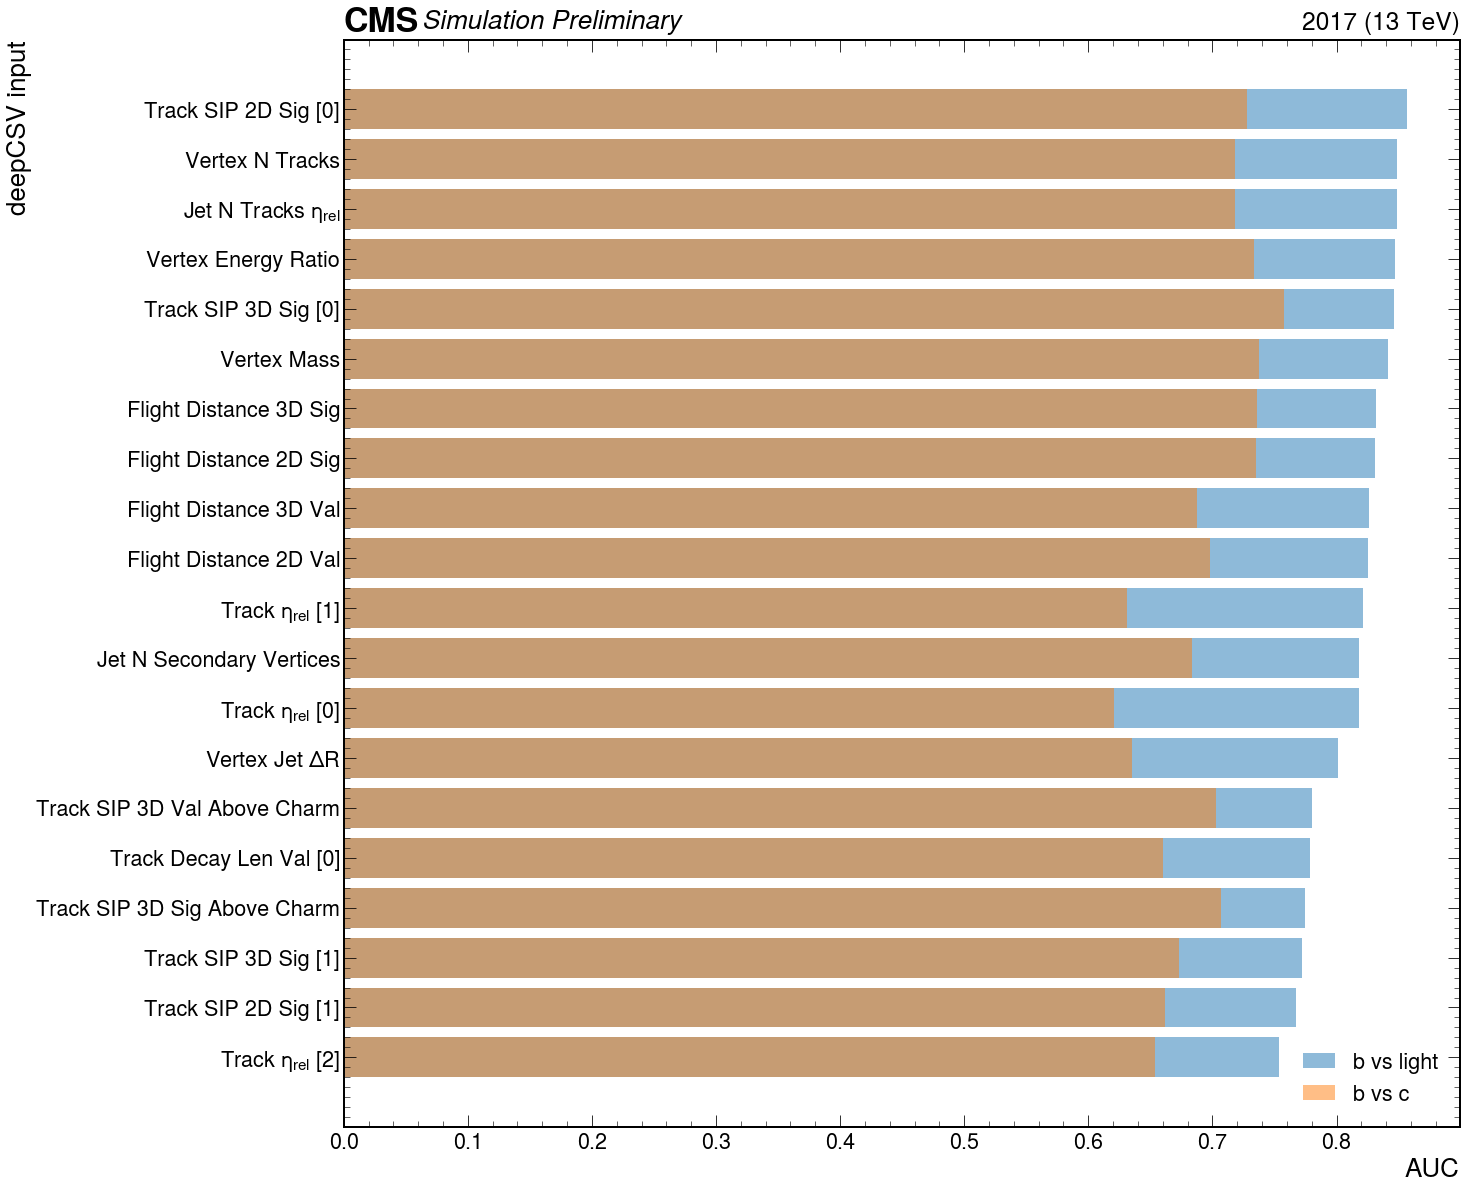

In [38]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [39]:
sorted_df = df.sort_values('auc_bvc')

In [40]:
sorted_df

input_name   auc_bvl   auc_bvc
59            Vertex Category  0.174398  0.330801
22     Track Jet Dist Val [0]  0.320288  0.376021
58  Track Sum Jet $E_T$ Ratio  0.464951  0.410008
24     Track Jet Dist Val [2]  0.559588  0.438399
23     Track Jet Dist Val [1]  0.472999  0.448264
..                        ...       ...       ...
60        Vertex Energy Ratio  0.847530  0.733170
2      Flight Distance 2D Sig  0.831237  0.735090
4      Flight Distance 3D Sig  0.832137  0.735764
62                Vertex Mass  0.841140  0.737173
50       Track SIP 3D Sig [0]  0.846442  0.757516

[67 rows x 3 columns]

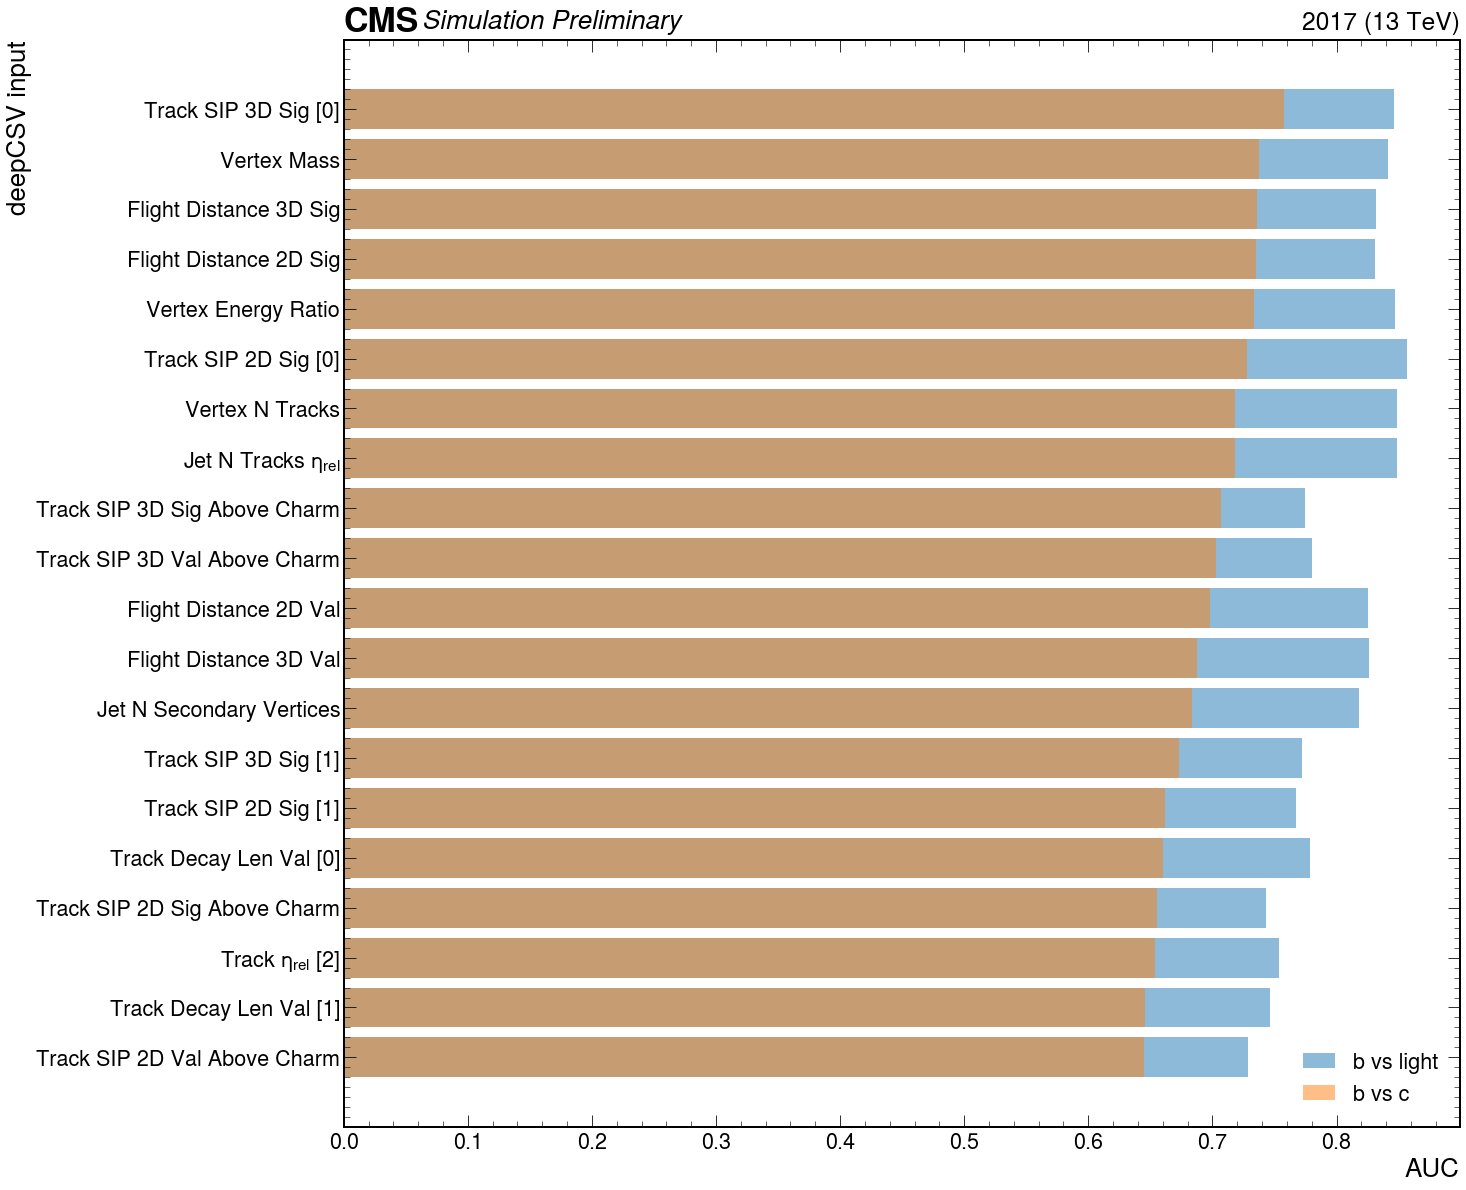

In [41]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [25]:
def fgsm_attack(epsilon=1e-1,sample=None,targets=None,reduced=True, scalers=None, model=2):
    xadv = sample.clone().detach()
    
    # calculate the gradient of the model w.r.t. the *input* tensor:
    # first we tell torch that x should be included in grad computations
    xadv.requires_grad = True
    
    # then we just do the forward and backwards pass as usual:
    if model == 0:
        preds = model0(xadv)
        loss = criterion0(preds, targets.long()).mean()
        model0.zero_grad()
    elif model == 1:
        preds = model1(xadv)
        loss = criterion1(preds, targets.long()).mean()
        model1.zero_grad()
    else:
        preds = model2(xadv)
        loss = criterion(preds, targets.long()).mean()
        model2.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        #now we obtain the gradient of the input. It has the same dimensions as the tensor xadv, and it "points" in the direction of increasing loss values.
        dx = torch.sign(xadv.grad.detach())
        
        #so, we take a step in that direction!
        xadv += epsilon*torch.sign(dx)
        
        #remove the impact on selected variables. This is nessecary to avoid problems that occur otherwise in the input shapes.
        if reduced:
            #xadv[:,2] = sample[:,2]     # TagVarCSV_jetNSecondaryVertices
            xadv[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')] = sample[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')]
            #xadv[:,5] = sample[:,5]     # TagVarCSV_vertexCategory
            xadv[:,input_names.index('Jet_DeepCSV_vertexCategory')] = sample[:,input_names.index('Jet_DeepCSV_vertexCategory')]
            #xadv[:,10] = sample[:,10]   # TagVarCSV_jetNSelectedTracks
            xadv[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')] = sample[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')]
            #xadv[:,11] = sample[:,11]   # TagVarCSV_jetNTracksEtaRel
            xadv[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')] = sample[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')]
            #xadv[:,59] = sample[:,59]   # TagVarCSV_vertexNTracks
            xadv[:,input_names.index('Jet_DeepCSV_vertexNTracks')] = sample[:,input_names.index('Jet_DeepCSV_vertexNTracks')]
            #xadv[:,12:][sample[:,12:]==0] = 0   # TagVarCSVTrk_trackJetDistVal and so forth, but I have not set any variable to 0 manually during cleaning
            #xadv[:,input_names.index('Jet_DeepCSV_trackJetDistVal_0'):][sample[:,input_names.index('Jet_DeepCSV_trackJetDistVal_0'):] == 0] = 0
            
            '''
            for i in [41, 48, 49, 56]:
                defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu()) + 1.0) < 0.001   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in [41, 48, 49, 56]:
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
            vars_with_0_defaults = [6, 7, 8, 9, 10, 11]                 # trackDecayLenVal_0 to _5
            vars_with_0_defaults.extend([12, 13, 14, 15, 16, 17])       # trackDeltaR_0 to _5
            vars_with_0_defaults.extend([18, 19, 20, 21])               # trackEtaRel_0 to _3
            vars_with_0_defaults.extend([22, 23, 24, 25, 26, 27])       # trackJetDistVal_0 to _5
            vars_with_0_defaults.extend([29, 30, 31, 32, 33, 34])       # trackPtRatio_0 to _5
            vars_with_0_defaults.extend([35, 36, 37, 38, 39, 40])       # trackPtRel_0 to _5
            for i in vars_with_0_defaults:
                defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu())) < 0.001   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in vars_with_0_defaults:
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
            '''
            for i in range(67):
                defaults = scalers[i].inverse_transform(sample[:,i].cpu()) + 900 < 0   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in range(67):
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
        return xadv.detach()
  
       

def compare_inputs(prop=0,epsilon=0.1,minimum=None,maximum=None,reduced=True):
    xmagn = []
    for s in range(0, NUM_DATASETS):
        scalers = torch.load(scalers_file_paths[s])
        #scalers = all_scalers[s]
        all_inputs =  torch.load(test_input_file_paths[s]).to(device).float()[:1000]
        #val_inputs =  torch.load(val_input_file_paths[s]).to(device).float()
        #train_inputs =  torch.load(train_input_file_paths[s]).to(device).float()
        all_targets =  torch.load(test_target_file_paths[s]).to(device)[:1000]
        #val_targets =  torch.load(val_target_file_paths[s]).to(device)
        #train_targets =  torch.load(train_target_file_paths[s]).to(device)
        #all_inputs = torch.cat((test_inputs,val_inputs,train_inputs))
        #all_targets = torch.cat((test_targets,val_targets,train_targets))
        #print(f'number of default -1 values for jet variables:\t{np.sum(abs(scalers[41].inverse_transform(all_inputs[:,41].cpu()) + 1.0) < 0.001)}')
        #print(f'percentage of default -1 values for jet variables:\t{np.sum(abs(scalers[41].inverse_transform(all_inputs[:,41].cpu() + 1.0)) < 0.01)/len(all_inputs[:,41].cpu())*100}%')
        
        for i, m in enumerate(epsilon):
            if s > 0:
                xadv = np.concatenate((xmagn[i], scalers[prop].inverse_transform(fgsm_attack(epsilon[i],all_inputs,all_targets,reduced=reduced, scalers=scalers, model=method)[:,prop].cpu())))
                integervars = [59,63,64,65,66]
                if prop in integervars:
                    xadv = np.rint(xadv)
                xmagn[i] = xadv
            else:
                xadv = scalers[prop].inverse_transform(fgsm_attack(epsilon[i],all_inputs,all_targets,reduced=reduced, scalers=scalers)[:,prop].cpu())
                integervars = [59,63,64,65,66]
                if prop in integervars:
                    xadv = np.rint(xadv)
                xmagn.append(xadv)
        
        del scalers
        #del test_inputs
        #del val_inputs
        #del train_inputs
        #del test_targets
        #del val_targets
        #del train_targets
        del all_inputs
        del all_targets
        gc.collect()
    return np.array(xmagn)


In [29]:
input_names = ['Jet_eta',
 'Jet_pt',
 'Jet_DeepCSV_flightDistance2dSig',
 'Jet_DeepCSV_flightDistance2dVal',
 'Jet_DeepCSV_flightDistance3dSig',
 'Jet_DeepCSV_flightDistance3dVal',
 'Jet_DeepCSV_trackDecayLenVal_0',
 'Jet_DeepCSV_trackDecayLenVal_1',
 'Jet_DeepCSV_trackDecayLenVal_2',
 'Jet_DeepCSV_trackDecayLenVal_3',
 'Jet_DeepCSV_trackDecayLenVal_4',
 'Jet_DeepCSV_trackDecayLenVal_5',
 'Jet_DeepCSV_trackDeltaR_0',
 'Jet_DeepCSV_trackDeltaR_1',
 'Jet_DeepCSV_trackDeltaR_2',
 'Jet_DeepCSV_trackDeltaR_3',
 'Jet_DeepCSV_trackDeltaR_4',
 'Jet_DeepCSV_trackDeltaR_5',
 'Jet_DeepCSV_trackEtaRel_0',
 'Jet_DeepCSV_trackEtaRel_1',
 'Jet_DeepCSV_trackEtaRel_2',
 'Jet_DeepCSV_trackEtaRel_3',
 'Jet_DeepCSV_trackJetDistVal_0',
 'Jet_DeepCSV_trackJetDistVal_1',
 'Jet_DeepCSV_trackJetDistVal_2',
 'Jet_DeepCSV_trackJetDistVal_3',
 'Jet_DeepCSV_trackJetDistVal_4',
 'Jet_DeepCSV_trackJetDistVal_5',
 'Jet_DeepCSV_trackJetPt',
 'Jet_DeepCSV_trackPtRatio_0',
 'Jet_DeepCSV_trackPtRatio_1',
 'Jet_DeepCSV_trackPtRatio_2',
 'Jet_DeepCSV_trackPtRatio_3',
 'Jet_DeepCSV_trackPtRatio_4',
 'Jet_DeepCSV_trackPtRatio_5',
 'Jet_DeepCSV_trackPtRel_0',
 'Jet_DeepCSV_trackPtRel_1',
 'Jet_DeepCSV_trackPtRel_2',
 'Jet_DeepCSV_trackPtRel_3',
 'Jet_DeepCSV_trackPtRel_4',
 'Jet_DeepCSV_trackPtRel_5',
 'Jet_DeepCSV_trackSip2dSigAboveCharm',
 'Jet_DeepCSV_trackSip2dSig_0',
 'Jet_DeepCSV_trackSip2dSig_1',
 'Jet_DeepCSV_trackSip2dSig_2',
 'Jet_DeepCSV_trackSip2dSig_3',
 'Jet_DeepCSV_trackSip2dSig_4',
 'Jet_DeepCSV_trackSip2dSig_5',
 'Jet_DeepCSV_trackSip2dValAboveCharm',
 'Jet_DeepCSV_trackSip3dSigAboveCharm',
 'Jet_DeepCSV_trackSip3dSig_0',
 'Jet_DeepCSV_trackSip3dSig_1',
 'Jet_DeepCSV_trackSip3dSig_2',
 'Jet_DeepCSV_trackSip3dSig_3',
 'Jet_DeepCSV_trackSip3dSig_4',
 'Jet_DeepCSV_trackSip3dSig_5',
 'Jet_DeepCSV_trackSip3dValAboveCharm',
 'Jet_DeepCSV_trackSumJetDeltaR',
 'Jet_DeepCSV_trackSumJetEtRatio',
 'Jet_DeepCSV_vertexCategory',
 'Jet_DeepCSV_vertexEnergyRatio',
 'Jet_DeepCSV_vertexJetDeltaR',
 'Jet_DeepCSV_vertexMass',
 'Jet_DeepCSV_jetNSecondaryVertices',
 'Jet_DeepCSV_jetNSelectedTracks',
 'Jet_DeepCSV_jetNTracksEtaRel',
 'Jet_DeepCSV_vertexNTracks',]

In [19]:
compare_inputs(0,epsilon,minimum=None,maximum=None,reduced=True)

NameError: name 'epsilon' is not defined

In [33]:
fgsm_inputs = np.vstack([compare_inputs(p,[0.05],minimum=None,maximum=None,reduced=True) for p in range(67)])

In [34]:
fgsm_inputs = fgsm_inputs.transpose()

In [35]:
len(fgsm_inputs)

1000

In [36]:
fgsm_inputsNP = fgsm_inputs
flav = torch.cat(tuple(torch.load(ti) for ti in test_target_file_paths)).numpy().astype(int) + 1
fgsm_inputsNP = np.c_[fgsm_inputsNP, flav[:1000]]

In [37]:
list_variables = []
list_auc_bvl = []
list_auc_bvc = []

for deepcsv_input in range(67):
    
    bvl = fgsm_inputsNP[fgsm_inputsNP[:,-1] != 3]
    y_true_bvl = bvl[:,-1] != 4
    y_pred_bvl = bvl[:,deepcsv_input]
        
    bvc = fgsm_inputsNP[fgsm_inputsNP[:,-1] != 4]
    y_true_bvc = bvc[:,-1] != 3
    y_pred_bvc = bvc[:,deepcsv_input]
    
    
    auc_bvl = roc_auc_score(y_true_bvl, y_pred_bvl)
    auc_bvc = roc_auc_score(y_true_bvc, y_pred_bvc)
    
    print(f'Variable: {display_names[deepcsv_input]}, AUC bvl: {auc_bvl}, AUC bvc: {auc_bvc}')
    
    list_variables.append(display_names[deepcsv_input])
    list_auc_bvl.append(auc_bvl)
    list_auc_bvc.append(auc_bvc)
    
df = pd.DataFrame(list(zip(list_variables, list_auc_bvl, list_auc_bvc)), columns =['input_name', 'auc_bvl', 'auc_bvc'])

Variable: Jet $\eta$, AUC bvl: 0.4916855494123689, AUC bvc: 0.5314950980392157
Variable: Jet $p_T$, AUC bvl: 0.7148705398954651, AUC bvc: 0.5404411764705882
Variable: Flight Distance 2D Sig, AUC bvl: 0.839457385419499, AUC bvc: 0.7371323529411764
Variable: Flight Distance 2D Val, AUC bvl: 0.8284117344934891, AUC bvc: 0.7000204248366013
Variable: Flight Distance 3D Sig, AUC bvl: 0.8407988156741895, AUC bvc: 0.7334763071895425
Variable: Flight Distance 3D Val, AUC bvl: 0.820236260914227, AUC bvc: 0.6831903594771241
Variable: Track Decay Len Val [0], AUC bvl: 0.7714039699084564, AUC bvc: 0.6518382352941177
Variable: Track Decay Len Val [1], AUC bvl: 0.7362881053808271, AUC bvc: 0.6247140522875817
Variable: Track Decay Len Val [2], AUC bvl: 0.6455149702407927, AUC bvc: 0.5462622549019607
Variable: Track Decay Len Val [3], AUC bvl: 0.6317773950874648, AUC bvc: 0.5107843137254902
Variable: Track Decay Len Val [4], AUC bvl: 0.6131303060515424, AUC bvc: 0.4793300653594771
Variable: Track Decay

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


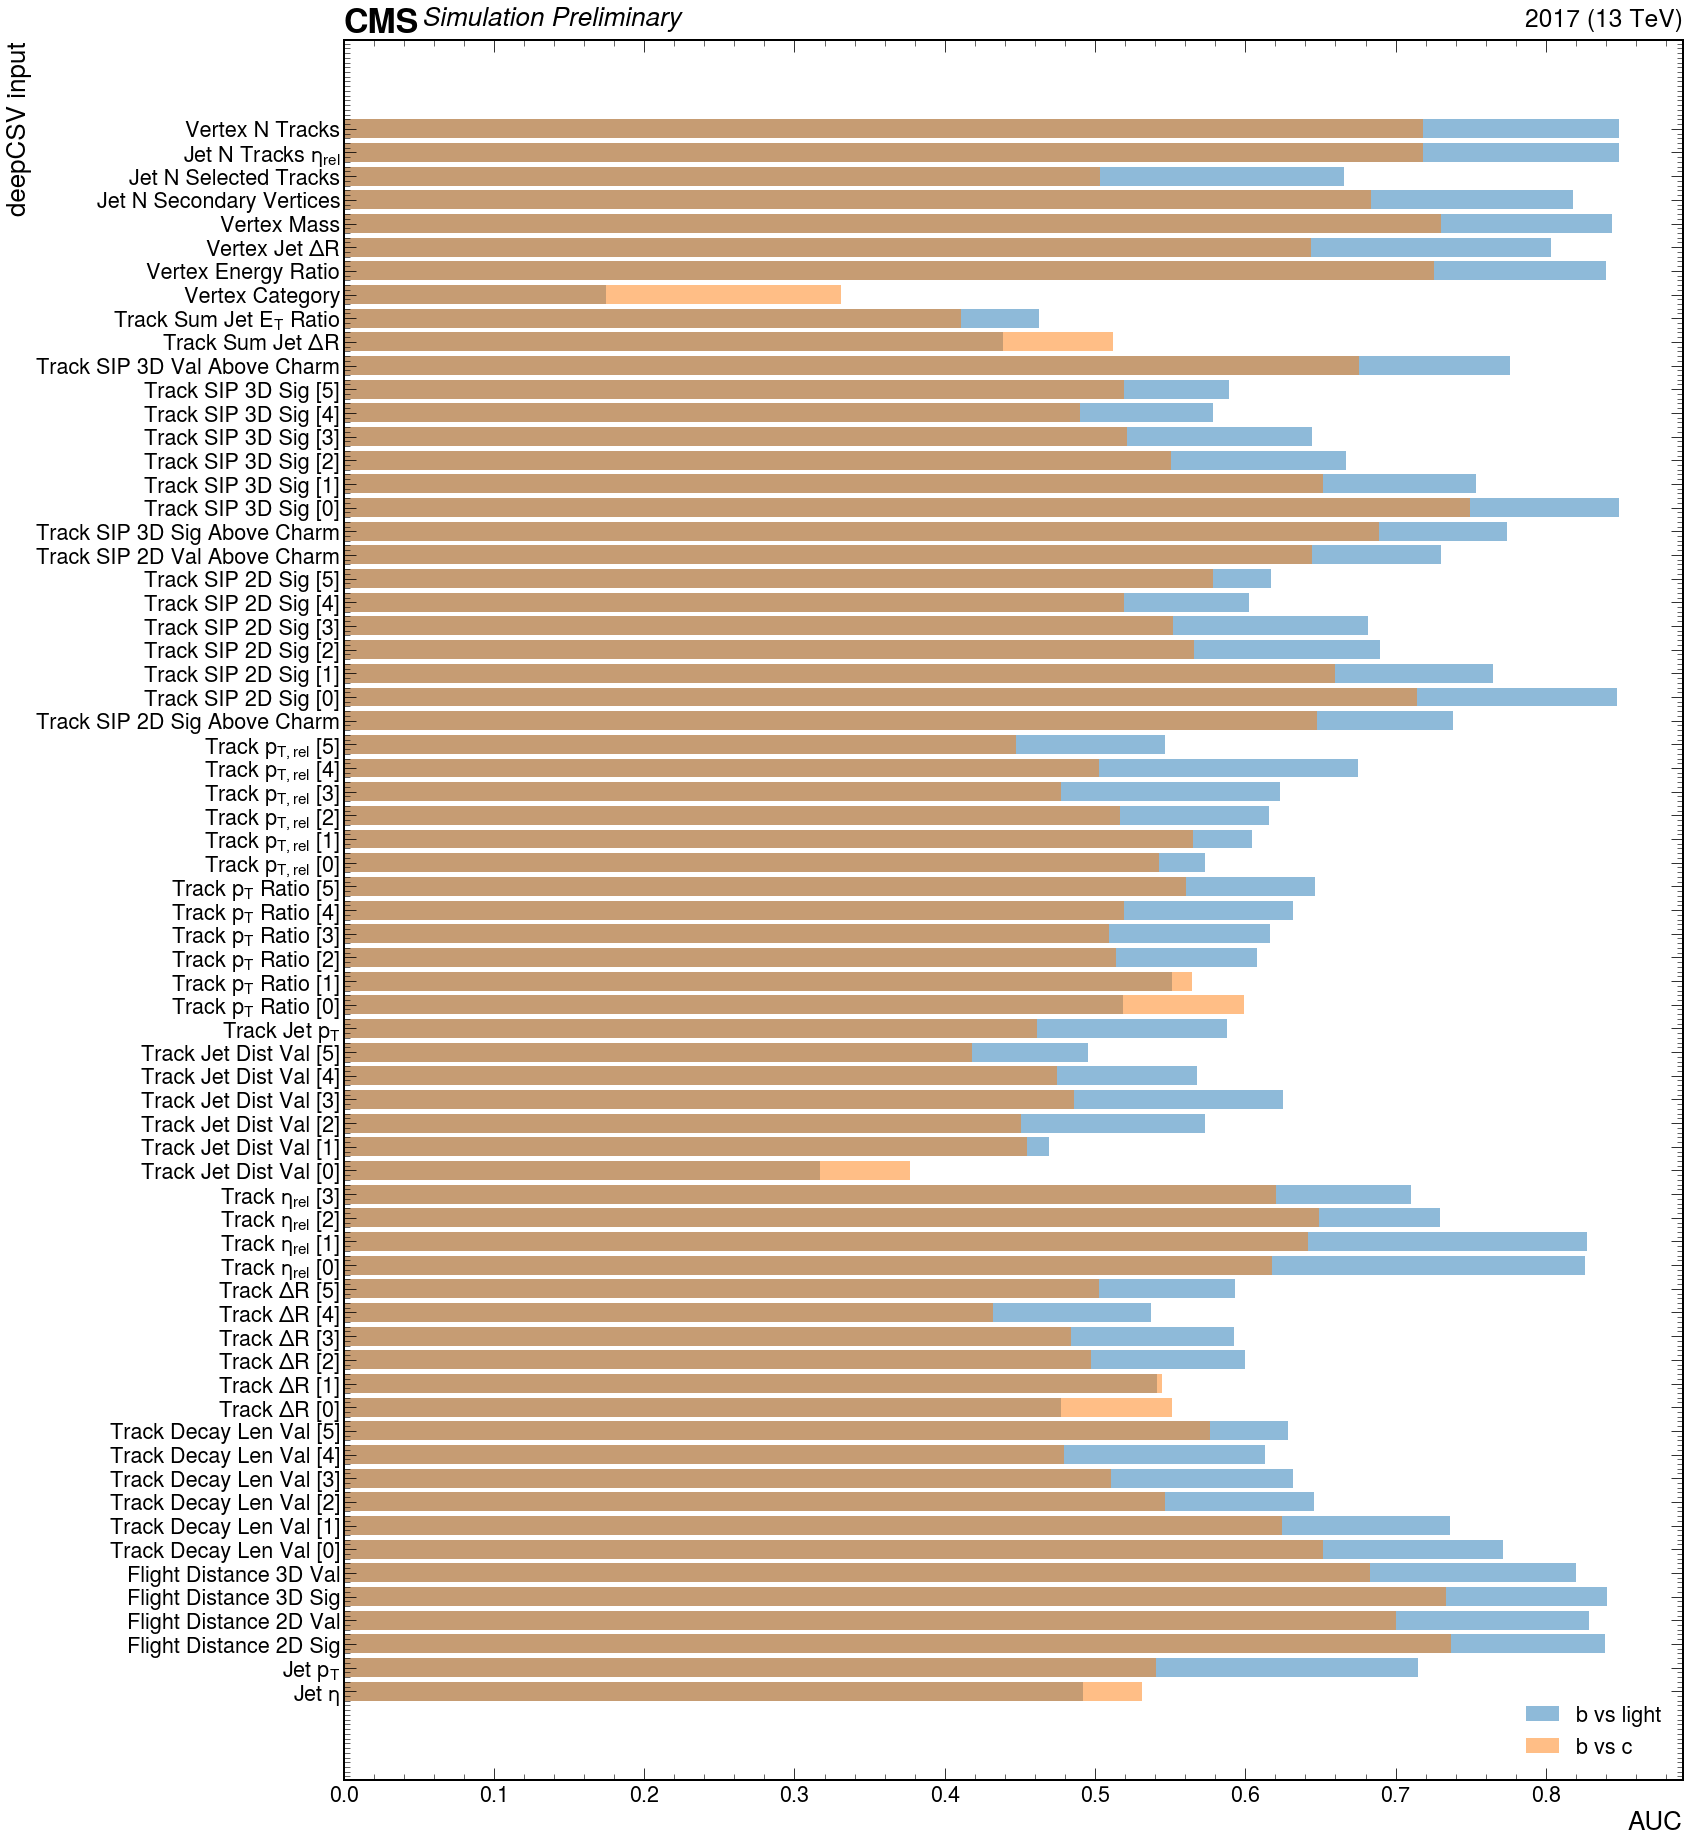

In [38]:
f, ax = plt.subplots(figsize=(24, 32))
hep.cms.label(loc=0)

ax.barh(df['input_name'], df['auc_bvl'], alpha=0.5, label='b vs light')
ax.barh(df['input_name'], df['auc_bvc'], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [39]:
sorted_df = df.sort_values('auc_bvl')

In [40]:
sorted_df

input_name   auc_bvl   auc_bvc
59            Vertex Category  0.174398  0.330801
22     Track Jet Dist Val [0]  0.316774  0.376654
57   Track Sum Jet $\Delta R$  0.438690  0.512051
58  Track Sum Jet $E_T$ Ratio  0.462718  0.410825
23     Track Jet Dist Val [1]  0.469232  0.454677
..                        ...       ...       ...
62                Vertex Mass  0.843877  0.730515
42       Track SIP 2D Sig [0]  0.847307  0.714583
50       Track SIP 3D Sig [0]  0.848500  0.749714
65  Jet N Tracks $\eta_{rel}$  0.848778  0.718158
66            Vertex N Tracks  0.848778  0.718158

[67 rows x 3 columns]

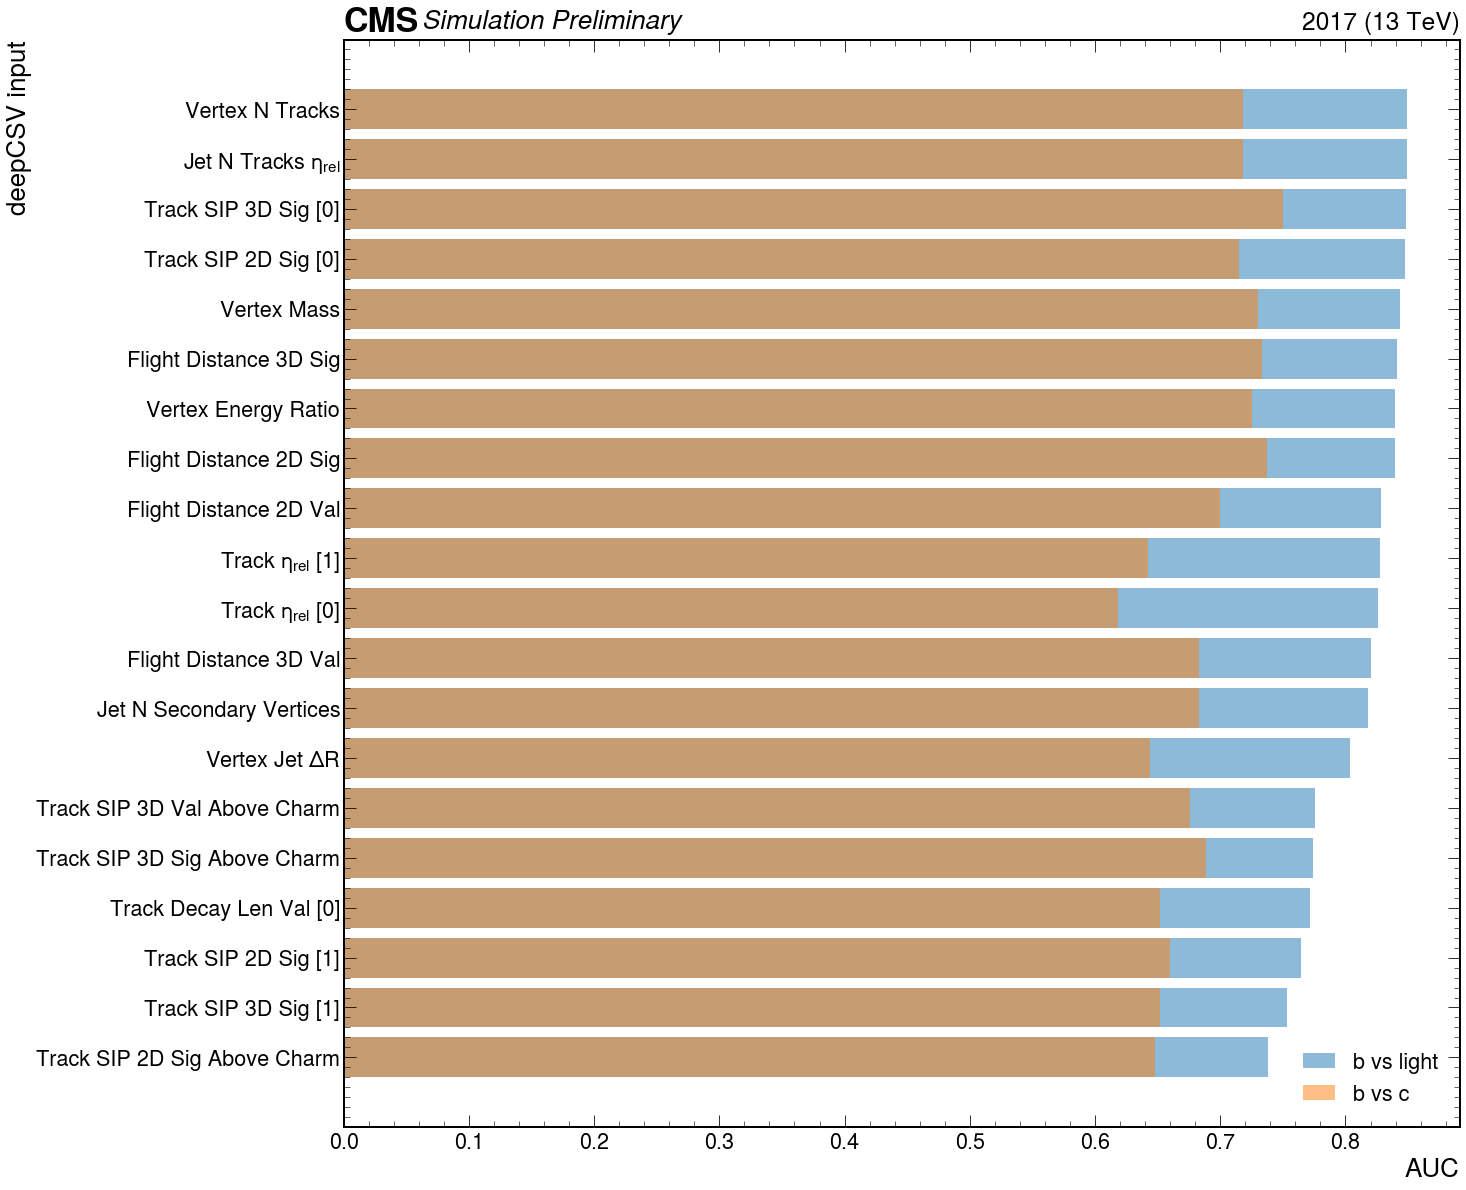

In [41]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [42]:
sorted_df = df.sort_values('auc_bvc')

In [43]:
sorted_df

input_name   auc_bvl   auc_bvc
59            Vertex Category  0.174398  0.330801
22     Track Jet Dist Val [0]  0.316774  0.376654
58  Track Sum Jet $E_T$ Ratio  0.462718  0.410825
27     Track Jet Dist Val [5]  0.495399  0.418199
16       Track $\Delta R$ [4]  0.537261  0.432087
..                        ...       ...       ...
60        Vertex Energy Ratio  0.839769  0.725388
62                Vertex Mass  0.843877  0.730515
4      Flight Distance 3D Sig  0.840799  0.733476
2      Flight Distance 2D Sig  0.839457  0.737132
50       Track SIP 3D Sig [0]  0.848500  0.749714

[67 rows x 3 columns]

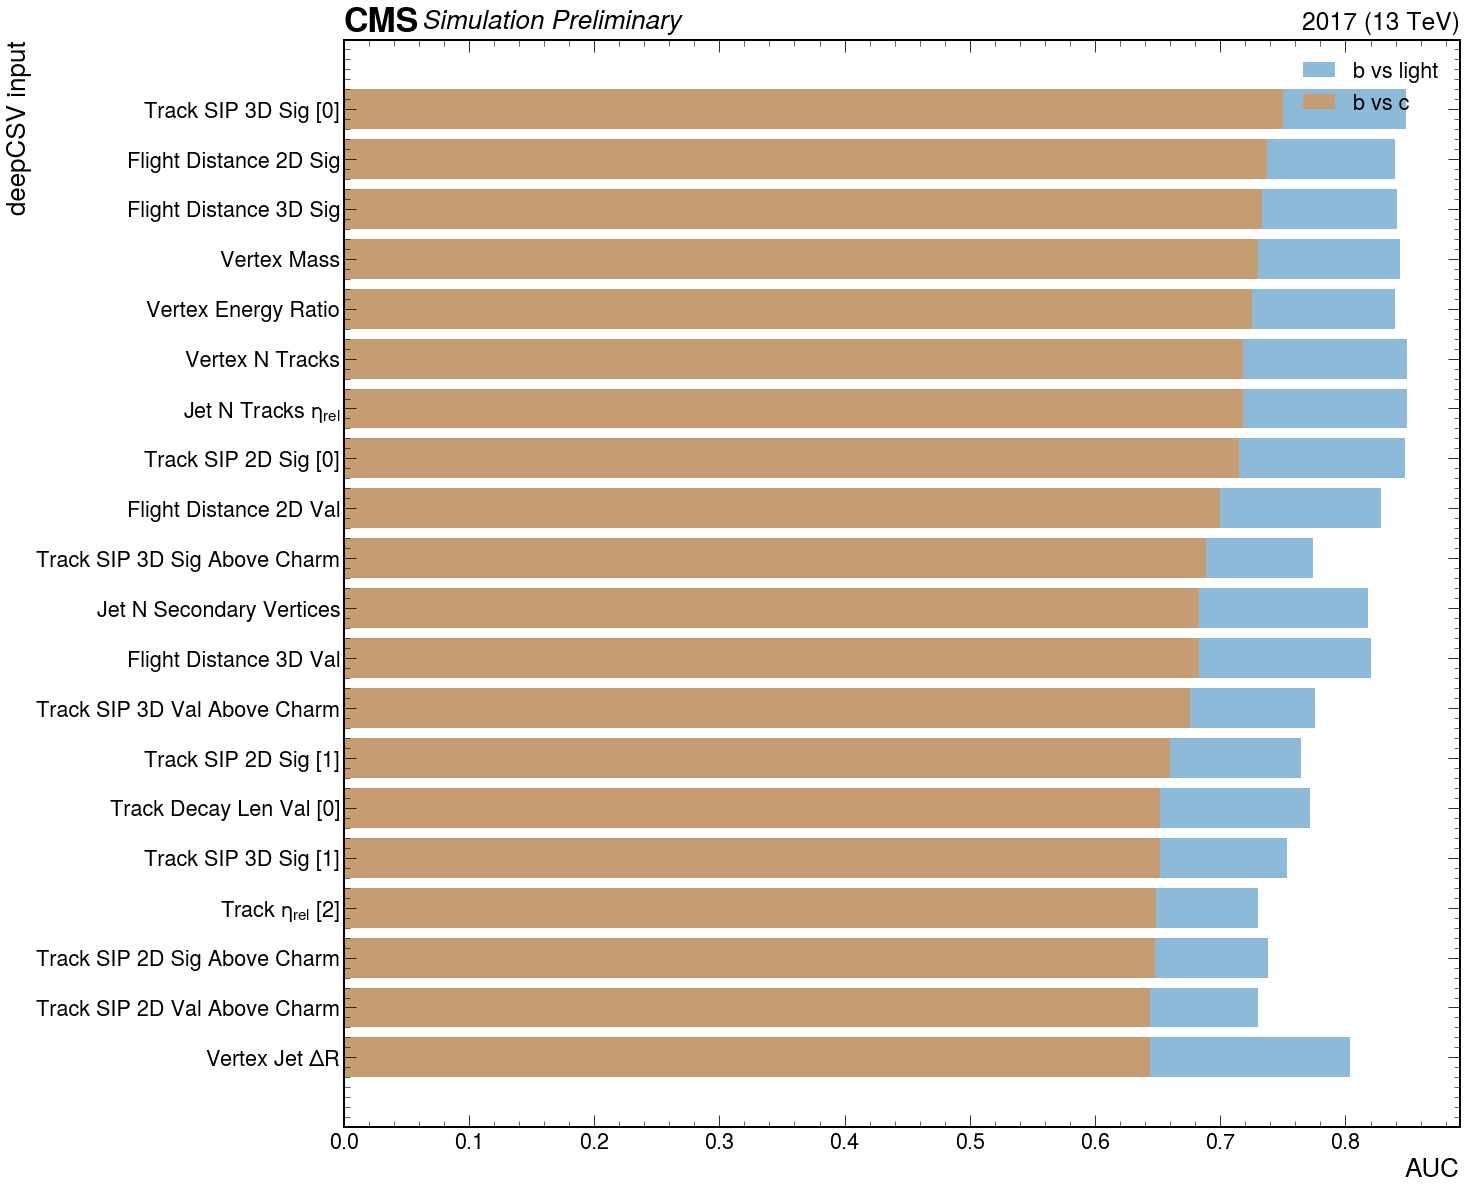

In [44]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [45]:
fgsm_inputs = np.vstack([compare_inputs(p,[0.00],minimum=None,maximum=None,reduced=True) for p in range(67)])

In [46]:
fgsm_inputs = fgsm_inputs.transpose()

In [47]:
len(fgsm_inputs)

1000

In [48]:
fgsm_inputsNP = fgsm_inputs
flav = torch.cat(tuple(torch.load(ti) for ti in test_target_file_paths)).numpy().astype(int) + 1
fgsm_inputsNP = np.c_[fgsm_inputsNP, flav[:1000]]

In [49]:
list_variables = []
list_auc_bvl = []
list_auc_bvc = []

for deepcsv_input in range(67):
    
    bvl = fgsm_inputsNP[fgsm_inputsNP[:,-1] != 3]
    y_true_bvl = bvl[:,-1] != 4
    y_pred_bvl = bvl[:,deepcsv_input]
        
    bvc = fgsm_inputsNP[fgsm_inputsNP[:,-1] != 4]
    y_true_bvc = bvc[:,-1] != 3
    y_pred_bvc = bvc[:,deepcsv_input]
    
    
    auc_bvl = roc_auc_score(y_true_bvl, y_pred_bvl)
    auc_bvc = roc_auc_score(y_true_bvc, y_pred_bvc)
    
    print(f'Variable: {display_names[deepcsv_input]}, AUC bvl: {auc_bvl}, AUC bvc: {auc_bvc}')
    
    list_variables.append(display_names[deepcsv_input])
    list_auc_bvl.append(auc_bvl)
    list_auc_bvc.append(auc_bvc)
    
df = pd.DataFrame(list(zip(list_variables, list_auc_bvl, list_auc_bvc)), columns =['input_name', 'auc_bvl', 'auc_bvc'])

Variable: Jet $\eta$, AUC bvl: 0.49183661137798723, AUC bvc: 0.534375
Variable: Jet $p_T$, AUC bvl: 0.712202785582646, AUC bvc: 0.5395833333333333
Variable: Flight Distance 2D Sig, AUC bvl: 0.8440647753708571, AUC bvc: 0.7470383986928104
Variable: Flight Distance 2D Val, AUC bvl: 0.829623251457748, AUC bvc: 0.7011029411764707
Variable: Flight Distance 3D Sig, AUC bvl: 0.8442581346868485, AUC bvc: 0.7455473856209149
Variable: Flight Distance 3D Val, AUC bvl: 0.8231457143720353, AUC bvc: 0.6895833333333333
Variable: Track Decay Len Val [0], AUC bvl: 0.7858334088643162, AUC bvc: 0.6642973856209149
Variable: Track Decay Len Val [1], AUC bvl: 0.7593129701803679, AUC bvc: 0.6457720588235295
Variable: Track Decay Len Val [2], AUC bvl: 0.6866853983504033, AUC bvc: 0.5790849673202614
Variable: Track Decay Len Val [3], AUC bvl: 0.6473397987854618, AUC bvc: 0.5155024509803922
Variable: Track Decay Len Val [4], AUC bvl: 0.622242363817638, AUC bvc: 0.49991830065359477
Variable: Track Decay Len Val 

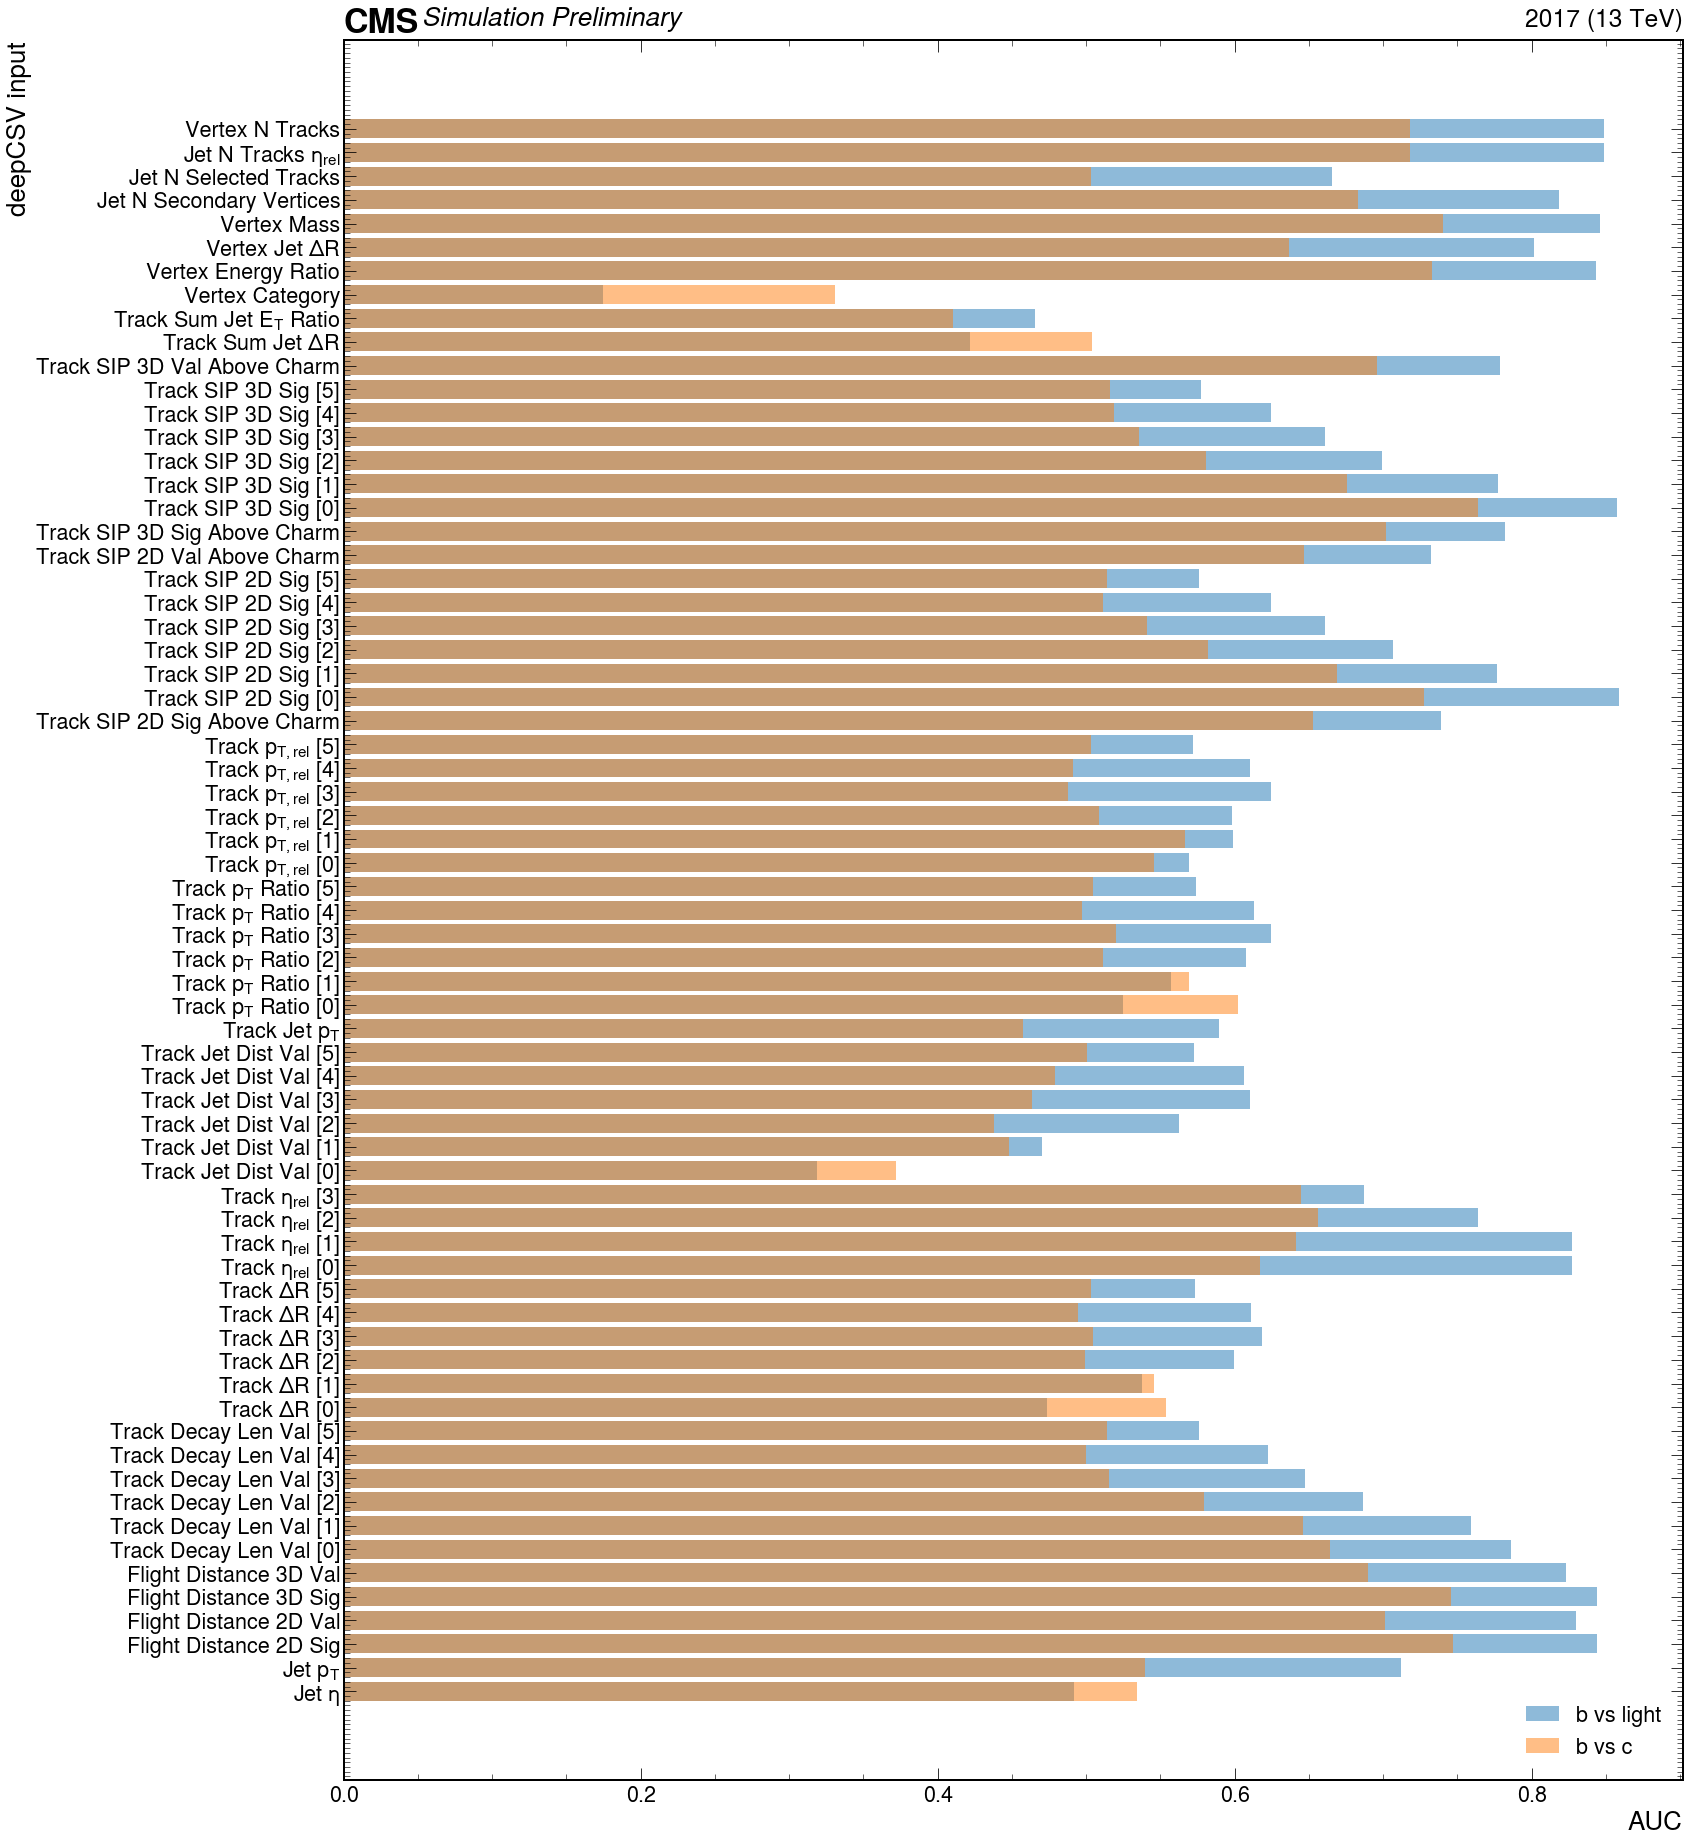

In [50]:
f, ax = plt.subplots(figsize=(24, 32))
hep.cms.label(loc=0)

ax.barh(df['input_name'], df['auc_bvl'], alpha=0.5, label='b vs light')
ax.barh(df['input_name'], df['auc_bvc'], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [51]:
sorted_df = df.sort_values('auc_bvl')

In [52]:
sorted_df

input_name   auc_bvl   auc_bvc
59            Vertex Category  0.174398  0.330801
22     Track Jet Dist Val [0]  0.318943  0.372018
57   Track Sum Jet $\Delta R$  0.421831  0.503881
58  Track Sum Jet $E_T$ Ratio  0.465416  0.410253
23     Track Jet Dist Val [1]  0.470153  0.448243
..                        ...       ...       ...
62                Vertex Mass  0.846089  0.740482
65  Jet N Tracks $\eta_{rel}$  0.848778  0.718158
66            Vertex N Tracks  0.848778  0.718158
50       Track SIP 3D Sig [0]  0.857470  0.763889
42       Track SIP 2D Sig [0]  0.858875  0.727185

[67 rows x 3 columns]

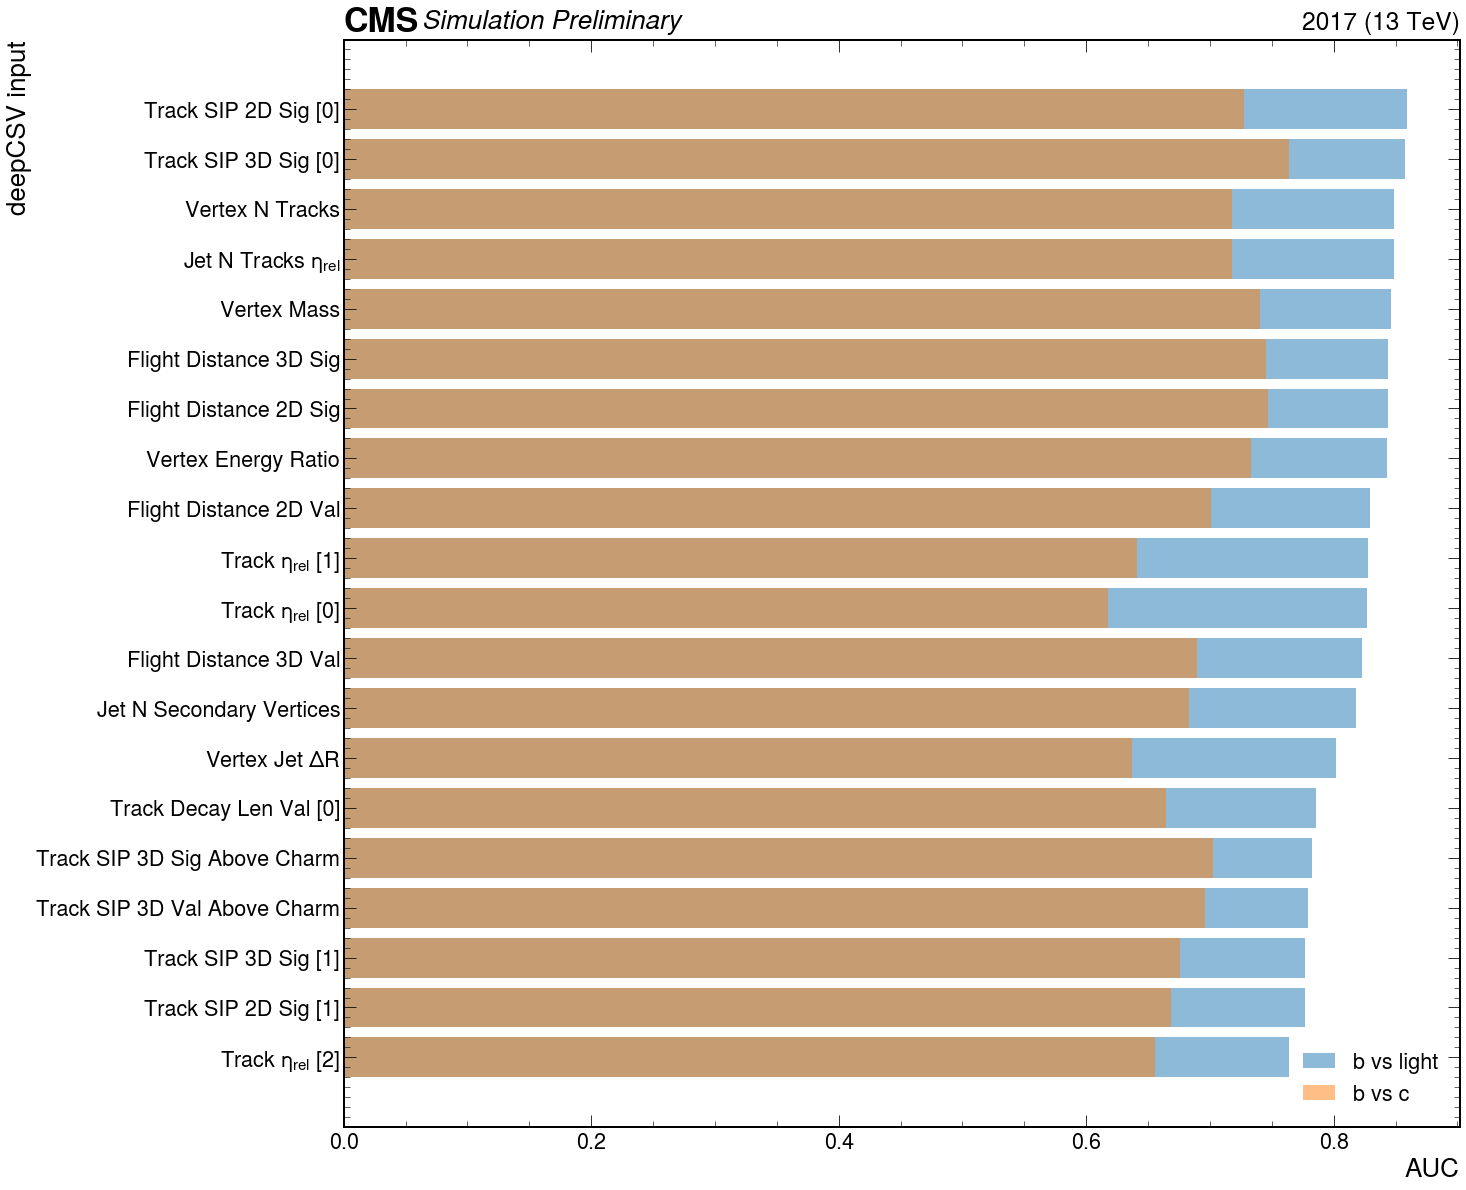

In [53]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()

In [54]:
sorted_df = df.sort_values('auc_bvc')

In [55]:
sorted_df

input_name   auc_bvl   auc_bvc
59            Vertex Category  0.174398  0.330801
22     Track Jet Dist Val [0]  0.318943  0.372018
58  Track Sum Jet $E_T$ Ratio  0.465416  0.410253
24     Track Jet Dist Val [2]  0.562778  0.438051
23     Track Jet Dist Val [1]  0.470153  0.448243
..                        ...       ...       ...
60        Vertex Energy Ratio  0.843439  0.732884
62                Vertex Mass  0.846089  0.740482
4      Flight Distance 3D Sig  0.844258  0.745547
2      Flight Distance 2D Sig  0.844065  0.747038
50       Track SIP 3D Sig [0]  0.857470  0.763889

[67 rows x 3 columns]

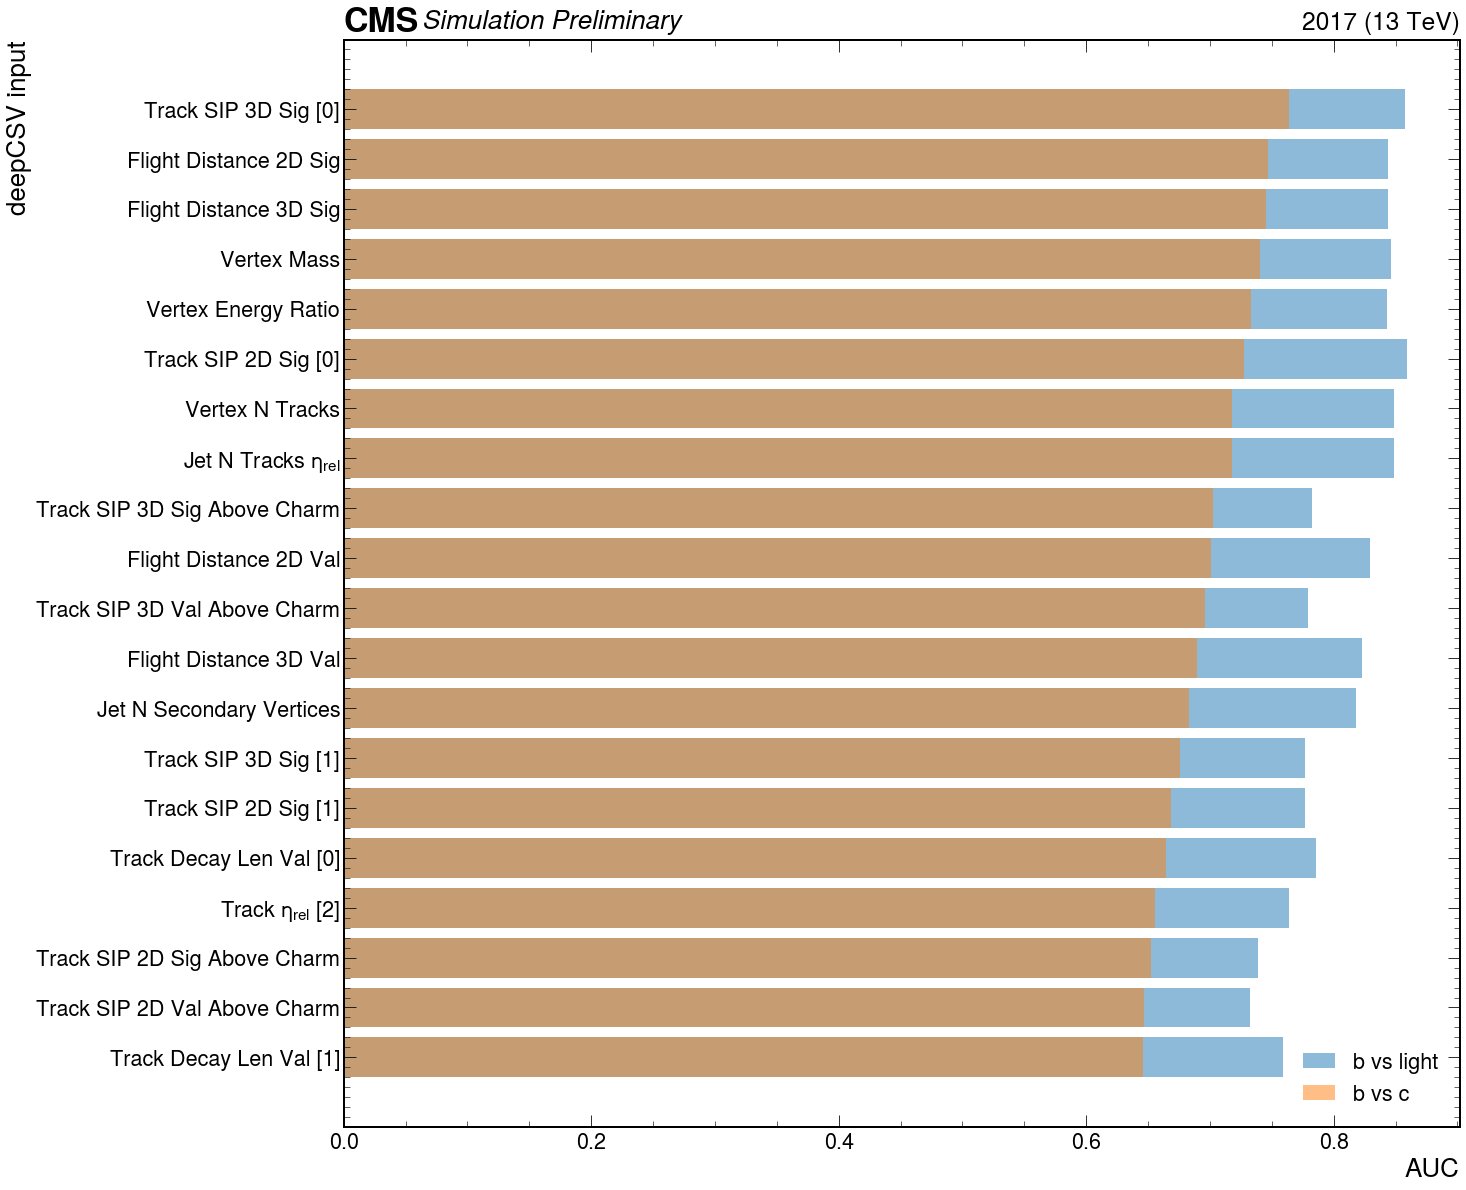

In [56]:
f, ax = plt.subplots(figsize=(20, 20))
hep.cms.label(loc=0)

ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvl'][-20:], alpha=0.5, label='b vs light')
ax.barh(sorted_df['input_name'][-20:], sorted_df['auc_bvc'][-20:], alpha=0.5, label='b vs c')

plt.legend()
plt.xlabel('AUC')
plt.ylabel('deepCSV input')

plt.show()